# Compound Flooding Analysis 

**Objective:** Quantify the relationship between river discharge and offshore water level extremes at the Volta River Estuary to assess compound flooding potential.

**Study Area:**
- Volta River Estuary, Ghana
- Estuary bounds: lat [5.73, 5.83]°, lon [0.64, 0.75]°
- Context bounds for maps: lat [3, 9]°, lon [−3, 3]°
- Reference points: at the mouth river (0.667E  5.77N) and at the Volta Lake (0.087E, 6.267N)

**Datasets:**
- **GloFAS v4.0**: Daily river discharge in the last 24h (`dis24`), units m³/s, 2010–2021.
- **JRC Maximum Daily Global Open Ocean Water Level**: Offshore daily maximum WL, units 10⁻⁴ m, 1959–2021.

In [153]:
# --- Reproducibility & environment check ---
import sys, platform, importlib
def check(modname):
    try:
        m = importlib.import_module(modname)
        v = getattr(m, "__version__", "installed")
        print(f"{modname:<10} {v}")
    except ImportError:
        print(f"{modname:<10} NOT INSTALLED")

print("Interpreter:", sys.executable)
print("Python     :", sys.version.split()[0])
print("Platform   :", platform.platform())
for name in ["numpy","pandas","xarray","matplotlib","cartopy","netCDF4","cdsapi","dask"]:
    check(name)

Interpreter: c:\Users\aless\Desktop\tesi\SoC_master_thesis_git\.venv\Scripts\python.exe
Python     : 3.13.4
Platform   : Windows-11-10.0.26100-SP0
numpy      2.3.3
pandas     2.3.2
xarray     2025.9.0
matplotlib 3.10.6
cartopy    0.25.0
netCDF4    1.7.2
cdsapi     installed
dask       2025.9.0


# Import libraries and useful functions

In [154]:
# Standard library
import os, calendar, glob, hashlib, sys, math
import calendar
import locale

locale.setlocale(locale.LC_TIME, "C")  # C locale = English
months = list(calendar.month_name)[1:]

from pathlib import Path
from typing import Dict, List, Tuple, Optional
from requests import HTTPError
from urllib.parse import urljoin, urlparse
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
import re
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from scipy.stats import kendalltau, spearmanr

# Scientific computing
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Geospatial
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    from matplotlib.patches import Rectangle
    HAS_CARTOPY = True
except Exception:
    HAS_CARTOPY = False

# cds
try:
    import cdsapi
    HAS_CDS = True
except Exception:
    HAS_CDS = False

In [234]:
%pip install -U copulas
# (optional) also ensure deps you use are present
%pip install -U numpy scipy pandas scikit-learn


   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ------- -------------------------------- 1.8/9.8 MB 9.5 MB/s eta 0:00:01
   ------------ --------------------------- 3.1/9.8 MB 8.2 MB/s eta 0:00:01
   ----------------- ---------------------- 4.2/9.8 MB 7.1 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.8 MB 6.7 MB/s eta 0:00:01
   -------------------------- ------------- 6.6/9.8 MB 6.5 MB/s eta 0:00:01
   ----------------------------- ---------- 7.3/9.8 MB 6.0 MB/s eta 0:00:01
   ---------------------------------- ----- 8.4/9.8 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 5.8 MB/s  0:00:01

   ---------------------------------------- 0/3 [narwhals]
   ---------------------------------------- 0/3 [narwhals]
   ---------------------------------------- 0/3 [narwhals]
   ---------------------------------------- 0/3 [narwhals]
   ----------

  You can safely remove it manually.
  You can safely remove it manually.


In [155]:
## Define useful functions ##

# Month names used for x-axis labels
month_names = [m for m in calendar.month_name[1:]]  # ['Jan', 'Feb', ..., 'Dec']

def to_datetime64_from_cftime(tcoord):
    """Convert cftime/CFTimeIndex to numpy datetime64[ns] (YYYY-MM-DD)."""
    return pd.to_datetime([f"{t.year:04d}-{t.month:02d}-{t.day:02d}" for t in tcoord.values])

def year_ticks_for(da_with_time):
    """
    Build yearly ticks/labels from a DataArray with a 'time' coord.
    Returns (ticks, labels) and includes the final +1 year for the right edge.
    """
    years = np.unique(da_with_time['time.year'].values)
    ticks  = [pd.Timestamp(f"{y}-01-01") for y in years] + [pd.Timestamp(f"{years[-1]+1}-01-01")]
    labels = list(years) + [int(years[-1] + 1)]
    return ticks, labels

def month_ticks_for(reference_year: int, abbrev: bool = False):
    """
    Monthly ticks/labels anchored to 'reference_year'.
    Set abbrev=True if you ever want 'Jan, Feb, ...' instead.
    """
    ticks  = pd.date_range(f"{reference_year}-01-01", periods=12, freq="MS")
    labels = [m[:3] for m in calendar.month_name[1:]] if abbrev else list(calendar.month_name[1:])
    return ticks, labels

def detrend_dim(da, dim="time", deg=1, baseline=None, return_trend=False, skipna=True):
    """
    Polynomial detrend along `dim` using xarray's native datetime handling.
    Optionally fit on a `baseline=(start, end)` window, apply to full series.
    """
    da_fit = da.sel({dim: slice(*baseline)}) if baseline else da
    p = da_fit.polyfit(dim=dim, deg=deg, skipna=skipna)
    fit = xr.polyval(da[dim], p.polyfit_coefficients).astype(da.dtype)
    detr = (da - fit).assign_attrs(da.attrs)
    detr.name = (da.name or "var") + "_detrended"
    if return_trend:
        fit.name = (da.name or "var") + "_trend"
        return detr, fit
    return detr

def anom(xarr, baseline=('2010-01-01','2021-12-31')):
    base = xarr.sel(time=slice(*baseline)) if baseline else xarr
    clim = base.groupby('time.month').mean('time')
    ano  = xarr.groupby('time.month') - clim
    return ano, clim

def anomd(xarr, baseline=('2010-01-01','2021-12-31'), deg=1):
    x_det, trend = detrend_dim(xarr, dim='time', deg=deg, baseline=baseline, return_trend=True)
    base_det = x_det.sel(time=slice(*baseline)) if baseline else x_det
    clim_d = base_det.groupby('time.month').mean('time')
    ano_d  = x_det.groupby('time.month') - clim_d
    return ano_d, clim_d, trend

# Study Area

In [156]:
# Define bounds for the Volta River Estuary Area
lat_min, lat_max = 5.73, 5.83
lon_min, lon_max = 0.64, 0.75

# Full map bounds
full_lat_min, full_lat_max = 3, 9
full_lon_min, full_lon_max = -3, 3

# Specific points
lon_estuary, lat_estuary = 0.667, 5.77 # these coordinates are chosen at the estuary, near Ada Foah
lon_lake, lat_lake = 0.087, 6.267 # these are the coordinates of the Volta River just downstream of Volta Lake, close to Akosombo.


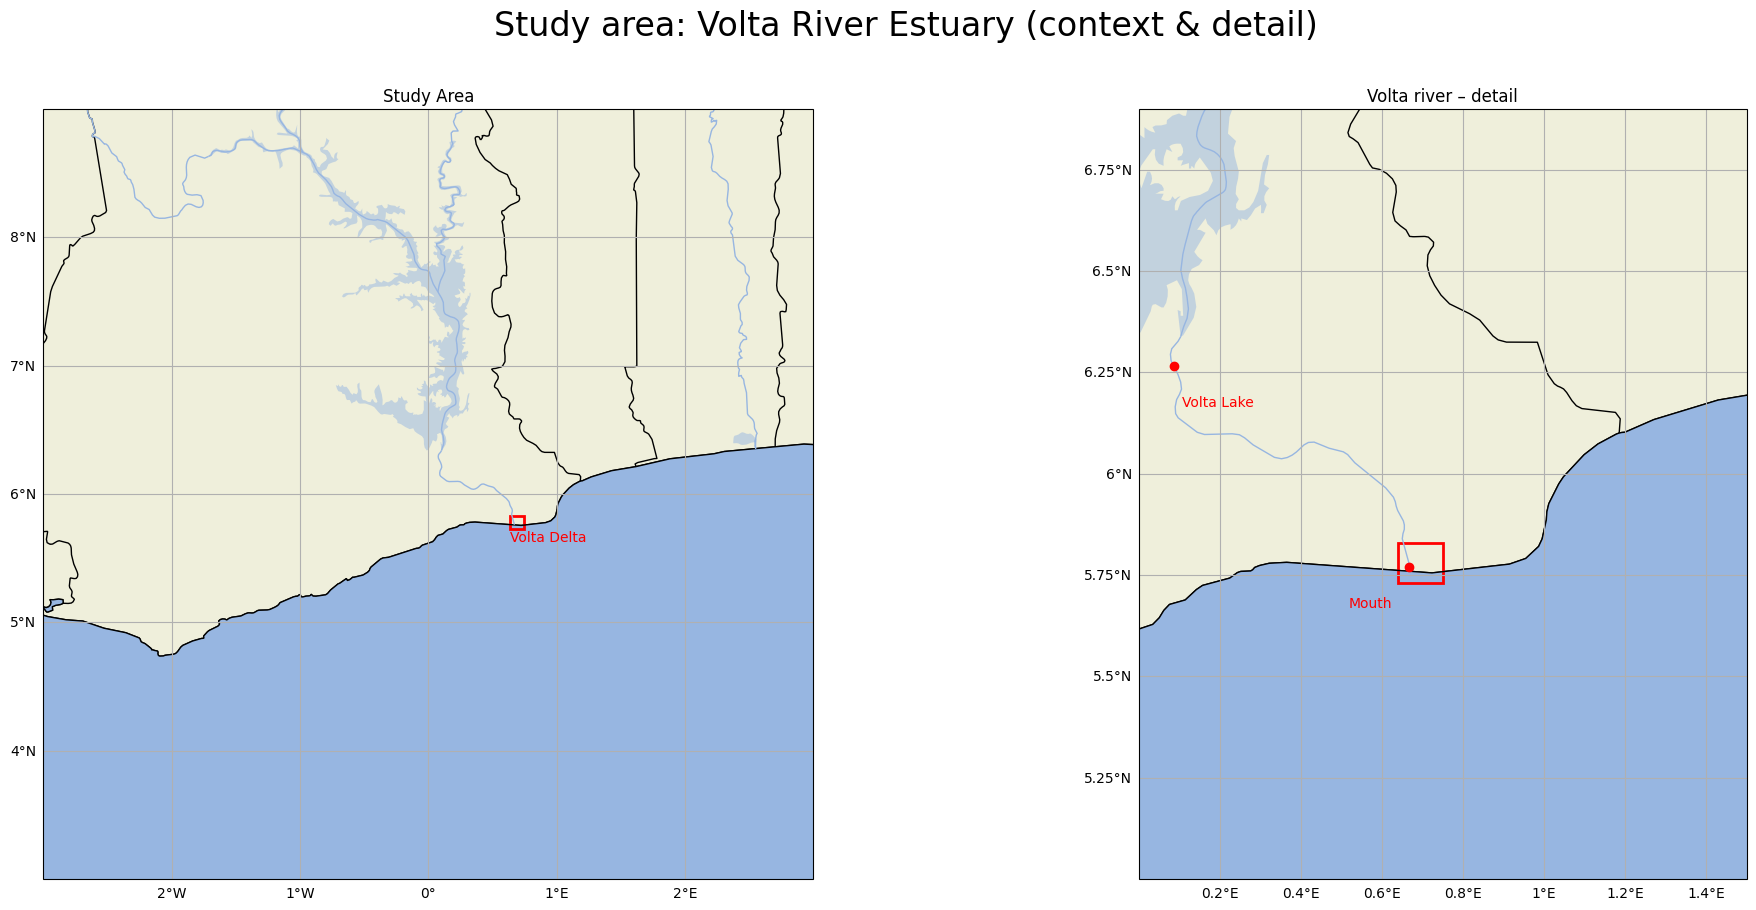

In [157]:
# Overview map + zoom
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 10), subplot_kw={"projection": ccrs.PlateCarree()})
fig.suptitle("Study area: Volta River Estuary (context & detail)", fontsize=24)

    # Context
ax0 = ax[0]
ax0.set_extent([full_lon_min, full_lon_max, full_lat_min, full_lat_max])
ax0.coastlines("10m")
ax0.add_feature(cfeature.BORDERS, linewidth=1)
ax0.add_feature(cfeature.LAND, edgecolor='black')
ax0.add_feature(cfeature.RIVERS)
ax0.add_feature(cfeature.LAKES, alpha=0.5)
ax0.add_feature(cfeature.OCEAN)
gl0 = ax0.gridlines(draw_labels=True)
gl0.top_labels = False; gl0.right_labels = False
gl0.xformatter = LONGITUDE_FORMATTER; gl0.yformatter = LATITUDE_FORMATTER
ax0.set_title("Study Area")
rect = Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min,
                     linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax0.add_patch(rect)
ax0.text(lon_min, lat_max-0.2, "Volta Delta", color="red", transform=ccrs.PlateCarree())

# Detail
ax1 = ax[1]
ax1.set_extent([0, 1.5, 5, 6.9])
ax1.coastlines("10m")
ax1.add_feature(cfeature.BORDERS, linewidth=1)
ax1.add_feature(cfeature.LAND, edgecolor='black')
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES, alpha=0.5)
ax1.add_feature(cfeature.OCEAN)
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False; gl1.right_labels = False
gl1.xformatter = LONGITUDE_FORMATTER; gl1.yformatter = LATITUDE_FORMATTER
ax1.set_title("Volta river – detail")
rect2 = Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min,
                      linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax1.add_patch(rect2)

# Points
ax1.plot([lon_estuary, lon_lake], [lat_estuary, lat_lake], 'o', color='red', transform=ccrs.PlateCarree())
ax1.text(lon_estuary-0.15, lat_estuary-0.1, "Mouth", color='red', transform=ccrs.PlateCarree())
ax1.text(lon_lake+0.02,  lat_lake-0.1,   "Volta Lake", color='red', transform=ccrs.PlateCarree())
plt.show()


For further analysis, it will be take into account a single point, located at the Volta River Mouth (5.77°N e 0.667°E), and an additional point further upstream, at Volta Lake (6.50°N, 0.117°E).


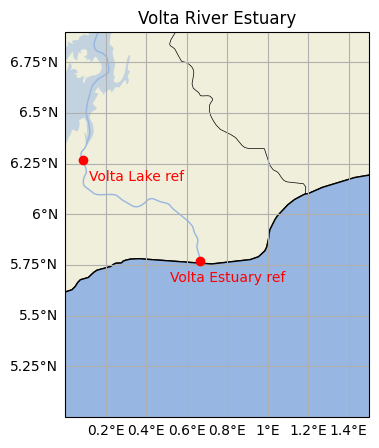

In [158]:
# Base map with points
fig = plt.figure(figsize=(6,5))
axb = plt.axes(projection=ccrs.PlateCarree())
axb.set_extent([0, 1.5, 5, 6.9])
axb.coastlines("10m")
axb.add_feature(cfeature.LAND, edgecolor='black')
axb.add_feature(cfeature.BORDERS, linewidth=0.5)
axb.add_feature(cfeature.RIVERS)
axb.add_feature(cfeature.LAKES, alpha=0.5)
axb.add_feature(cfeature.OCEAN)
gl = axb.gridlines(draw_labels=True)
gl.right_labels = False; gl.top_labels = False
axb.plot([lon_estuary, lon_lake], [lat_estuary, lat_lake], 'o', color='red', transform=ccrs.PlateCarree())
axb.text(lon_estuary-0.15, lat_estuary-0.1, 'Volta Estuary ref', color='red', transform=ccrs.PlateCarree())
axb.text(lon_lake+0.03,    lat_lake-0.1,    'Volta Lake ref',   color='red', transform=ccrs.PlateCarree())
axb.set_title("Volta River Estuary")
plt.show()

# Load and preprocess data

In [159]:
# Data locations – local paths
GLOFAS_DIR = r"C:/Users/aless/Desktop/tesi/data/glofas_keta"
JRC_DIR    = r"C:/Users/aless/Desktop/tesi/data/globalDailyMaxWaterLevel/VER2024-05-03"

In [160]:
# Periods
BASELINE = ("2010-01-01", "2021-12-31")
GLOFAS_YEARS = list(range(2010, 2022))    # inclusive
JRC_PERIOD   = ("2010-01-01", "2021-12-31")

# GloFAS area ([N, W, S, E])
GLOFAS_AREA = [9, -3, 0, 3]

# Nodata for GloFAS
GLOFAS_NODATA = 9999.0

## GloFAS data
**GloFAS v4.0 (cems-glofas-historical)**
- **Source:** CEMS Early Warning Data Store (EWDS), Copernicus (https://ewds.climate.copernicus.eu/datasets/cems-glofas-historical?tab=overview).
- **Time span used here:** 2010–2021 (inclusive), **daily** discharge in last 24h.
- **Variable / units:** `dis24` (river discharge in the last 24 h), m³/s.
- **Spatial subset:** [0–9°N, 3°W–3°E] (area = [N, W, S, E]).
- **Acquisition:** API request kept in code for reproducibility; `dry_run=True` prevents re-downloads (files were already retrieved).
- **Preprocessing:** Per-year NetCDF files concatenated along `time`, sorted by time, duplicates handled; nearest grid cell to (5.77°N, 0.667°E) and (6.50°N, 0.117°E).


In [161]:
# Working directory and configuration
years: List[int] = list(range(2010, 2022)) # 2010..2021 inclusive
area = [9, -3, 0, 3] # [North, West, South, East] => 0–9°N, 3°W–3°E
dry_run = False       # set to False if you want to download
os.makedirs(GLOFAS_DIR, exist_ok=True)

def build_glofas_request(year: int,
                         data_format: str = "grib2",
                         system_version: str = "version_4_0") -> Dict:
    return {
        "system_version": [system_version],
        "hydrological_model": ["lisflood"],
        "product_type": ["consolidated"],
        "variable": ["river_discharge_in_the_last_24_hours"],
        "hyear": [f"{year}"],
        "hmonth": [f"{m:02d}" for m in range(1, 13)],
        "hday": [f"{d:02d}" for d in range(1, 32)],
        "area": area,                       # [N, W, S, E]
        "data_format": data_format,         # EWDS shows grib2 for this dataset
        "download_format": "unarchived",    # optional but fine
    }

def _sha256(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1 << 20), b""):
            h.update(chunk)
    return h.hexdigest()

def request_glofas_year(year: int, force: bool = False, min_ok_size: int = 1_000_000) -> Dict:
    """
    Download one year unless an existing file looks good.
    - force=True     -> always re-download
    - min_ok_size    -> files smaller than this are treated as incomplete
    """
    name = f"glofas_dis24_{year}.grib2"
    path = os.path.join(GLOFAS_DIR, name)
    tmp = path + ".part"

    existed = os.path.exists(path)
    size_before = os.path.getsize(path) if existed else 0

    if existed and size_before >= min_ok_size and not force:
        print(f"✔ {name} present ({size_before/1e6:.1f} MB) — skipping.")
        return {"year": year, "action": "skipped", "path": path, "size": size_before}

    req = build_glofas_request(year)
    if dry_run:
        print(f"[DRY RUN] Would {'re-' if existed else ''}download {name} with request = {req}")
        return {"year": year, "action": "dry_run", "path": path}

    # Remove any stale partial file before starting
    if os.path.exists(tmp):
        try:
            os.remove(tmp)
        except OSError:
            pass

    c = cdsapi.Client()
    print(f"⬇ {'Re-' if existed else ''}downloading {name} ...")
    try:
        c.retrieve("cems-glofas-historical", req, tmp)
        os.replace(tmp, path)  # atomic move
    except HTTPError as e:
        try:
            print("Server says:", e.response.text[:2000])
        except Exception:
            pass
        # Best effort cleanup of partial
        if os.path.exists(tmp):
            try:
                os.remove(tmp)
            except OSError:
                pass
        raise

    size_after = os.path.getsize(path)
    info = {
        "year": year,
        "action": "downloaded" if not existed else "re-downloaded",
        "path": path,
        "size": size_after,
        "hash": _sha256(path),
    }
    print(f"✔ {name} saved ({size_after/1e6:.1f} MB)")
    return info

# Full run
summary = [request_glofas_year(y) for y in years] # normal run
# request_glofas_year(2015, force=True)                    # force only a year
# summary = [request_glofas_year(y, min_ok_size=5_000_000) for y in years]  # stricter size check
print("Done.")


✔ glofas_dis24_2010.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2011.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2012.grib2 present (10.1 MB) — skipping.
✔ glofas_dis24_2013.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2014.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2015.grib2 present (11.1 MB) — skipping.
✔ glofas_dis24_2016.grib2 present (10.1 MB) — skipping.
✔ glofas_dis24_2017.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2018.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2019.grib2 present (10.0 MB) — skipping.
✔ glofas_dis24_2020.grib2 present (10.1 MB) — skipping.
✔ glofas_dis24_2021.grib2 present (10.0 MB) — skipping.
Done.


In [162]:
# Read local files and concatenate (no network)
files_glofas = sorted(glob.glob(os.path.join(GLOFAS_DIR, "*.nc")))
if not files_glofas:
    raise FileNotFoundError(f"No .nc files found in {GLOFAS_DIR}. Put your existing files there.")

# Open and combine files
datasets = [xr.open_dataset(p) for p in files_glofas]
glofas_keta = xr.concat(datasets, dim="time")  
glofas_keta

<xarray.Dataset> Size: 252MB
Dimensions:    (time: 4383, latitude: 120, longitude: 120)
Coordinates:
  * latitude   (latitude) float32 480B 3.025 3.075 3.125 ... 8.875 8.925 8.975
  * longitude  (longitude) float32 480B -2.975 -2.925 -2.875 ... 2.925 2.975
  * time       (time) datetime64[ns] 35kB 2010-02-01 2010-02-02 ... 2021-12-31
Data variables:
    dis24      (time, latitude, longitude) float32 252MB 9.999e+03 ... 0.0

In [163]:
# Checking on and sorting the 'time' variable

# Get a DatetimeIndex for convenience
t = getattr(glofas_keta.indexes, 'time', pd.DatetimeIndex(glofas_keta['time'].values))
print("Count:", t.size)
print("First :", t[0])
print("Last  :", t[-1])

# Sortedness / monotonicity
print("Monotonic increasing:", t.is_monotonic_increasing)
print("Has duplicates      :", t.has_duplicates)

# Peek at the edges
print("Head:", t[:5].tolist())
print("Tail:", t[-5:].tolist())

# Frequency / regularity
print("Inferred frequency  :", t.inferred_freq)  # None => irregular

# Show where ordering is broken (if any)
bad_order_idx = np.where(t[1:] < t[:-1])[0]
print("Out-of-order indices:", bad_order_idx[:10], "(showing up to 10)")

# Gap summary (how many times each delta occurs)
diffs = pd.Series(t[1:] - t[:-1])
print("Most common gaps:\n", diffs.value_counts().head(5))
print("Unique gaps:", pd.unique(diffs))

Count: 4383
First : 2010-02-01 00:00:00
Last  : 2021-12-31 00:00:00
Monotonic increasing: False
Has duplicates      : False
Head: [Timestamp('2010-02-01 00:00:00'), Timestamp('2010-02-02 00:00:00'), Timestamp('2010-02-03 00:00:00'), Timestamp('2010-02-04 00:00:00'), Timestamp('2010-02-05 00:00:00')]
Tail: [Timestamp('2021-12-27 00:00:00'), Timestamp('2021-12-28 00:00:00'), Timestamp('2021-12-29 00:00:00'), Timestamp('2021-12-30 00:00:00'), Timestamp('2021-12-31 00:00:00')]
Inferred frequency  : None
Out-of-order indices: [ 147  512  878 1243 1608 1973 2339 2704 3069 3434] (showing up to 10)
Most common gaps:
 1 days       4251
31 days        48
32 days        47
63 days        12
-333 days       9
Name: count, dtype: int64
Unique gaps: [    86400000000000   2764800000000000   5443200000000000
 -28771200000000000   2505600000000000   2678400000000000
 -28857600000000000   2592000000000000]


In [164]:
# Show the exact out-of-order transitions (with context)
t = glofas_keta.get_index('time')
bad_idx = np.where(t[1:] < t[:-1])[0]  # indices where next < prev
print("Out-of-order count:", bad_idx.size)

# Show a little neighborhood around each break
for i in bad_idx:
    lo = max(0, i-2)
    hi = min(len(t), i+3)
    print(f"\nBreak at i={i} (t[i] -> t[i+1]):")
    print(pd.Series(t[lo:hi]).to_string())

Out-of-order count: 12

Break at i=147 (t[i] -> t[i+1]):
0   2010-11-28
1   2010-11-29
2   2010-11-30
3   2010-01-01
4   2010-01-02

Break at i=512 (t[i] -> t[i+1]):
0   2011-11-28
1   2011-11-29
2   2011-11-30
3   2011-01-01
4   2011-01-02

Break at i=878 (t[i] -> t[i+1]):
0   2012-11-28
1   2012-11-29
2   2012-11-30
3   2012-01-01
4   2012-01-02

Break at i=1243 (t[i] -> t[i+1]):
0   2013-11-28
1   2013-11-29
2   2013-11-30
3   2013-01-01
4   2013-01-02

Break at i=1608 (t[i] -> t[i+1]):
0   2014-11-28
1   2014-11-29
2   2014-11-30
3   2014-01-01
4   2014-01-02

Break at i=1973 (t[i] -> t[i+1]):
0   2015-11-28
1   2015-11-29
2   2015-11-30
3   2015-01-01
4   2015-01-02

Break at i=2339 (t[i] -> t[i+1]):
0   2016-11-28
1   2016-11-29
2   2016-11-30
3   2016-01-01
4   2016-01-02

Break at i=2704 (t[i] -> t[i+1]):
0   2017-11-28
1   2017-11-29
2   2017-11-30
3   2017-01-01
4   2017-01-02

Break at i=3069 (t[i] -> t[i+1]):
0   2018-11-28
1   2018-11-29
2   2018-11-30
3   2018-01-01
4   2

In [165]:
# Sort by time and verify
glofas_sorted = glofas_keta.sortby('time')
ti = glofas_sorted.get_index('time')

print("Monotonic after sort:", ti.is_monotonic_increasing)
print("Start/End after sort:", ti[0], ti[-1])
print("Inferred freq after sort:", ti.inferred_freq)  # still None if gaps remain

Monotonic after sort: True
Start/End after sort: 2010-01-01 00:00:00 2021-12-31 00:00:00
Inferred freq after sort: D


In [166]:
# Identify and list missing dates (daily grid)
full = pd.date_range(t.min(), t.max(), freq='D')
have = glofas_sorted.time.to_index()
missing = full.difference(have)
print("Missing days:", len(missing))
print("First 20 missing:\n", pd.Series(missing[:20]))

# Summarize missing by year
miss_df = pd.DataFrame({"date": missing})
miss_df["year"] = miss_df["date"].dt.year
print(miss_df["year"].value_counts().sort_index())

Missing days: 0
First 20 missing:
 Series([], dtype: datetime64[ns])
Series([], Name: count, dtype: int64)


In [167]:
# Extract raw (daily) values to the point closest to the two points
rd_estuary = glofas_sorted['dis24'].sel(latitude = lat_estuary, longitude = lon_estuary, method='nearest')
rd_lake = glofas_sorted['dis24'].sel(latitude = lat_lake, longitude = lon_lake, method='nearest')

# confirm where we actually landed
sel_estuary_lat = float(rd_estuary.latitude.values)
sel_estuary_lon = float(rd_estuary.longitude.values)
sel_lake_lat  = float(rd_lake.latitude.values)
sel_lake_lon  = float(rd_lake.longitude.values)

print("Estuary grid cell:",  sel_estuary_lat, sel_estuary_lon)
print("Lake grid cell:",   sel_lake_lat,  sel_lake_lon)

Estuary grid cell: 5.775000095367432 0.675000011920929
Lake grid cell: 6.275000095367432 0.07500000298023224


## Water Level

**JRC Maximum Daily Global Open Ocean Water Level (VER2024-05-03)**
- **Source:** JRC “Maximum Daily Global Open Ocean Water Level” reanalysis (https://data.jrc.ec.europa.eu/dataset/1c7c05e0-f501-4de1-91c4-0c172ba967fd).
- **Time span available:** 1959–2021; **subset used:** 2010–2021.
- **Variable / units:** `waterLevelreanalysis` in units of \(10^{-4}\) m. **Converted to meters** here by multiplying by \(1\times10^{-4}\).
- **Spatial subset:** points within [3–9°N, 3°W–3°E]; nearest point to (5.77°N, 0.667°E) used for offshore signal.
- **Preprocessing:** Files are supplied as 634 latitude strips; strips were concatenated to form a single dataset, then spatially subset to [3–9°N, 3°W–3°E]. Time coordinate standardized to `time`; files filtered to the study region, concatenated across points, then converted to meters.

In [168]:
# Download Water Level data if not present in the local directory
"""
Download all NetCDF (.nc) files from the JRC LISCOAST 'globalDailyMaxWaterLevel'
FTP-like directory. You can target:
  - the latest published version (VERSION="latest"),
  - all versions (VERSION="all"),
  - or a specific version folder (e.g., VERSION="VER2024-05-03").

Features:
  • Parallel downloads with polite retry logic
  • Skips files already present (compares size via HTTP HEAD)
  • Dry-run mode to preview what would be downloaded
  • Atomic writes via .part + os.replace to avoid half files
"""

# ================== Configuration ==================
BASE_URL   = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LISCOAST/globalDailyMaxWaterLevel/"
OUT_DIR    = r"C:/Users/aless/Desktop/tesi/data/globalDailyMaxWaterLevel"  # destination folder
VERSION    = "latest"   # "latest" | "all" | "VER2024-05-03" (or any listed version)
ONLY_EXT   = ".nc"      # download only NetCDF files
MAX_WORKERS = 4         # number of parallel downloads (keep modest to be polite)
DRY_RUN    = True       # True = show actions without downloading | False = if you want to download the files
# ===================================================

# Ensure destination folder exists
os.makedirs(OUT_DIR, exist_ok=True)


def make_session() -> requests.Session:
    """Create a requests.Session with retries and a custom User-Agent."""
    s = requests.Session()
    s.headers.update({"User-Agent": "liscoast-downloader/1.0"})
    # Retry on common transient HTTP errors (429/5xx), with exponential backoff
    retries = Retry(
        total=5,
        backoff_factor=0.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["HEAD", "GET"],
    )
    adapter = HTTPAdapter(max_retries=retries)
    s.mount("https://", adapter)
    s.mount("http://", adapter)
    return s


def get(session: requests.Session, url: str) -> str:
    """GET a page and return its HTML text. Raises for HTTP errors."""
    r = session.get(url, timeout=60)
    r.raise_for_status()
    return r.text


def head(session: requests.Session, url: str) -> int | None:
    """
    Return the Content-Length (file size in bytes) if the server provides it.
    Fallback to a streamed GET if HEAD is not supported (405).
    """
    r = session.head(url, allow_redirects=True, timeout=60)
    if r.status_code == 405:  # some servers don't implement HEAD
        r = session.get(url, stream=True, timeout=60)
    r.raise_for_status()
    cl = r.headers.get("Content-Length")
    return int(cl) if cl and cl.isdigit() else None


def list_dirs(session: requests.Session, url: str) -> List[str]:
    """
    List version subdirectories like 'VER2024-05-03' from the base index page.
    The index is a simple Apache-style directory listing.
    """
    html = get(session, url)
    # capture strings like href="VER2024-05-03/"
    return sorted(set(re.findall(r'href="(VER\d{4}-\d{2}-\d{2})/', html)))


def list_files(session: requests.Session, url: str, only_ext: str) -> List[Tuple[str, str]]:
    """
    List (name, url) for files in the given version directory that end with only_ext.
    We avoid 'Parent Directory' entries by excluding hrefs that start with '/'.
    """
    html = get(session, url)
    hrefs = re.findall(r'href="([^"/][^"]+)"', html)  # match plain file names
    return [(h, urljoin(url, h)) for h in hrefs if h.lower().endswith(only_ext.lower())]


def pick_latest_version(session: requests.Session) -> str:
    """Pick the lexicographically last version (works because the name contains YYYY-MM-DD)."""
    vers = list_dirs(session, BASE_URL)
    if not vers:
        raise RuntimeError("No versions found in the root directory.")
    # 'VER2024-05-03' sorts correctly by date when we strip the 'VER' prefix
    return sorted(vers, key=lambda v: v.replace("VER", ""))[-1]


def should_skip(local_path: str, remote_size: int | None) -> bool:
    """
    Decide whether to skip downloading a file:
      - If local file doesn't exist -> don't skip
      - If remote_size is unknown -> assume local file is fine and skip
      - Otherwise compare sizes and skip if identical
    """
    if not os.path.exists(local_path):
        return False
    return True if remote_size is None else os.path.getsize(local_path) == remote_size


def download_file(session: requests.Session, url: str, dst: str, remote_size: int | None):
    """
    Download a single file to 'dst'. Writes to a temporary '.part' file and then
    atomically renames it to avoid half-written files on interruptions.
    """
    # Avoid re-downloading existing identical files
    if should_skip(dst, remote_size):
        print(f"✔ {os.path.basename(dst)} present — skip")
        return "skipped"

    # Dry-run mode prints what it *would* do
    if DRY_RUN:
        print(f"[DRY RUN] Would download {os.path.basename(dst)} ({remote_size} bytes)")
        return "dry_run"

    tmp = dst + ".part"
    # Clean up stale partial file if present
    if os.path.exists(tmp):
        try:
            os.remove(tmp)
        except OSError:
            pass

    # Stream the response in chunks so we don't keep the whole file in memory
    with session.get(url, stream=True, timeout=180) as r:
        r.raise_for_status()
        with open(tmp, "wb") as f:
            for chunk in r.iter_content(chunk_size=1 << 20):  # 1 MB chunks
                if chunk:
                    f.write(chunk)

    # Atomic move: ensures we either have the old file or the fully downloaded new file
    os.replace(tmp, dst)
    print(f"⬇ {os.path.basename(dst)} saved ({os.path.getsize(dst)/1e6:.1f} MB)")
    return "downloaded"


def process_version(session: requests.Session, version: str):
    """
    Download all files with the desired extension from one version directory.
    Performs a HEAD first to get sizes for skip logic, then downloads in parallel.
    """
    version_url = urljoin(BASE_URL, version + "/")
    files = list_files(session, version_url, ONLY_EXT)
    if not files:
        print(f"No {ONLY_EXT} files found in {version_url}")
        return

    print(f"[{version}] Found {len(files)} files")
    # Pre-fetch remote sizes for smarter skipping
    sizes = {}
    for name, url in files:
        try:
            sizes[name] = head(session, url)
        except Exception:
            sizes[name] = None  # if size is unknown we still proceed

    # Parallel downloads (keep MAX_WORKERS modest)
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = [
            ex.submit(download_file, session, url, os.path.join(OUT_DIR, name), sizes.get(name))
            for name, url in files
        ]
        # Ensure exceptions propagate here
        for fut in as_completed(futures):
            fut.result()


def main():
    """Entry point: decide which version(s) to process and start downloading."""
    session = make_session()

    if VERSION == "all":
        # Iterate every version folder under the base URL
        for ver in list_dirs(session, BASE_URL):
            print(f"→ Version: {ver}")
            process_version(session, ver)
    else:
        # Either pick the latest or use the specific version string provided
        ver = pick_latest_version(session) if VERSION == "latest" else VERSION
        print(f"→ Using version: {ver}")
        process_version(session, ver)

    print("Done.")


if __name__ == "__main__":
    main()


→ Using version: VER2024-05-03
[VER2024-05-03] Found 634 files
[DRY RUN] Would download pcvar_hindcast_00000001.nc (48278568 bytes)
[DRY RUN] Would download pcvar_hindcast_00000002.nc (52437942 bytes)
[DRY RUN] Would download pcvar_hindcast_00000003.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_00000006.nc (52343658 bytes)
[DRY RUN] Would download pcvar_hindcast_00000005.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_00000004.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_00000007.nc (52296516 bytes)
[DRY RUN] Would download pcvar_hindcast_00000010.nc (52437942 bytes)
[DRY RUN] Would download pcvar_hindcast_00000012.nc (52437942 bytes)
[DRY RUN] Would download pcvar_hindcast_00000011.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_00000014.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_00000015.nc (52437942 bytes)
[DRY RUN] Would download pcvar_hindcast_00000016.nc (52390800 bytes)
[DRY RUN] Would download pcvar_hindcast_

In [169]:
# Import data from working directory
data_dir_w = r"C:/Users/aless/Desktop/tesi/data/globalDailyMaxWaterLevel/VER2024-05-03"
file_jrc = sorted(glob.glob(os.path.join(data_dir_w, "*.nc")))

# Checking for the presence and validity of files in the working directory
valid_files = []
invalid_files = []

for filepath in file_jrc:
    if os.path.isfile(filepath) and filepath.endswith(".nc"):
        try:
            ds = Dataset(filepath)
            ds.close()
            valid_files.append(filepath)
        except:
            invalid_files.append(filepath)
    else:
        invalid_files.append(filepath)
print(f"Valid NetCDF files: {len(valid_files)}")
print(f"Unreadable NetCDF files: {len(invalid_files)}")

if invalid_files:
    print("Examples of invalid files:")
    for f in invalid_files[:5]:
        print(" -", f)

Valid NetCDF files: 634
Unreadable NetCDF files: 0


In [170]:
# Explore data structure
sample_ds = Dataset(valid_files[0])
print("DATASET INFO:")
print(sample_ds)
print("VARIABLES:")
print(sample_ds.variables.keys())

water_var = sample_ds.variables['waterLevelreanalysis'][:]  
print(f"WATER LEVEL shape: {water_var.shape}")
print(f"TIME VARIABLE:", sample_ds['time_1959_2021'])

sample_ds.close()
sample_xr = xr.open_dataset(valid_files[0])
print(sample_xr)
print(sample_xr.coords)
print(sample_xr.dims)
print(sample_xr['waterLevelreanalysis'].attrs)

DATASET INFO:
<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Institution: European Commission, Directorate-General Joint Research Centre, Disaster Risk Management Unit, Via Enrico Fermi 2749, I-21027-Ispra
    dimensions(sizes): pointsSAT(997), PCR(65), pointsATM(36), time_1959_2021(23011)
    variables(dimensions): float64 AC(pointsSAT), float64 PCRcoef(pointsSAT, PCR), float64 latitudeATM(pointsSAT, pointsATM), float64 latitudeSAT(pointsSAT), float64 longitudeATM(pointsSAT, pointsATM), float64 longitudeSAT(pointsSAT), float64 time_1959_2021(time_1959_2021), int16 waterLevelreanalysis(pointsSAT, time_1959_2021)
    groups: 
VARIABLES:
dict_keys(['AC', 'PCRcoef', 'latitudeATM', 'latitudeSAT', 'longitudeATM', 'longitudeSAT', 'time_1959_2021', 'waterLevelreanalysis'])
WATER LEVEL shape: (997, 23011)
TIME VARIABLE: <class 'netCDF4.Variable'>
float64 time_1959_2021(time_1959_2021)
    units: days since 1950-01-01
unlimited dimensions: time_1959_202

In [171]:
# Open and concatenate datasets
filtered = []
for f in file_jrc:
    ds = xr.open_dataset(f)
    mask = ((ds.longitudeSAT >= full_lon_min) & (ds.longitudeSAT <= full_lon_max) &
            (ds.latitudeSAT  >= full_lat_min) & (ds.latitudeSAT  <= full_lat_max))
    ds = ds.sel(pointsSAT=mask)
    if ds.sizes.get("pointsSAT", 0) > 0:
        filtered.append(ds)
if not filtered:
    raise ValueError("No datasets found within the target region. Check coordinate ranges.")

keta_wl = xr.concat(filtered, dim="pointsSAT", combine_attrs="override")
print("Longitude range:", float(keta_wl.longitudeSAT.min()), "to", float(keta_wl.longitudeSAT.max()))
print("Latitude range:",  float(keta_wl.latitudeSAT.min()),  "to", float(keta_wl.latitudeSAT.max()))
keta_wl

Longitude range: -2.875 to 2.875
Latitude range: 3.125 to 6.375


<xarray.Dataset> Size: 46MB
Dimensions:               (pointsSAT: 249, PCR: 65, pointsATM: 36,
                           time_1959_2021: 23011)
Coordinates:
  * time_1959_2021        (time_1959_2021) datetime64[ns] 184kB 1959-01-01 .....
Dimensions without coordinates: pointsSAT, PCR, pointsATM
Data variables:
    AC                    (pointsSAT) float64 2kB 0.9505 0.9525 ... 0.9446
    PCRcoef               (pointsSAT, PCR) float64 129kB 0.03118 ... -0.0005355
    latitudeATM           (pointsSAT, pointsATM) float64 72kB 3.75 3.5 ... 5.75
    latitudeSAT           (pointsSAT) float64 2kB 3.125 3.375 ... 6.125 6.375
    longitudeATM          (pointsSAT, pointsATM) float64 72kB 356.8 ... 3.5
    longitudeSAT          (pointsSAT) float64 2kB -2.625 -2.625 ... 2.875 2.875
    waterLevelreanalysis  (pointsSAT, time_1959_2021) float64 46MB 390.0 ... ...
Attributes:
    Institution:  European Commission, Directorate-General Joint Research Cen...

In [172]:
# Convert to meters (x 1e-4)
  # 1) convert to meters in place (respect fill if present)
v = keta_wl["waterLevelreanalysis"]
fill = v.encoding.get("_FillValue", v.attrs.get("_FillValue"))
keta_wl["waterLevelreanalysis"] = (v.where(v != fill) if fill is not None else v) * 1e-4
keta_wl["waterLevelreanalysis"].attrs.update({
    **{k: v.attrs.get(k) for k in v.attrs if k != "units"},
    "units": "m",
    "long_name": "daily maximum offshore water level (meters)",
    "note": "converted from 1e-4 m by multiplying by 1e-4"})

  # 2) standardize time coord only if needed
time_name = next((c for c in ["time", "time_1959_2021", "valid_time"] if c in keta_wl.coords), None)
if time_name and time_name != "time":
    keta_wl = keta_wl.rename({time_name: "time"})


In [173]:
# Selection of the ofshore point nearest to the estuary
dist2 = (keta_wl.latitudeSAT - lat_estuary)**2 + (keta_wl.longitudeSAT - lon_estuary)**2
ip = int(dist2.argmin(dim="pointsSAT").values)

# Filter the period 2010-2021
sel_keta_wl = keta_wl.sel(time=slice("2010-01-01", "2021-12-31"))

# Nearest open-ocean point to the river mouth
wl_estuary = sel_keta_wl['waterLevelreanalysis'].isel(pointsSAT=ip)
wl_estuary = wl_estuary.sortby("time")
wl_estuary = wl_estuary.assign_coords(time=pd.to_datetime(wl_estuary.time.values))


# Time variability

## River Discharge - GloFAS data
### Spatial climatology 

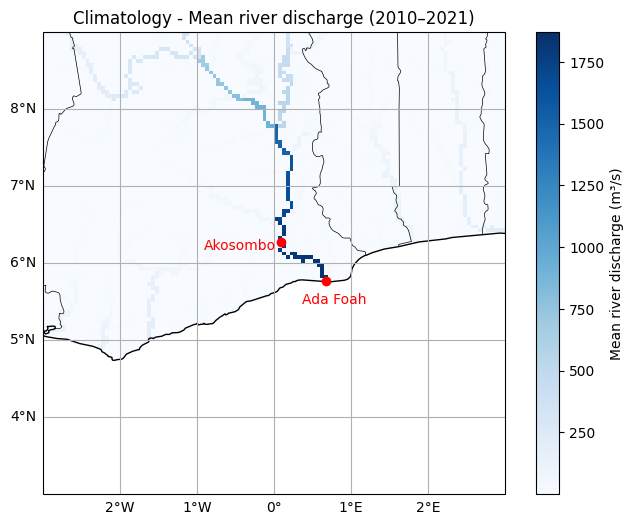

In [174]:
nodata = 9999.0  # GloFAS missing value

# mask nodata first
glofas_masked = glofas_sorted.where(glofas_sorted.dis24 != nodata)

# climatology
glofas_clim = glofas_masked['dis24'].mean('time')

# plot
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('10m'); ax.add_feature(cfeature.BORDERS, linewidth=0.5)

glofas_clim.plot(
    ax=ax, x='longitude', y='latitude',
    transform=ccrs.PlateCarree(), cmap='Blues',
    cbar_kwargs={'label':'Mean river discharge (m³/s)'}
)

# points (be explicit about transform)
ax.plot(lon_estuary, lat_estuary, 'o', color='red', transform=ccrs.PlateCarree())
ax.text(lon_estuary-0.3, lat_estuary-0.3, 'Ada Foah',
        color='red', transform=ccrs.PlateCarree())
ax.plot(lon_lake, lat_lake, 'o', color='red', transform=ccrs.PlateCarree())
ax.text(lon_lake-1, lat_lake-0.1, 'Akosombo',
        color='red', transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.title('Climatology - Mean river discharge (2010–2021)')
plt.show()


### Temporal variability of the 'raw' climatic index

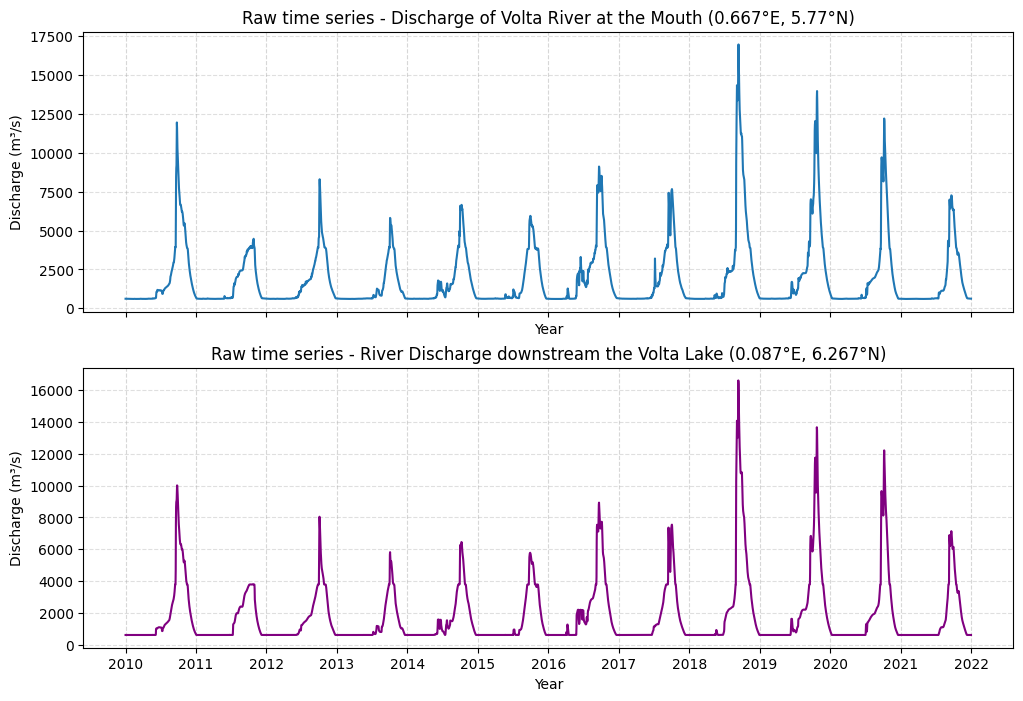

In [175]:
# Timeseries of River Discharge at the two reference points

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# --- Estuary ---
ax1.plot(rd_estuary.time, rd_estuary, linestyle='-')
ax1.set_title("Raw time series - Discharge of Volta River at the Mouth (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")  
ax1.set_xlabel("Year")
ax1.grid(True)
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)

# --- Volta Lake ---
ax2.plot(rd_lake.time, rd_lake, linestyle='-', color='purple')
ax2.set_title("Raw time series - River Discharge downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")  
ax2.set_xlabel("Year")
# vertical lines: one per month
ax2.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)

# one vertical grid line per year
year_loc = mdates.YearLocator()              # every year
year_fmt = mdates.DateFormatter('%Y')

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(year_loc)
    ax.xaxis.set_major_formatter(year_fmt)
    ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)

plt.show()

### Climatology for RD

In [176]:
# -----------------------------
# Daily climatology and anomaly
# -----------------------------

# drop Feb 29 to get a 365-day climatology
is_feb29e = (rd_estuary.time.dt.month == 2) & (rd_estuary.time.dt.day == 29)
rdE_noleap = rd_estuary.sel(time=~is_feb29e)
rdE_noleap = rdE_noleap.convert_calendar("noleap", dim="time", align_on="date")


is_feb29l = (rd_lake.time.dt.month == 2) & (rd_lake.time.dt.day == 29)
rdL_noleap = rd_lake.sel(time=~is_feb29l)
rdL_noleap = rdL_noleap.convert_calendar("noleap", dim="time", align_on="date")

# --- Daily climatology (2010–2021) ---
rdE_dailyclim = rdE_noleap.groupby('time.dayofyear').mean('time')
rdL_dailyclim = rdL_noleap.groupby('time.dayofyear').mean('time')

dates_clim = pd.date_range("2010-01-01", periods=int(rdE_dailyclim.sizes["dayofyear"]), freq="D")
rdE_dailyclim = rdE_dailyclim.assign_coords(date=("dayofyear", dates_clim))
rdL_dailyclim = rdL_dailyclim.assign_coords(date=("dayofyear", dates_clim))

# --- Daily anomalies (value - daily climatology) ---
rdE_dailyanom = rdE_noleap.groupby('time.dayofyear') - rdE_dailyclim
rdE_dailyanom = rdE_dailyanom.assign_coords(date=("time", to_datetime64_from_cftime(rdE_dailyanom["time"])))

rdL_dailyanom = rdL_noleap.groupby('time.dayofyear') - rdL_dailyclim
rdL_dailyanom = rdL_dailyanom.assign_coords(date=("time", to_datetime64_from_cftime(rdL_dailyanom["time"])))

# ---

In [177]:
# -------------------------------
# Monthly climatology and anomaly
# -------------------------------

# Monthly mean values at the two locations (E = estuary, L = lake)
rdE_mon = rd_estuary.resample(time='MS').mean()   # 'MS' = Month Start
rdL_mon = rd_lake.resample(time='MS').mean()

# Monthly climatology (average over all years for each month)
rdE_clim = rdE_mon.groupby('time.month').mean('time')   # dims: month
rdL_clim = rdL_mon.groupby('time.month').mean('time')

# Anomalies = monthly mean - climatology
rdE_anom = rdE_mon.groupby('time.month') - rdE_clim      # dims: time
rdL_anom = rdL_mon.groupby('time.month') - rdL_clim

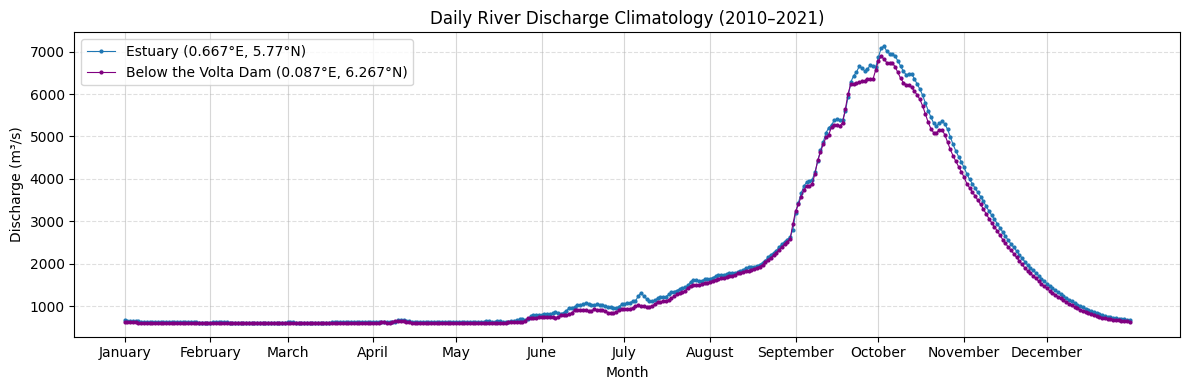

In [178]:
# --------------------------------------
# Daily RD climatology plot 
# --------------------------------------
month_names = [m[:3] for m in calendar.month_name[1:]]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(rdE_dailyclim['date'].values, rdE_dailyclim.values, marker='o', 
        ms=2, lw=0.8, label = 'Estuary (0.667°E, 5.77°N)')
ax.plot(rdL_dailyclim['date'].values, rdL_dailyclim.values, marker = 'o',
        color = 'purple', ms=2, lw=0.8, label ='Below the Volta Dam (0.087°E, 6.267°N)')
ax.set_title("Daily River Discharge Climatology (2010–2021)")
ax.set_ylabel("Discharge (m³/s)")
ax.set_xlabel("Month")
ax.grid(True, axis='x', alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend()

# Tidy monthly ticks
ref_year = int(pd.to_datetime(rdE_dailyclim['date'].values[0]).year)  # or simply 2010
mticks, mlabels = month_ticks_for(ref_year)
ax.set_xticks(mticks)
ax.set_xticklabels(mlabels)
plt.tight_layout()
plt.show()

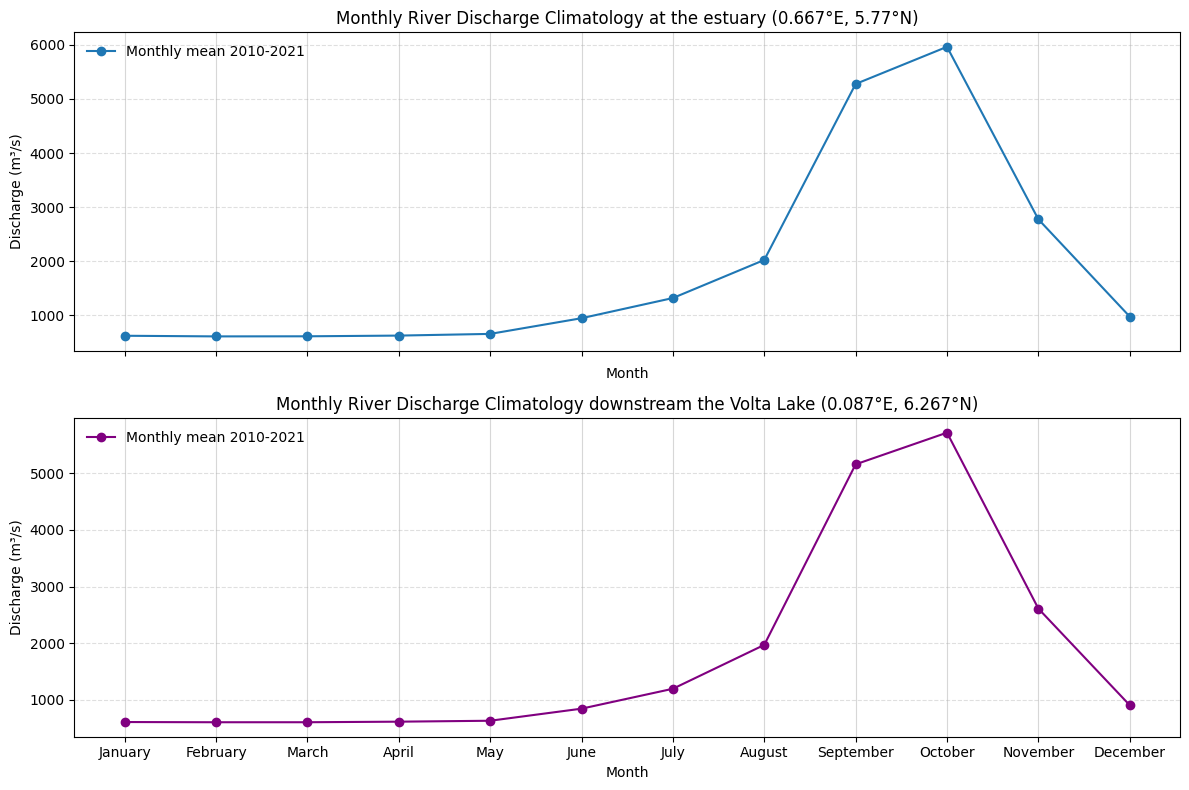

In [179]:
# --------------------------------------
# Monthly RD climatology plot 
# --------------------------------------
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
months = list(calendar.month_name)[1:]

# --- Estuary ---
ax1.plot(rdE_clim['month'].values, rdE_clim.values, marker='o', label = 'Monthly mean 2010-2021')
ax1.set_title("Monthly River Discharge Climatology at the estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month", labelpad=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(loc='upper left', frameon=False)


# --- Volta Lake ---
ax2.plot(rdL_clim['month'].values, rdL_clim.values, color='purple', marker='o', label = 'Monthly mean 2010-2021')
ax2.set_title("Monthly River Discharge Climatology downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month")
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months)
# vertical lines: one per month
ax2.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


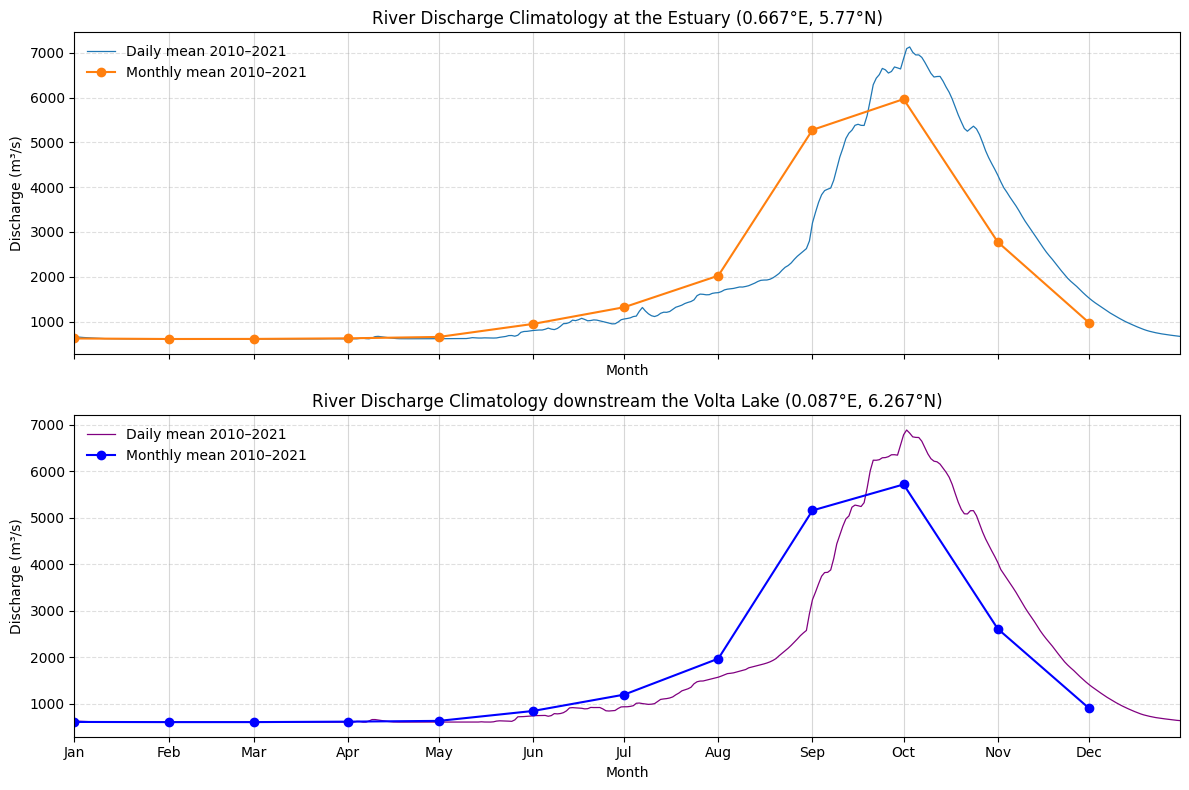

In [180]:

# -----------------------------------------------
# Daily vs Monthly RD climatology 
# -----------------------------------------------

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
# reference year (already non-leap)
year = pd.to_datetime(rdE_dailyclim['date'].values[0]).year
# dates for the monthly (start the month in the same year as daily)
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")

# --- Estuary ---
ax1.plot(rdE_dailyclim['date'].values, rdE_dailyclim.values, lw=0.9, label="Daily mean 2010–2021")
ax1.plot(month_dates, rdE_clim.values, marker='o', label="Monthly mean 2010–2021")

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))

ax1.set_title("River Discharge Climatology at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month")
ax1.grid(True, axis='x', alpha=0.5)
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)
ax1.legend(frameon=False)

# --- Volta Lake ---
ax2.plot(rdL_dailyclim['date'].values, rdL_dailyclim.values, color = 'purple' , lw=0.9, label="Daily mean 2010–2021")
ax2.plot(month_dates, rdL_clim.values, marker='o', color= 'blue',  label="Monthly mean 2010–2021")

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))

ax2.set_title("River Discharge Climatology downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month")
ax2.grid(True, axis='x', alpha=0.5)
ax2.grid(True, axis='y', linestyle='--', alpha=0.4)
ax2.legend(frameon=False)
plt.tight_layout()
plt.show()


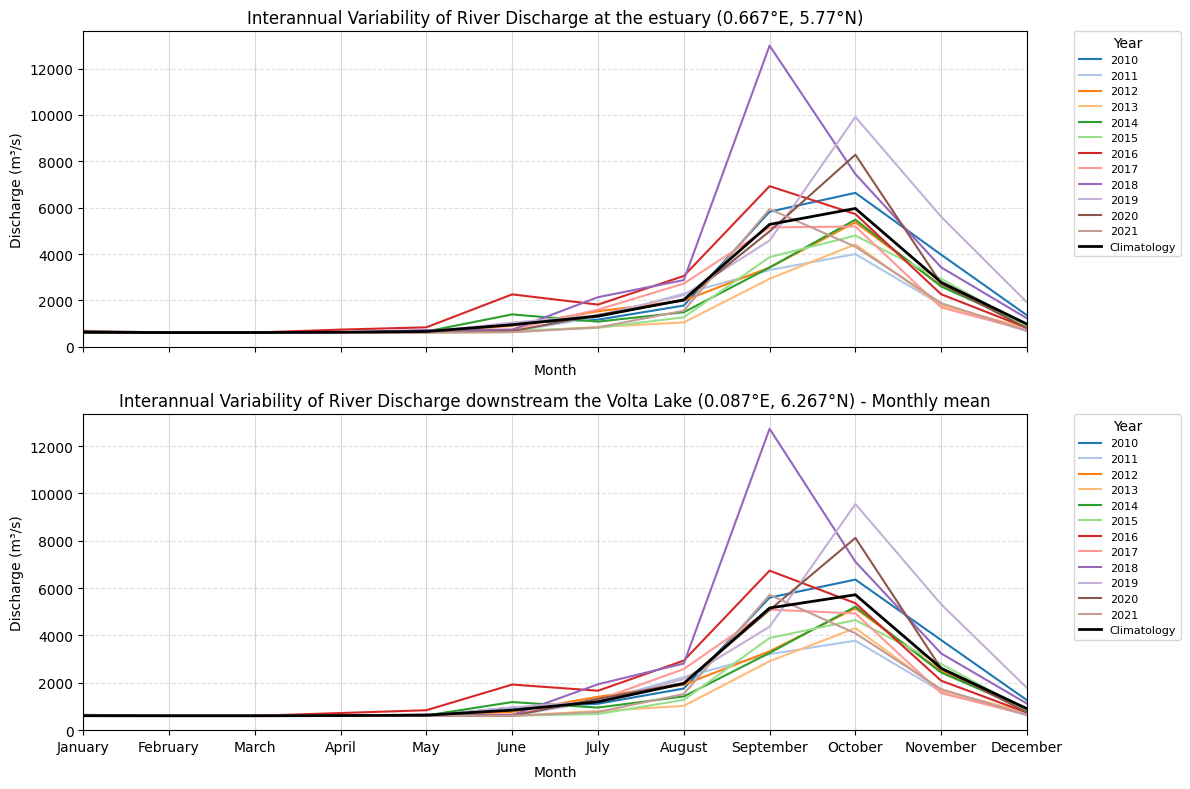

In [181]:
# --------------------------------------
# Monthly mean river discharge
# --------------------------------------
years = sorted(set(rd_estuary['time'].dt.year.values))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
cmap = plt.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(years))]

# --- Estuary ---
for i, (y1, yy1) in enumerate(rdE_mon.groupby('time.year')):
    # yy is the monthly series for that year (up to 12 points)
    ax1.plot(yy1['time.month'].values, yy1.values, label=str(y1), color=colors[i])

ax1.plot(rdE_clim['month'], rdE_clim.values, color='black', label='Climatology', linewidth=2)

ax1.set_title("Interannual Variability of River Discharge at the estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month", labelpad=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.set_xlim(1, 12)
ax1.set_axisbelow(True)
ax1.grid(True, axis='x', which='major', alpha=0.5)             
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8, ncol=1, title="Year")

# --- Volta Lake ---
for j, (y2, yy2) in enumerate(rdL_mon.groupby('time.year')):
    # yy is the monthly series for that year (up to 12 points)
    ax2.plot(yy2['time.month'].values, yy2.values, label=str(y2), color=colors[j])

ax2.plot(rdL_clim['month'], rdL_clim.values, color='black', label='Climatology', linewidth=2)

ax2.set_title("Interannual Variability of River Discharge downstream the Volta Lake (0.087°E, 6.267°N) - Monthly mean")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month", labelpad=8)
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months)
ax2.set_xlim(1, 12)
ax2.set_axisbelow(True)
ax2.grid(True, axis='x', which='major', alpha=0.5)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8, ncol=1, title="Year")

plt.tight_layout()
plt.show()

### Anomaly of RD
#### Anomalies without detrending

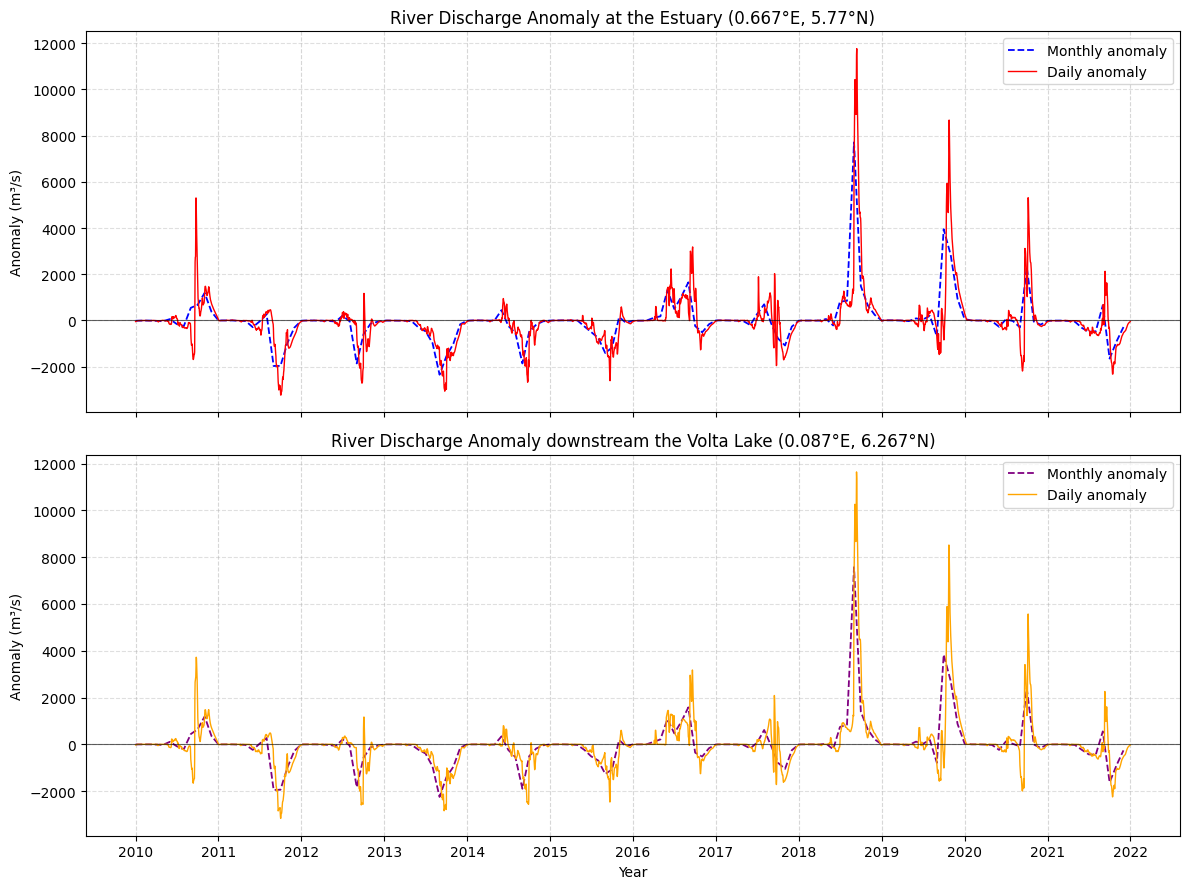

In [182]:
# Unique years + one extra for right edge
years = np.unique(rdE_dailyanom['time.year'].values)
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex=True)

# --- Estuary ---
ax1.plot(rdE_anom['time'], rdE_anom.values, color='b', linewidth=1.3, linestyle = '--', label = 'Monthly anomaly')
ax1.plot(rdE_dailyanom['date'].values, rdE_dailyanom.values, linewidth=1, color= 'r', label = 'Daily anomaly')
ax1.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax1.set_title("River Discharge Anomaly at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Anomaly (m³/s)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

# --- Volta Lake ---
ax2.plot(rdL_anom['time'], rdL_anom.values, color='purple', linewidth=1.3, linestyle = '--', label = 'Monthly anomaly')
ax2.plot(rdL_dailyanom['date'].values, rdL_dailyanom.values, linewidth=1, color= 'orange', label = 'Daily anomaly')
ax2.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax2.set_title("River Discharge Anomaly downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Anomaly (m³/s)")
ax2.set_xlabel("Year")
ax2.set_xticks(year_ticks)
ax2.set_xticklabels(years_ext)
ax2.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()

In [183]:
# Checking on the highest values at Akosombo
val = rdL_dailyclim.where(rdL_dailyclim['date'] == np.datetime64('2010-09-13'), drop=True).squeeze()
val1d = rd_lake.where(rd_lake['time'] == np.datetime64('2018-09-13'), drop=True).squeeze()
val2d = rdL_dailyanom.where(rdL_dailyanom['date'] == np.datetime64('2018-09-13'), drop=True).squeeze()

print('Daily max climatology at Akosombo:', val.values)
print('Daily river discharge max at Akosombo:', val1d.values)
print('Daily max anomaly at Akosombo:', val2d.values)




Daily max climatology at Akosombo: 5039.7935
Daily river discharge max at Akosombo: 16393.531
Daily max anomaly at Akosombo: 11353.738


In [184]:
# Checking on the highest daily and monthly values at the estuary
val = rdE_dailyclim.where(rdE_dailyclim['date'] == np.datetime64('2010-10-03'), drop=True).squeeze()
val1 = rd_estuary.where(rd_estuary['time'] == np.datetime64('2011-10-03'),  drop=True).squeeze()
val2 = rdE_dailyanom.where(rdE_dailyanom['date'] == np.datetime64('2011-10-03'), drop=True).squeeze()

print('Daily climatology at the estuary:', val.values)
print('Daily river discharge at the estuary:', val1.values)
print('Daily anomaly at the estuary:', val2.values)
print('')
valm = rdE_clim.where(rdE_clim['month'] == 9,drop=True).squeeze()
val1m = rdE_mon.where(rdE_mon['time'] == np.datetime64('2018-09-01'), drop=True).squeeze()
val2m = rdE_anom.where(rdE_anom['time'] == np.datetime64('2018-09-01'), drop=True).squeeze()

print('Monthly max climatology at the estuary:', valm.values)
print('Monthly river discharge max at the estuary:', val1m.values)
print('Monthly max anomaly at the estuary:', val2m.values)
print('')

# Checking on the highest daily anomaly value
print('Daily anomaly maximum at the estuary', rdE_dailyanom.max())
print('Happened on the', rdE_dailyanom.idxmax())

# Checking on the lowest daily anomaly value
print('Daily anomaly minimum at the estuary', rdE_dailyanom.min())
print('Happened on the', rdE_dailyanom.idxmin())



Daily climatology at the estuary: 7129.2466
Daily river discharge at the estuary: 3898.3594
Daily anomaly at the estuary: -3230.8872

Monthly max climatology at the estuary: 5277.8867
Monthly river discharge max at the estuary: 12990.454
Monthly max anomaly at the estuary: 7712.5674

Daily anomaly maximum at the estuary <xarray.DataArray 'dis24' ()> Size: 4B
array(11768.285, dtype=float32)
Happened on the <xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(2018, 9, 13, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Daily anomaly minimum at the estuary <xarray.DataArray 'dis24' ()> Size: 4B
array(-3230.8872, dtype=float32)
Happened on the <xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(2011, 10, 3, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)


#### Detrended anomaly
To better understand the variability of a certain climatic index, it is convenient to remove the seasonal cycle from the timeseries by computing the anomaly as the difference between the monthly mean and the long-term monthly mean (the climatology) for each month. In this way we obtain a timesereis of anomaly values that oscillate around the zero (between ...), and that better represent the variability of river discharge in the Keta basin, in Ghana, within the period 2010-2021.

In [185]:
# --------------------------------------
# Detrended climatologies and anomalies
# --------------------------------------
baseline = ('2010-01-01','2021-12-31')

# ---------- ESTUARY ----------
# trend and detrended time series
rdE_danom_from_anomd, rdE_clim_from_anomd, rdE_trend = anomd(rd_estuary, baseline=baseline, deg=1)
rdE_detr = rd_estuary - rdE_trend.interp(time=rd_estuary['time'])

# detrended monthly climatology
rdE_dclim_m = rdE_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')

# detrended daily climatology
is_feb29_E = (rdE_detr.time.dt.month == 2) & (rdE_detr.time.dt.day == 29)
rdE_detr_noleap = rdE_detr.sel(time=~is_feb29_E).convert_calendar("noleap", dim="time", align_on="date")
rdE_dclim_d = rdE_detr_noleap.sel(time=slice(*baseline)).groupby('time.dayofyear').mean('time')

dates_clim = pd.date_range("2010-01-01", periods=int(rdE_dclim_d.sizes["dayofyear"]), freq="D")
rdE_dclim_d = rdE_dclim_d.assign_coords(date=("dayofyear", dates_clim))

# detrended anomalies
rdE_danom_d = rdE_detr_noleap.groupby('time.dayofyear') - rdE_dclim_d
rdE_danom_d = rdE_danom_d.assign_coords(date=("time", to_datetime64_from_cftime(rdE_danom_d["time"])))

rdE_danom_m = rdE_detr.resample(time='MS').mean().groupby('time.month') - rdE_dclim_m

# ---------- VOLTA LAKE ----------
# trend and detrended time series
rdL_danom_from_anomd, rdL_clim_from_anomd, rdL_trend = anomd(rd_lake, baseline=baseline, deg=1)
rdL_detr = rd_lake - rdL_trend.interp(time=rd_lake['time'])

# detrended monthly climatology
rdL_dclim_m = rdL_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')

# detrended daily climatology
is_feb29_L = (rdL_detr.time.dt.month == 2) & (rdL_detr.time.dt.day == 29)
rdL_detr_noleap = rdL_detr.sel(time=~is_feb29_L).convert_calendar("noleap", dim="time", align_on="date")
rdL_dclim_d = rdL_detr_noleap.sel(time=slice(*baseline)).groupby('time.dayofyear').mean('time')

dates_clim = pd.date_range("2010-01-01", periods=int(rdL_dclim_d.sizes["dayofyear"]), freq="D")
rdL_dclim_d = rdL_dclim_d.assign_coords(date=("dayofyear", dates_clim))

# detrended anomalies
rdL_danom_d = rdL_detr_noleap.groupby('time.dayofyear') - rdL_dclim_d
rdL_danom_d = rdL_danom_d.assign_coords(date=("time", to_datetime64_from_cftime(rdL_danom_d["time"])))

rdL_danom_m = rdL_detr.resample(time='MS').mean().groupby('time.month') - rdL_dclim_m


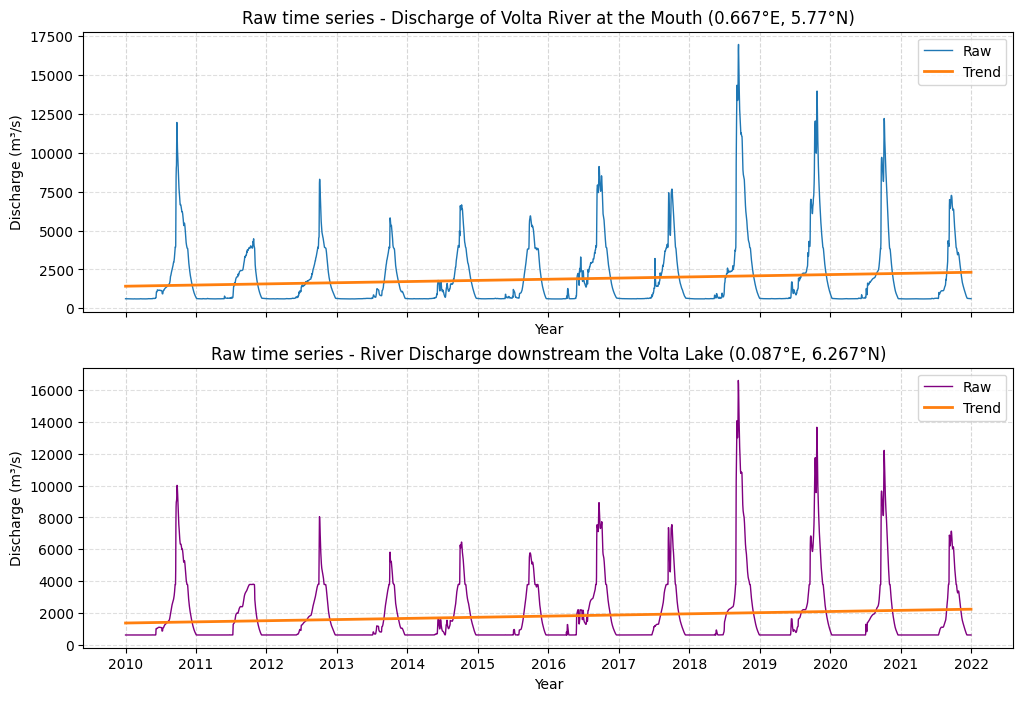

In [186]:
#-----------------------------------------------------------------------
# Timeseries of River Discharge at the two reference points with trend
#-----------------------------------------------------------------------

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# --- Estuary ---
ax1.plot(rd_estuary.time, rd_estuary, linestyle='-', lw = 1, label = 'Raw')
ax1.plot(rdE_trend['time'], rdE_trend, linewidth=2, label="Trend", color="tab:orange")
ax1.set_title("Raw time series - Discharge of Volta River at the Mouth (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")  
ax1.set_xlabel("Year")
ax1.grid(True)
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

# --- Volta Lake ---
ax2.plot(rd_lake.time, rd_lake, linestyle='-', lw = 1, color='purple', label = 'Raw')
ax2.plot(rdL_trend['time'], rdL_trend, linewidth=2, label="Trend", color="tab:orange")
ax2.set_title("Raw time series - River Discharge downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")  
ax2.set_xlabel("Year")
# vertical lines: one per month
ax2.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend()

import matplotlib.dates as mdates

# one vertical grid line per year
year_loc = mdates.YearLocator()              # every year
year_fmt = mdates.DateFormatter('%Y')

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(year_loc)
    ax.xaxis.set_major_formatter(year_fmt)
    ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)

plt.show()

In [187]:
# Investigate trend characteristics
def trend_stats(trend_da, raw_da, baseline):
    tr = trend_da.sel(time=slice(*baseline))
    t = tr['time'].dt.year + (tr['time'].dt.dayofyear - 1)/365.25
    m, c = np.polyfit(t, tr.values, 1)  # m ≈ m³/s per year
    mean_base = float(raw_da.sel(time=slice(*baseline)).mean())
    return {
        "slope_m3s_per_year": float(m),
        "slope_m3s_per_decade": float(m*10),
        "delta_over_baseline_m3s": float(tr.values[-1]-tr.values[0]),
        "percent_per_decade": float(100*(m*10)/mean_base),
        "baseline_mean_m3s": mean_base,
    }

E = trend_stats(rdE_trend, rd_estuary, baseline)
L = trend_stats(rdL_trend, rd_lake, baseline)
print("Estuary:", E)
print("Lake:", L)


Estuary: {'slope_m3s_per_year': 74.80414250735267, 'slope_m3s_per_decade': 748.0414250735266, 'delta_over_baseline_m3s': 897.4322509765625, 'percent_per_decade': 39.982029840084614, 'baseline_mean_m3s': 1870.944091796875}
Lake: {'slope_m3s_per_year': 72.46451901881483, 'slope_m3s_per_decade': 724.6451901881483, 'delta_over_baseline_m3s': 869.363525390625, 'percent_per_decade': 40.46825095416305, 'baseline_mean_m3s': 1790.651123046875}


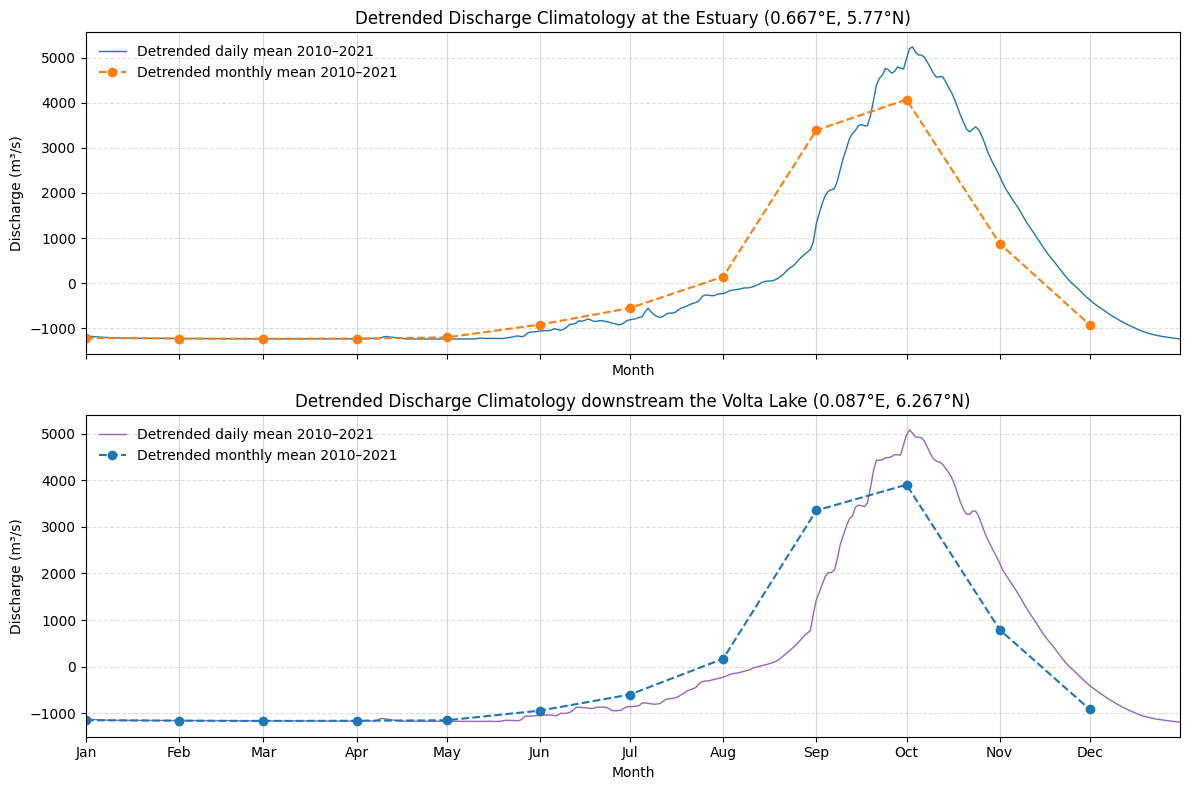

In [188]:
# -----------------------------------------------
# Daily vs Monthly detrended climatology plot
# -----------------------------------------------

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# reference year (already non-leap)
year = pd.to_datetime(rdE_dclim_d['date'].values[0]).year
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")

# --- Estuary (detrended) ---
ax1.plot(rdE_dclim_d['date'].values, rdE_dclim_d.values, lw=1, label="Detrended daily mean 2010–2021")
ax1.plot(month_dates, rdE_dclim_m.values, marker='o', linestyle='--', label="Detrended monthly mean 2010–2021")

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))
ax1.set_title("Detrended Discharge Climatology at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month")
ax1.grid(True, axis='x', alpha=0.5)
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)
ax1.legend(frameon=False)

# --- Volta Lake (detrended) ---
ax2.plot(rdL_dclim_d['date'].values, rdL_dclim_d.values, color='tab:purple', lw=1, label="Detrended daily mean 2010–2021")
ax2.plot(month_dates, rdL_dclim_m.values, marker='o', linestyle='--', color='tab:blue', label="Detrended monthly mean 2010–2021")

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))
ax2.set_title("Detrended Discharge Climatology downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month")
ax2.grid(True, axis='x', alpha=0.5)
ax2.grid(True, axis='y', linestyle='--', alpha=0.4)
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()


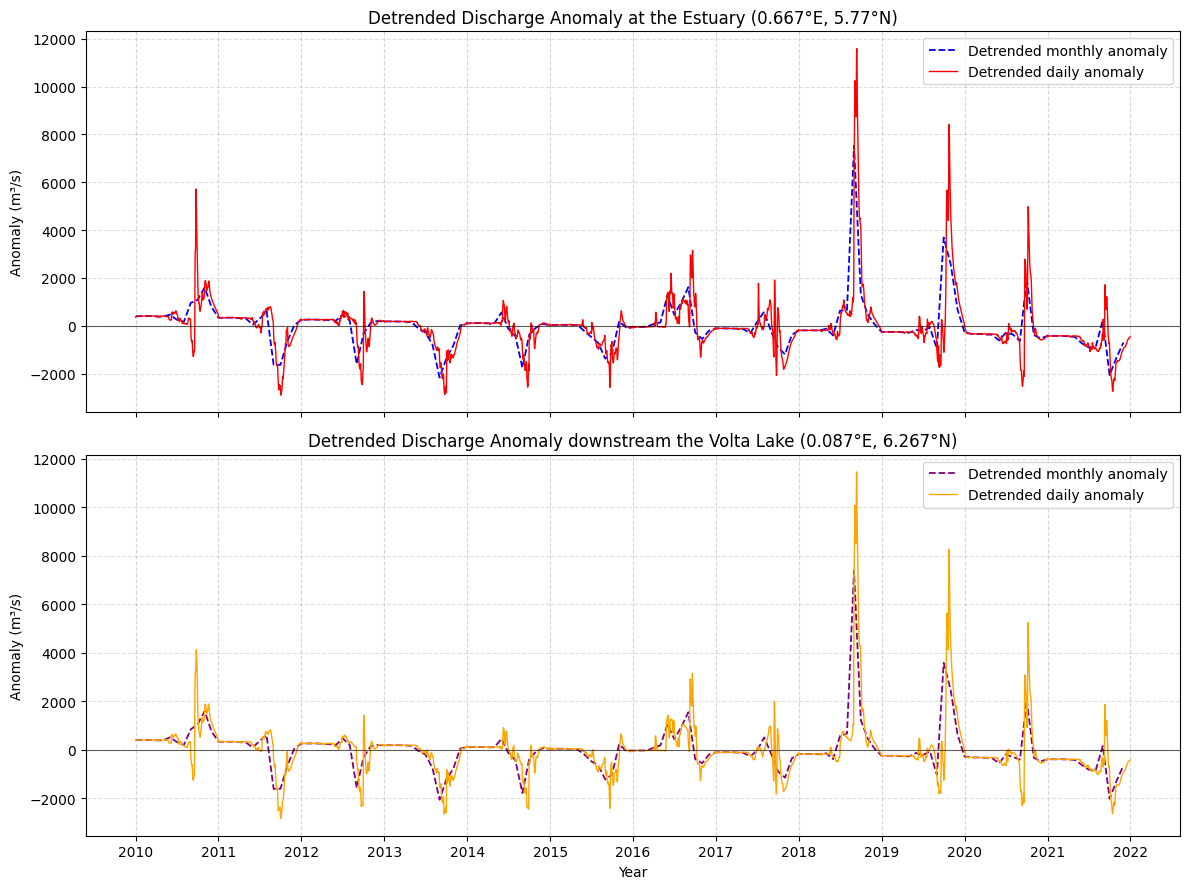

In [189]:
# --------------------------------------
# Daily vs Monthly detrended anomalies 
# --------------------------------------
# Unique years + one extra for right edge
years = np.unique(rdE_danom_d['time.year'].values)
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex=True)

# --- Estuary ---
ax1.plot(rdE_danom_m['time'], rdE_danom_m.values, color='b', linewidth=1.3, linestyle = '--', label = 'Detrended monthly anomaly')
ax1.plot(rdE_danom_d['date'].values, rdE_danom_d.values, linewidth=1, color= 'r', label = 'Detrended daily anomaly')
ax1.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax1.set_title("Detrended Discharge Anomaly at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Anomaly (m³/s)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

# --- Volta Lake ---
ax2.plot(rdL_danom_m['time'], rdL_danom_m.values, color='purple', linewidth=1.3, linestyle = '--', label = 'Detrended monthly anomaly')
ax2.plot(rdL_danom_d['date'].values, rdL_danom_d.values, linewidth=1, color= 'orange', label = 'Detrended daily anomaly')
ax2.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax2.set_title("Detrended Discharge Anomaly downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Anomaly (m³/s)")
ax2.set_xlabel("Year")
ax2.set_xticks(year_ticks)
ax2.set_xticklabels(years_ext)
ax2.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()


## Water level - JRC data
### Temporal variability of the 'raw' climatic index

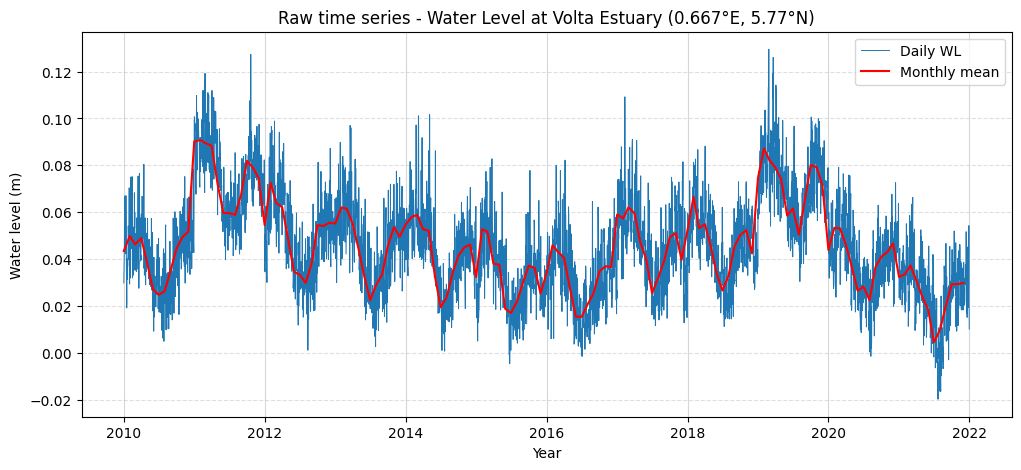

In [190]:
# Timeseries of Water Level

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)
ax1.plot(wl_estuary.time, wl_estuary, linestyle='-', lw=0.7, label = 'Daily WL')
# Monthly mean values at the two locations (E = estuary, L = lake)
wl_mon = wl_estuary.resample(time='MS').mean()   # 'MS' = Month Start

ax1.plot(wl_mon.time, wl_mon, linestyle = '-', color = 'r', label = 'Monthly mean')
ax1.set_title("Raw time series - Water Level at Volta Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Water level (m)")  
ax1.set_xlabel("Year")
ax1.grid(True)
ax1.legend()
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)

#plt.tight_layout()
plt.show()

### Climatology for WL

In [191]:
# -----------------------------
# Daily climatology and anomaly
# -----------------------------

# drop Feb 29 to get a 365-day climatology
is_feb29w = (wl_estuary.time.dt.month == 2) & (wl_estuary.time.dt.day == 29)
wl_noleap = wl_estuary.sel(time=~is_feb29w)
wl_noleap = wl_noleap.convert_calendar("noleap", dim="time", align_on="date")

# --- Daily climatology (2010–2021) ---
wl_dailyclim = wl_noleap.groupby('time.dayofyear').mean('time')

dates_climw = pd.date_range("2010-01-01", periods=int(wl_dailyclim.sizes["dayofyear"]), freq="D")
wl_dailyclim = wl_dailyclim.assign_coords(date=("dayofyear", dates_climw))

wl_dailyanom = wl_noleap.groupby('time.dayofyear') - wl_dailyclim
wl_dailyanom = wl_dailyanom.assign_coords(date=("time", to_datetime64_from_cftime(wl_dailyanom["time"])))

# -------------------------------
# Monthly climatology and anomaly
# -------------------------------

# Monthly mean values at the two locations (E = estuary, L = lake)
wl_mon = wl_estuary.resample(time='MS').mean()   # 'MS' = Month Start

# Monthly climatology (average over all years for each month)
wl_clim = wl_mon.groupby('time.month').mean('time')   # dims: month

# Anomalies = monthly mean - climatology
wl_anom = wl_mon.groupby('time.month') - wl_clim       # dims: time

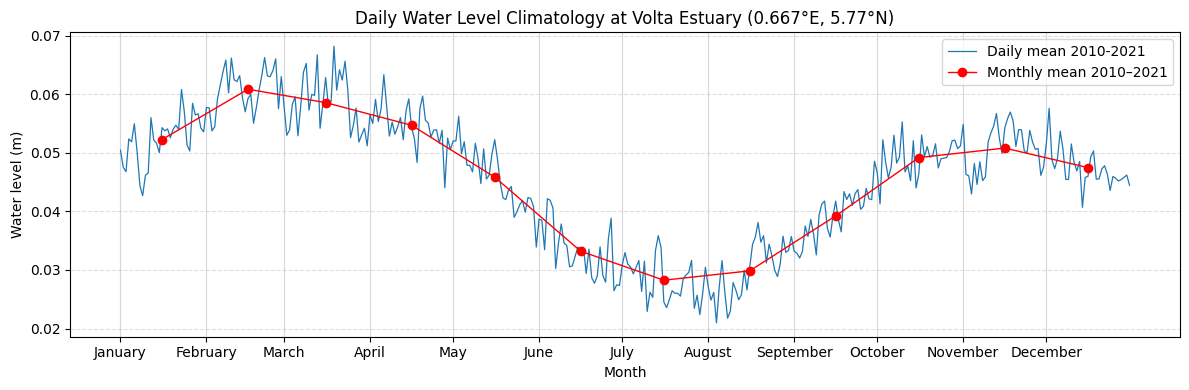

In [192]:
# Plots
months = list(calendar.month_name)[1:]
# reference year (already non-leap)
year = pd.to_datetime(wl_dailyclim['date'].values[0]).year
# dates for the monthly (start the month in the same year as daily)
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")
month_dates_mid = month_dates + pd.Timedelta(days=15)

# --------------------------------------
# Daily and monthly climatology plot WL
# --------------------------------------
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(wl_dailyclim['date'].values, wl_dailyclim.values,  
        ms=2, lw=0.9, label = 'Daily mean 2010-2021')
ax.plot(month_dates_mid, wl_clim.values, marker='o', lw=1, color ='r',
        label='Monthly mean 2010–2021')
ax.set_title("Daily Water Level Climatology at Volta Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Water level (m)")
ax.set_xlabel("Month")
ax.grid(True, axis='x', alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend()

month = pd.date_range('2010-01-01', '2011-01-01', freq='MS')[:-1]
ax.set_xticks(month)
ax.set_xticklabels(months)
ax.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

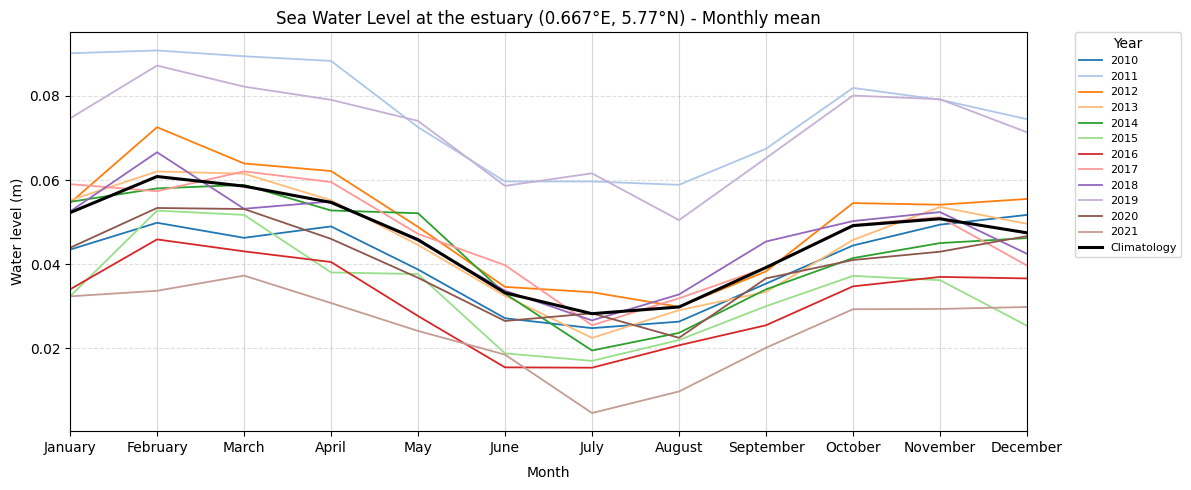

In [193]:
years = sorted(set(rd_estuary['time'].dt.year.values))

# --------------------------------------
# Monthly mean water level
# --------------------------------------

fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)
cmap = plt.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(years))]

for i, (y1, yy1) in enumerate(wl_mon.groupby('time.year')):
    # yy is the monthly series for that year (up to 12 points)
    ax1.plot(yy1['time.month'].values, yy1.values, label=str(y1), lw=1.3, color=colors[i])

ax1.plot(wl_clim['month'], wl_clim.values, color='black', label='Climatology', linewidth=2.2)
ax1.set_title("Sea Water Level at the estuary (0.667°E, 5.77°N) - Monthly mean")
ax1.set_ylabel("Water level (m)")
ax1.set_xlabel("Month", labelpad=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.set_xlim(1, 12)
ax1.set_axisbelow(True)
ax1.grid(True, axis='x', which='major', alpha=0.5)             
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8, ncol=1, title="Year")

plt.tight_layout()
plt.show()

### WL anomaly
#### Anomalies without detrending

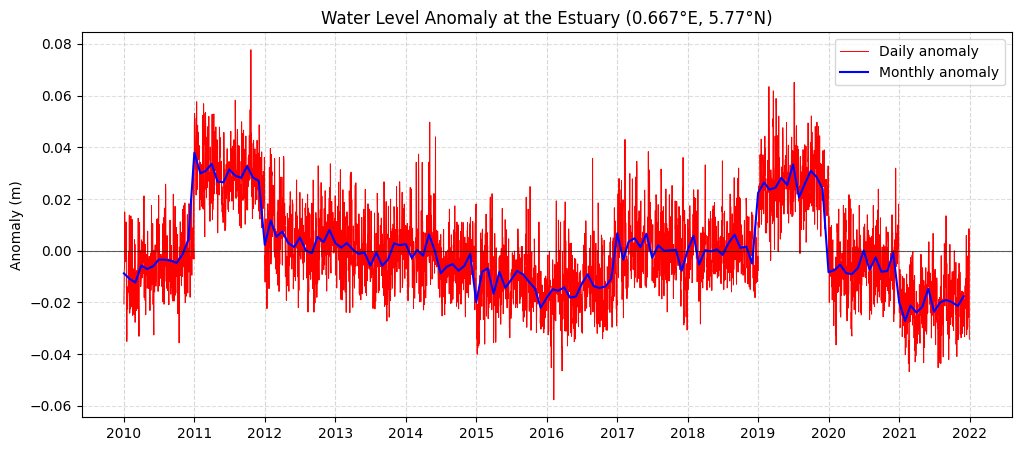

In [194]:
# get unique years from anomalies
years = np.unique(wl_anom['time.year'].values)

# add one extra year so the grid reaches the end of the plot
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

# --------------------------------------
# Monthly and daily water level anomaly
# --------------------------------------

fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)

# --- Estuary ---
ax1.plot(wl_dailyanom['date'].values, wl_dailyanom.values, linewidth=0.7, color= 'r', label = 'Daily anomaly')
ax1.plot(wl_anom['time'], wl_anom.values, color='blue', linewidth=1.5, label = 'Monthly anomaly')
ax1.axhline(0, color='k', linewidth=0.8, alpha=0.6)  # baseline
ax1.set_title("Water Level Anomaly at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Anomaly (m)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)  # show all year numbers including the last
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

plt.show()


#### Detrended anomaly
To better understand the variability of a certain climatic index, it is convenient to remove the seasonal cycle from the timeseries by computing the anomaly as the difference between the monthly mean and the long-term monthly mean (the climatology) for each month. In this way we obtain a timesereis of anomaly values that oscillate around the zero (between ...), and that better represent the variability of river discharge in the Keta basin, in Ghana, within the period 2010-2021.

In [195]:
# --------------------------------------
# Detrended climatologies and anomalies
# --------------------------------------
baseline = ('2010-01-01','2021-12-31')

# trend and detrended time series
wl_danom_from_anomd, wl_clim_from_anomd, wl_trend = anomd(wl_estuary, baseline=baseline, deg=1)
wl_detr = wl_estuary - wl_trend.interp(time=wl_estuary['time'])

# detrended monthly climatology
wl_dclim_m = wl_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')

# detrended daily climatology
is_feb29_w = (wl_detr.time.dt.month == 2) & (wl_detr.time.dt.day == 29)
wl_detr_noleap = wl_detr.sel(time=~is_feb29_w).convert_calendar("noleap", dim="time", align_on="date")
wl_dclim_d = wl_detr_noleap.sel(time=slice(*baseline)).groupby('time.dayofyear').mean('time')

dates_climw = pd.date_range("2010-01-01", periods=int(wl_dclim_d.sizes["dayofyear"]), freq="D")
wl_dclim_d = wl_dclim_d.assign_coords(date=("dayofyear", dates_climw))

# detrended anomalies
wl_danom_d = wl_detr_noleap.groupby('time.dayofyear') - wl_dclim_d
wl_danom_d = wl_danom_d.assign_coords(date=("time", to_datetime64_from_cftime(wl_danom_d["time"])))

wl_danom_m = wl_detr.resample(time='MS').mean().groupby('time.month') - wl_dclim_m

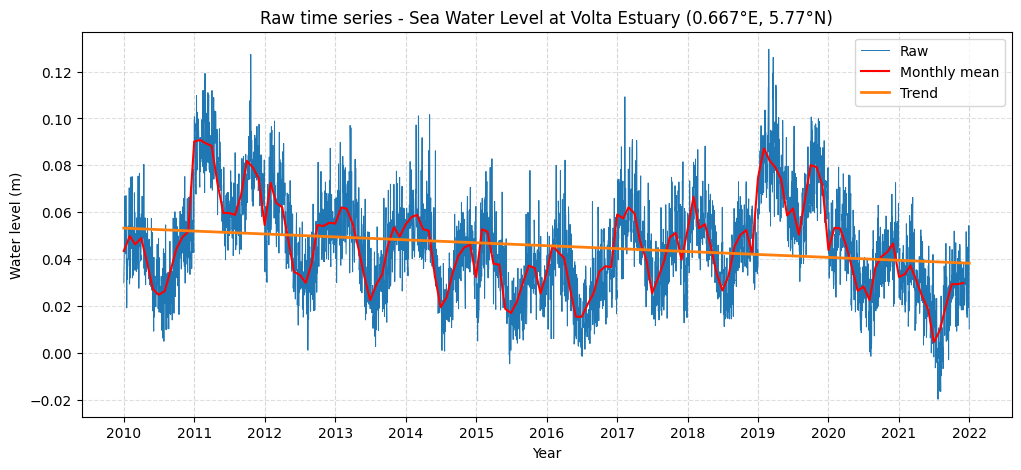

In [196]:
#--------------------------------------
# Timeseries of Water Level with trend
#--------------------------------------
# Plot
fig, ax = plt.subplots(figsize=(12, 5), sharex=True)
ax.plot(wl_estuary.time, wl_estuary, linestyle='-', lw = 0.7, label = 'Raw')
ax.plot(wl_mon.time, wl_mon, linestyle = '-', color = 'r', label = 'Monthly mean')
ax.plot(wl_trend['time'], wl_trend, linewidth=2, label="Trend", color="tab:orange")
ax.set_title("Raw time series - Sea Water Level at Volta Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Water level (m)")  
ax.set_xlabel("Year")
ax.grid(True)
# vertical lines: one per month
ax.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax.legend()

# one vertical grid line per year
year_loc = mdates.YearLocator()              # every year
year_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(year_loc)
ax.xaxis.set_major_formatter(year_fmt)
ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)

plt.show()

In [197]:
wl_danom_d

<xarray.DataArray (time: 4380)> Size: 35kB
array([-0.02740397, -0.01845397, -0.01422897, ...,  0.01535482,
       -0.01613684, -0.02739518], shape=(4380,))
Coordinates:
  * time       (time) object 35kB 2010-01-01 00:00:00 ... 2021-12-31 00:00:00
    dayofyear  (time) int64 35kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    date       (time) datetime64[ns] 35kB 2010-01-01 2010-01-02 ... 2021-12-31

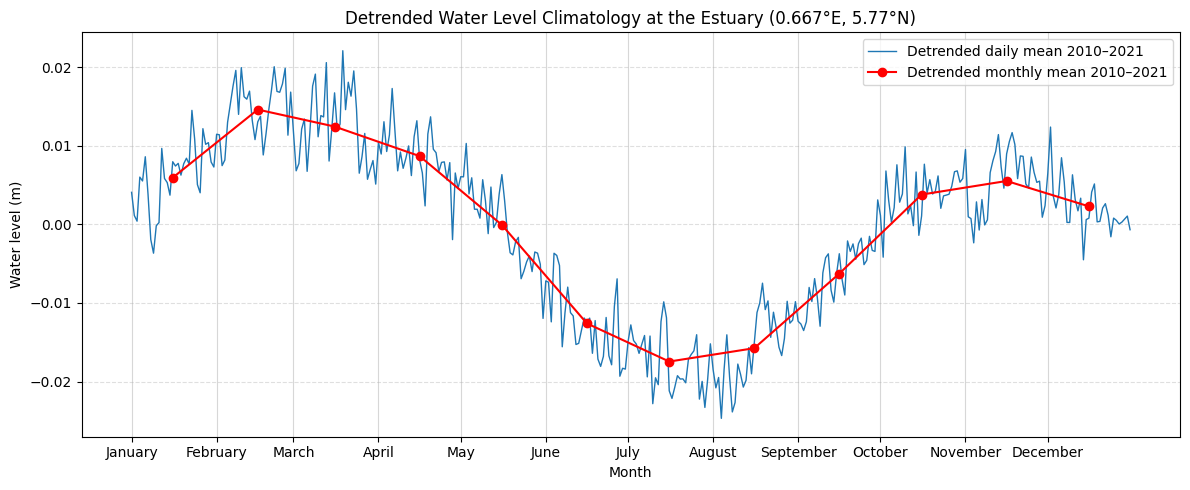

In [198]:
# -----------------------------------------------
# Daily vs Monthly detrended climatology plot
# -----------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5), sharex=True)

# reference year (already non-leap)
year = pd.to_datetime(wl_dclim_d['date'].values[0]).year
# dates for the monthly (start the month in the same year as daily)
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")
month_dates_mid = month_dates + pd.Timedelta(days=15)

ax.plot(wl_dclim_d['date'].values, wl_dclim_d.values, lw=1, label="Detrended daily mean 2010–2021")
ax.plot(month_dates_mid, wl_dclim_m.values, marker='o', color= 'r', label="Detrended monthly mean 2010–2021")
ax.set_title("Detrended Water Level Climatology at the Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Water level (m)")
ax.set_xlabel("Month")
month = pd.date_range('2010-01-01', '2011-01-01', freq='MS')[:-1]
ax.set_xticks(month)
ax.set_xticklabels(months)
ax.grid(True, axis='x', alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()


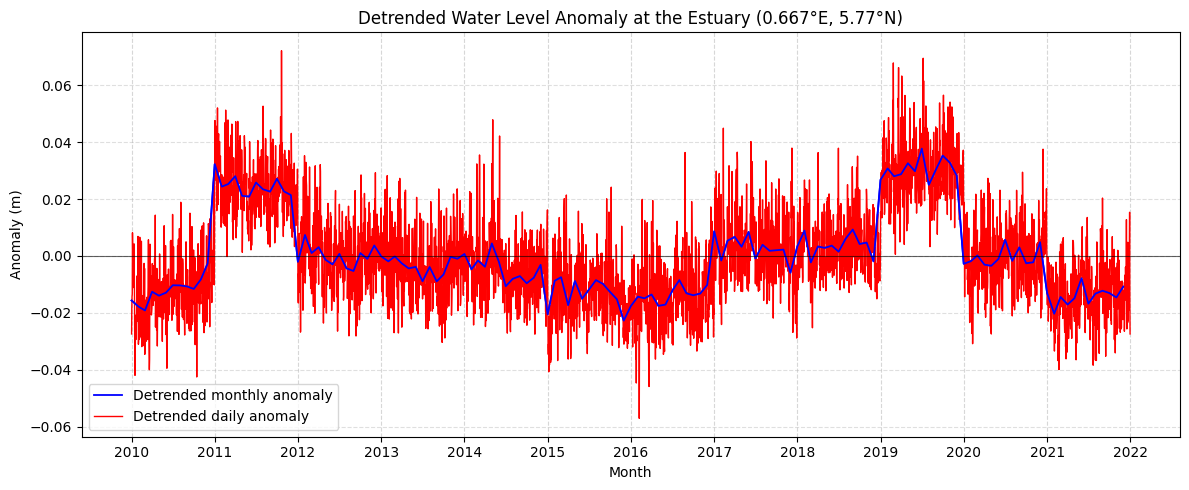

In [199]:
# ----------------------------------------
# Daily vs Monthly detrended anomaly plot 
# ----------------------------------------
# Unique years + one extra for right edge
years = np.unique(wl_danom_d['time.year'].values)
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

fig, ax = plt.subplots(figsize=(12, 5), sharex=True)

ax.plot(wl_danom_m['time'].values, wl_danom_m.values, lw=1.3, color = 'b', label="Detrended monthly anomaly")
ax.plot(wl_danom_d['time'].values, wl_danom_d.values, lw = 1, color = 'r', label="Detrended daily anomaly")
ax.plot(wl_danom_m['time'].values, wl_danom_m.values, lw=1.3, color = 'b')
ax.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax.set_title("Detrended Water Level Anomaly at the Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Anomaly (m)")
ax.set_xlabel("Month")
ax.set_xticks(year_ticks)
ax.set_xticklabels(years_ext)
ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()


## Align series and detrended anomalies

In [200]:
# --- INPUTS ---
START = "2010-01-01"
END   = "2021-12-31"
SEASON_MONTHS = None            # e.g. [8,9,10,11] for Aug–Nov, or None for all-year
# --------------

def align_RD_WL(rd_estuary, wl_estuary, start=START, end=END, season_months=SEASON_MONTHS):
    """
    Align daily discharge (RD) and water level (WL) on the same dates.
    - Coerce to pandas Series with clean DatetimeIndex (normalized to midnight)
    - Clip each to [start,end] individually
    - Inner-join (keep overlapping dates only)
    - Optional seasonal filter
    Returns a DataFrame with columns ['RD','WL'].
    """
    # 1) to Series and ensure datetime, no tz
    rd = rd_estuary.to_series()  # pandas Series with DatetimeIndex
    wl = wl_estuary.to_series()

    # keep overlap and target period
    alignedQW = pd.concat({"RD": rd, "WL": wl}, axis=1).sort_index()
    alignedQW = alignedQW.loc[start:end].dropna()

    # enforce daily frequency (your data are daily; this just checks & warns)
    daily = pd.date_range(alignedQW.index.min(), alignedQW.index.max(), freq="D")
    if not alignedQW.index.equals(daily.intersection(alignedQW.index)):
        # don't reindex to avoid creating NaNs; just warn if irregular
        print("Note: index not strictly regular daily; proceeding with available days.")

    # optional seasonal filter
    if season_months is not None:
        alignedQW = alignedQW[alignedQW.index.month.isin(season_months)]

    # final sanity
    assert alignedQW.index.is_monotonic_increasing
    print(f"Aligned rows: {len(alignedQW)}  | years: {alignedQW.index.year.nunique()} | "
          f"period: {alignedQW.index.min().date()} → {alignedQW.index.max().date()}")
    if season_months:
        print(f"Filtered months: {season_months}")

    return alignedQW

alignedQW = align_RD_WL(rd_estuary, wl_estuary, START, END, SEASON_MONTHS)
alignedQW.head()


Aligned rows: 4383  | years: 12 | period: 2010-01-01 → 2021-12-31


RD      WL
time                          
2010-01-01  616.109375  0.0299
2010-01-02  615.671875  0.0359
2010-01-03  615.140625  0.0394
2010-01-04  614.531250  0.0459
2010-01-05  613.953125  0.0669

In [201]:
def align_RD_WL_det_anom(rdE_danom_d, wl_danom_d,
                         start="2010-01-01", end="2021-12-31",
                         season_months=None):
    """
    Align daily discharge (RDda) and water level (WLda) detrended anomalies on the same dates.
    Returns a DataFrame with columns ['RDda','WLda'].
    """
    # to pandas Series
    rd_da = rdE_danom_d.to_series()
    wl_da = wl_danom_d.to_series()

    # ensure pandas DatetimeIndex (no cftime)
    if not isinstance(rd_da.index, pd.DatetimeIndex):
        rd_da.index = pd.to_datetime(rd_da.index.to_datetimeindex())
    if not isinstance(wl_da.index, pd.DatetimeIndex):
        wl_da.index = pd.to_datetime(wl_da.index.to_datetimeindex())

    # clip to period and inner-join
    df = pd.concat({"RDda": rd_da, "WLda": wl_da}, axis=1).sort_index()
    df = df.loc[start:end].dropna()

    # check daily regularity (warn only)
    daily = pd.date_range(df.index.min(), df.index.max(), freq="D")
    if not df.index.equals(daily.intersection(df.index)):
        print("Note: index not strictly regular daily; proceeding with available days.")

    # optional seasonal filter
    if season_months is not None:
        df = df[df.index.month.isin(season_months)]

    print(f"Aligned rows: {len(df)}  | years: {df.index.year.nunique()} | "
          f"period: {df.index.min().date()} → {df.index.max().date()}")
    if season_months:
        print(f"Filtered months: {season_months}")

    return df
alignedQW_da = align_RD_WL_det_anom(rdE_danom_d, wl_danom_d, START, END, SEASON_MONTHS)
alignedQW_da.head()


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\4021829564.py:14: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  rd_da.index = pd.to_datetime(rd_da.index.to_datetimeindex())
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\4021829564.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  rd_da.index = pd.to_datetime(rd_da.index.to_datetimeindex())
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\4021829564.py:16: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex

Aligned rows: 4380  | years: 12 | period: 2010-01-01 → 2021-12-31


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\4021829564.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  wl_da.index = pd.to_datetime(wl_da.index.to_datetimeindex())


RDda      WLda
2010-01-01  366.388123 -0.027404
2010-01-02  372.095774 -0.018454
2010-01-03  377.451843 -0.014229
2010-01-04  382.295695 -0.013329
2010-01-05  386.188222  0.008163

In [202]:
print(alignedQW)

                    RD      WL
time                          
2010-01-01  616.109375  0.0299
2010-01-02  615.671875  0.0359
2010-01-03  615.140625  0.0394
2010-01-04  614.531250  0.0459
2010-01-05  613.953125  0.0669
...                ...     ...
2021-12-27  622.625000  0.0194
2021-12-28  621.843750  0.0426
2021-12-29  621.046875  0.0543
2021-12-30  620.281250  0.0232
2021-12-31  619.734375  0.0102

[4383 rows x 2 columns]


In [203]:
# Export the raw data to compute the Extreme Value Analysis in R, by applying the adaptation of the Matalb tsEVA toolbox developed by Lorenzo Mentaschi.
# River Discharge 
alignedQW[['RD']].rename(columns={'RD':'series'})\
         .to_csv(r"C:\Users\aless\Desktop\tesi\SoC_master_thesis_git\script\keta_RD_daily.csv", index_label="time")

# Water Level
alignedQW[['WL']].rename(columns={'WL':'series'})\
         .to_csv(r"C:\Users\aless\Desktop\tesi\SoC_master_thesis_git\script\keta_WL_daily.csv", index_label="time")

# Extreme Analysis
## Univariate Extremes

### Block Maxima - Empirical return periods
Following the Block Maxima approach (Coles, 2001), the observation record is here divided into non-overlapping periods of equal length and restricts attention to the maximum observation in each block. The resulting series of annual maxima is then fitted with the GEV distribution, allowing the estimation for return levels, defined as quantiles corresponding to specidic return periods. In this way, observed extremes are associated with probabilities, and extrapolation beyond the observed record becomes possible. It should be said, however, that while GEV distribution provides the theoretical foundation for modeling block maxima, its derivation assumes underlying stationarity. Coles (2001, §6) emphasizes that environmental processes rarely satisfy this assumption due to seasonal cycles and long-term trends. In fact, non-stationary time series are characterized by statistical properties that vary in time due to changes in the dynamic system (Mentaschi et al., 2016). As pointed out by Coles (2001), a general theory about non-stationary extreme value analysis (EVA) has not been formulated. Instead, different methodologies has been developed to analyze the extreme values in series that do not respect the statioarity assumption: from the expression of extreme value distribution parameters as time-varying parametric functions to model extremes of the non-stationary series, to the "stationary on slice" method, which divides those series into quasi-stationary and apply the stationary theory to each slice. In this study, the method used is the one proposed by Mentaschi et al. (2016): the transformed-stationary (TS) extreme value methodology. This approach consists of (i) transforming a non-stationary time series into a stationary series, (ii) performing a stationary EVA, and (iii) reverse transforming the resulting extreme value distribution into a time-dependent one.

In practice, the data here are divided into annual blocks, from which only the **annual maximum** value is considered, creating a shorter series of 12 values for 2010-2021 (1). The **GEV distribution is then fitted to these annual maxima** (2), with shape, location and scale parameters estimated through maxima likelihood estimation (MLE). Then, the return periods are computed as the reciprocal of exceedance probability, T = 1/p. The corresponding return level (3) q = 1 - 1/T is the quantile of the fitted GEV distribution that is exceeded with probability 1/T in any given year (Coles, 2001, §3.2).

In the code, once the GEV parameters are estimated, each observed annual maximum is assigned to an empirical return period using the Weibull plotting position (4): Temp = (n+1)/m, where n is the number of annual maxima and m is the rank of the maximum (from the largest = 1, to the smallest = n). At the same time, the fitted GEV is used to compute the theoretical return level curve across a smooth grid of return periods up to a safe maximum (≈3× record length).

Lastly, the comparison of the empirical estimates from data (points) with the fitted model (curve) is here paralelly proposed for both the raw time series and the detrended anomalies.

In [204]:
import lmoments3 as lm
from lmoments3 import distr as lmd
import scipy.stats as st

print("OK:", lm.__version__)


OK: 1.0.8


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\2970725188.py:4: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return series.resample("A-DEC").max().dropna()
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\2970725188.py:4: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return series.resample("A-DEC").max().dropna()


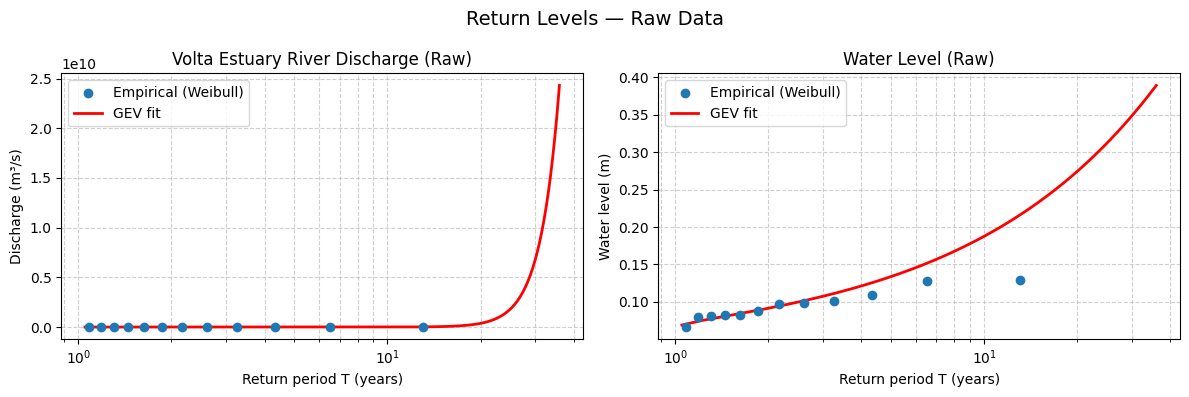

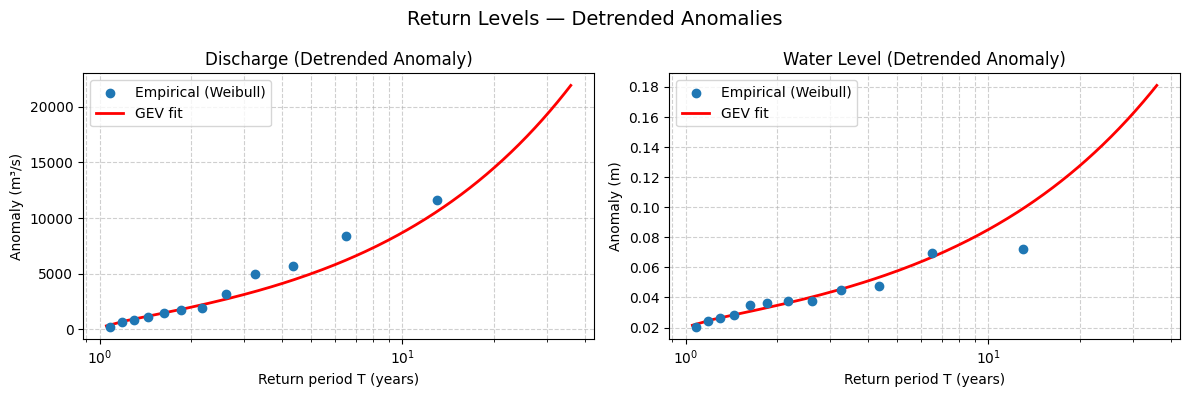

In [205]:
# 1) Take annual maxima from the daily series
def annual_max(series):
    """Return annual maxima (one value per year)."""
    return series.resample("A-DEC").max().dropna()

# 2) Fit a GEV distribution to those maxima, parameters estimated by MLE
def fit_gev(am_series):
    """Fit GEV distribution to annual maxima."""
    shape, loc, scale = st.genextreme.fit(am_series.values)
    return shape, loc, scale

# 3) Compute return levels for a range of return periods T
def return_level_curve(shape, loc, scale, T):
    """Compute return levels for given return periods T."""
    q = 1 - 1/np.array(T)
    return st.genextreme.ppf(q, shape, loc=loc, scale=scale)

# 4) Plot empirical points (from Weibull plotting position) + fitted GEV curve.
def ax_return_levels(ax, am_series, title, ylabel, factor=3):
    """
    Plot a return level curve on a given matplotlib axis (ax).
    - factor: maximum multiple of record length for Tmax (to avoid extreme extrapolation)
    """
    n = len(am_series)           # number of annual maxima
    Tmax = n * factor            # maximum return period allowed
    shape, loc, scale = fit_gev(am_series)

    # Empirical return periods (Weibull plotting position)
    x = np.sort(am_series.values)[::-1]
    m = np.arange(1, n+1)
    T_emp = (n+1) / m

    # Theoretical GEV return level curve (limited to Tmax)
    T_theo = np.linspace(1.05, Tmax, 200)
    RL_theo = return_level_curve(shape, loc, scale, T_theo)

    # Plot empirical points and fitted GEV curve
    ax.scatter(T_emp, x, label="Empirical (Weibull)", zorder=3)
    ax.plot(T_theo, RL_theo, "r-", lw=2, label="GEV fit")

    # Axis formatting
    ax.set_xscale("log")
    ax.set_xlabel("Return period T (years)")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

# Compute annual maxima for each series
AM_RD   = annual_max(alignedQW["RD"])        # raw discharge
AM_WL   = annual_max(alignedQW["WL"])        # raw water level
AM_RDda = annual_max(alignedQW_da["RDda"])   # detrended anomaly discharge
AM_WLda = annual_max(alignedQW_da["WLda"])   # detrended anomaly water level

# Figure 1: Raw data (2 columns: discharge + water level)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax_return_levels(axes[0], AM_RD, "Volta Estuary River Discharge (Raw)", "Discharge (m³/s)")
ax_return_levels(axes[1], AM_WL, "Water Level (Raw)", "Water level (m)")
fig.suptitle("Return Levels — Raw Data", fontsize=14)
plt.tight_layout()
plt.show()

# Figure 2: Detrended anomalies (2 columns: discharge + water level)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax_return_levels(axes[0], AM_RDda, "Discharge (Detrended Anomaly)", "Anomaly (m³/s)")
ax_return_levels(axes[1], AM_WLda, "Water Level (Detrended Anomaly)", "Anomaly (m)")
fig.suptitle("Return Levels — Detrended Anomalies", fontsize=14)
plt.tight_layout()
plt.show()


Given the very short block maxima series, with only 12 years of data, the Maximum Likelihood Estimation method to estiamte the GEV parameters is very unstable. This is evident in the Volta Estuary River dicharge Return Levels for raw data: here the GEV curve explodes upwards very fast, wich is an unrealistic extrapolation.

Therefore, for short records such as this one, it is convinent to use Probability Weighted Moments (or L-moments), which is a much more robust method with short hydrological recors, and which produces more stable and realistic return levels.

C:\Users\aless\AppData\Local\Temp\ipykernel_32364\1099927706.py:7: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return series.resample("A-DEC").max().dropna()


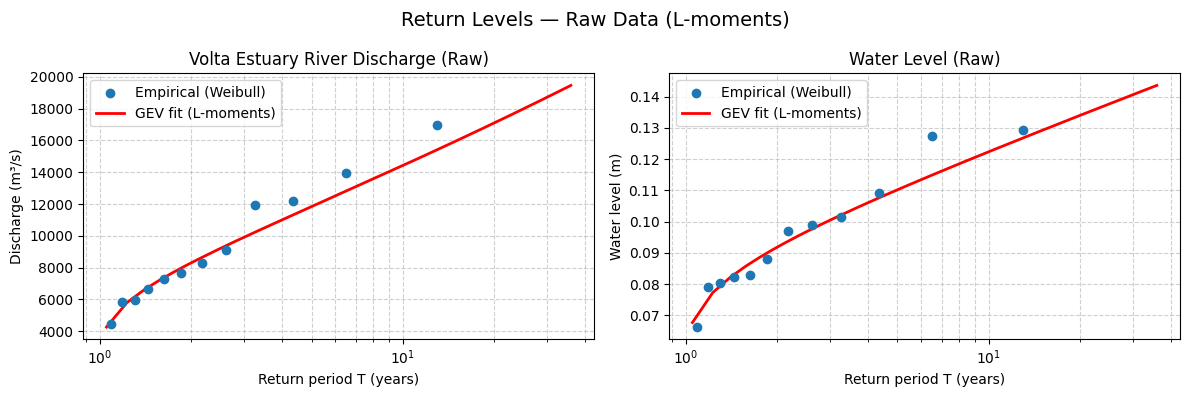

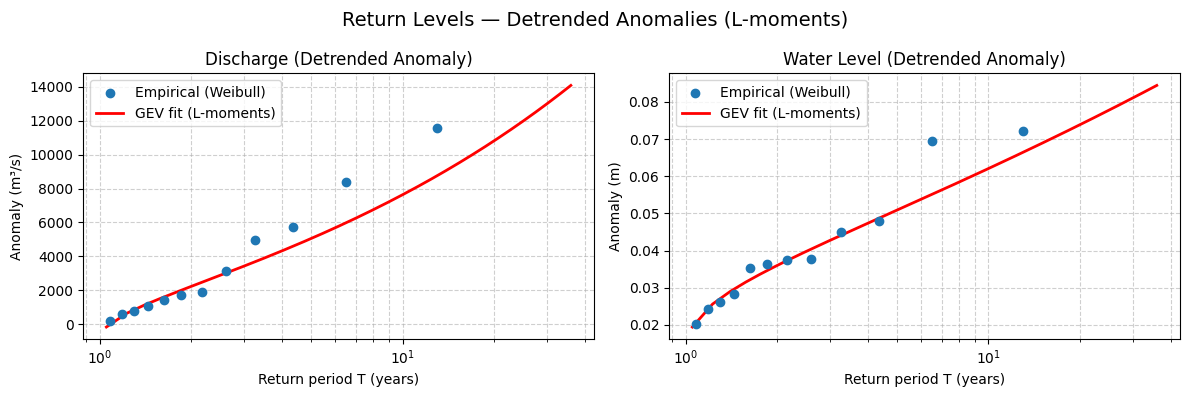

In [206]:
# Fit with L-moments (PWM) instead of MLE (much more stable on short samples) 
from lmoments3 import distr as lmd

# 1) Take annual maxima from the daily series
def annual_max(series):
    """Return annual maxima (one value per year)."""
    return series.resample("A-DEC").max().dropna()

# 2) Fit a GEV distribution to those maxima, parameters estimated by L-moments
def fit_gev_lmom(am_series):
    """Fit GEV distribution to annual maxima using L-moments (PWM)."""
    return lmd.gev.lmom_fit(am_series.values)

# 3) Compute return levels for a range of return periods T
def return_level_curve_lmom(params, T):
    """Compute return levels for given return periods T from L-moments fit."""
    q = 1 - 1/np.array(T, float)
    c, loc, scale = params["c"], params["loc"], params["scale"]
    return lmd.gev.ppf(q, c, loc=loc, scale=scale)

# 4) Plot empirical points (from Weibull plotting position) + fitted GEV curve.
def ax_return_levels(ax, am_series, title, ylabel, factor=3):
    """
    Plot a return level curve on a given matplotlib axis (ax) using L-moments.
    - factor: maximum multiple of record length for Tmax (to avoid extreme extrapolation)
    """
    n = len(am_series)
    Tmax = n * factor
    params = fit_gev_lmom(am_series)

    # Empirical return periods (Weibull plotting position)
    x = np.sort(am_series.values)[::-1]
    m = np.arange(1, n+1)
    T_emp = (n+1) / m

    # Theoretical GEV return level curve (limited to Tmax)
    T_theo = np.linspace(1.05, Tmax, 200)
    RL_theo = return_level_curve_lmom(params, T_theo)

    # Plot
    ax.scatter(T_emp, x, label="Empirical (Weibull)", zorder=3)
    ax.plot(T_theo, RL_theo, "r-", lw=2, label="GEV fit (L-moments)")

    ax.set_xscale("log")
    ax.set_xlabel("Return period T (years)")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

# --- Example usage ---

AM_RD   = annual_max(alignedQW["RD"])      
AM_WL   = annual_max(alignedQW["WL"])      
AM_RDda = annual_max(alignedQW_da["RDda"]) 
AM_WLda = annual_max(alignedQW_da["WLda"]) 

# Figure 1: Raw
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax_return_levels(axes[0], AM_RD, "Volta Estuary River Discharge (Raw)", "Discharge (m³/s)")
ax_return_levels(axes[1], AM_WL, "Water Level (Raw)", "Water level (m)")
fig.suptitle("Return Levels — Raw Data (L-moments)", fontsize=14)
plt.tight_layout()
plt.show()

# Figure 2: Anomalies
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax_return_levels(axes[0], AM_RDda, "Discharge (Detrended Anomaly)", "Anomaly (m³/s)")
ax_return_levels(axes[1], AM_WLda, "Water Level (Detrended Anomaly)", "Anomaly (m)")
fig.suptitle("Return Levels — Detrended Anomalies (L-moments)", fontsize=14)
plt.tight_layout()
plt.show()


Both panels show that, once trends and seasonality have been eliminated (detrended anomalies), the GEV estimate with L-moments provides a relatively more stable and theoretically consistent fit. However, the GEV curve is estimated here on an extremely small sample, since the dataset spans only over 12 years (2010-2021). The Block Maxima approach, then, implieas a significant loss of information, since it only uses annual maxima, ignoring all other extreme events that might happen in the same year. In small datasets, as the one in exam, this means wasting great part of the information contained in the series. This highly limits the GEV capability to well represent the tail distribution of extremes, leading to eventual underestimates or overestimates of the return periods, expecially for the longer ones (>10 years). To avoid this limit, and estimate return periods of 15-30 years in a robust way, it is convinient to consider another extreme analysis method.

### Peaks-Over-Threshold
An alternative to the block maxima approach is the Peaks-Over-Threshold (POT) method, which avoids discharding potentially useful information by considering all observations that exceed a sufficiently high threshold. Instead of retaining only the single maximum value within each block (e.g., one per year), the POT approach models the **distribution of threshold exceedances**. Extreme value theory shows that, for a suitably high threshold, the distribution of excesses over the threshold converges to the Generalized Pareto Distribution (GPD), that is the theoretical distribution of threshold exceedances (Coles, 2001, §5.3). Thus, the POT method provides a more efficient use of the data, since multiple extreme observations within the same year may be included, rather than only the annual maximum.

In hydrological applications, the POT method is particularly valuable when the observation record is relatively short, as this is our case, or when several significant flood peaks occur within a single year. A key practical challenge, however, is the choice of threshold: it must be high enough for the GPD approximation to hold, yet low enough to retain a sufficient number of exceedances for reliable inference (Dupuis, 1999; Naess, 2024).

To find the suitable threshold values for the non-stationary data sereis in exam the following workflow is proposed. 
1) Initial statioary thresholds will be tested, using the empirical quantiles of the series and in particular the percentiles between 95th and 98th for the detrended series anomalies (taken instead of the raw data to overcome the non-stationarity inconvinient).
2) Diagnostic tools for threshold adequacy will be used to ensure linearity above candidate thresholds (which suggests a reasonable GPD), stability, and approximate independence of threshold exceedances.
3) If diagnostics show residual seasonality (e.g., non-uniform exceedance rates by month), move to a time-varying threshold.

Pan, X., Rahman, A., Haddad, K. et al. Peaks-over-threshold model in flood frequency analysis: a scoping review. Stoch Environ Res Risk Assess 36, 2419–2435 (2022). https://doi.org/10.1007/s00477-022-02174-6

#### Threshold selection
##### Stationary thresholds

In the following (step 1 of thrshold selection process), a function loops first through the raw time series and then through the detrended anomaly series, finds and selects all days where discharge or water level exceed a high threshold, fixed for different percentile values (95th, 98th, 99th). For each exceedance, it starts a cluster, creating groups of consecutive exceedances to avoid counting one long flood or surge as multile events. These clusters continue until the series has been below the threshold value for a period of ≥ `run` days (3 for water level, 7 for river discharge), where `run` is the minimum gap to separate two clusters. From each cluster, the function `decluster` extracts only the single maximum (the representative extreme). Then, it returns the timestamps and values of these cluster peaks.

In [207]:
# -------------------------
# General configuration
# -------------------------
percentiles = [0.95, 0.98, 0.99]    # Percentile thresholds to test                # vertical lines on diagnostics
RUN_RD, RUN_WL = 7, 3               # sub-threshold days to close clusters
CAP_K = 5                           # max peaks/year
BOOT_B = 1000                       # bootstrap for CI return levelcurves
MIN_EXC_MRL = 10                    # minimum threshold to show MRL point
SEED = 42

# -------------------------
# Utilities
# -------------------------
def decluster(series, thr, run):
    """
    Identify clusters of exceedances and extract one peak per cluster:
    keep one peak per 'event cluster' above threshold.
    Cluster starts when series > thr; cluster ends after 'run' consecutive days below thr.
    Returns Index of peak datetimes and a Series of peak values.
    """
    s = series.copy()
    above = s > thr  # Boolean mask of exceedances
    peaks = []
    i = 0
    n = len(s)
    while i < n:
        if not above.iloc[i]:
            i += 1
            continue
        # start cluster at i
        j = i + 1
        below = 0
        while j < n:
            if above.iloc[j]:
                below = 0
            else:
                below += 1
                if below >= run:
                    # end cluster just before the run of 'run' sub-threshold days
                    j = j - run + 1
                    break
            j += 1
        cluster = s.iloc[i:j]
        peaks.append(cluster.idxmax())
        i = j
    peaks = pd.Index(peaks)
    return peaks, s.loc[peaks]

def cap_top_k_per_year(peaks: pd.Series, max_k=5):
    """
    peaks: Series indexed by datetime, values = cluster peak magnitudes (> u)
    Keep at most 'max_k' highest peaks per calendar year.
    """
    df = peaks.to_frame("val")
    df["year"] = df.index.year
    kept = (df.sort_values(["year","val"], ascending=[True, False])
              .groupby("year")
              .head(max_k)
              .sort_index())
    return kept["val"]

def pot_prepare(series: pd.Series, u: float, run: int, max_k_per_year=5):
    """
    Declusters and caps to ≤ max_k_per_year peaks per year.
    Returns: excess array, rate λ (per year), and the selected peaks Series.
    """
    s = pd.Series(series).dropna()
    _, peaks_all = decluster(s, thr=u, run=run)
    peaks_all = peaks_all[peaks_all > u].sort_index()
    peaks = cap_top_k_per_year(peaks_all, max_k=max_k_per_year)
    years = s.resample("A-DEC").count().shape[0]
    rate = len(peaks) / years if years > 0 else np.nan
    excess = (peaks - u).values
    return excess, rate, peaks


Raw data with 95th percentile


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]


RD peaks (capped): 11  | rate ≈ 0.92 events/yr
WL peaks (capped): 29  | rate ≈ 2.42 events/yr


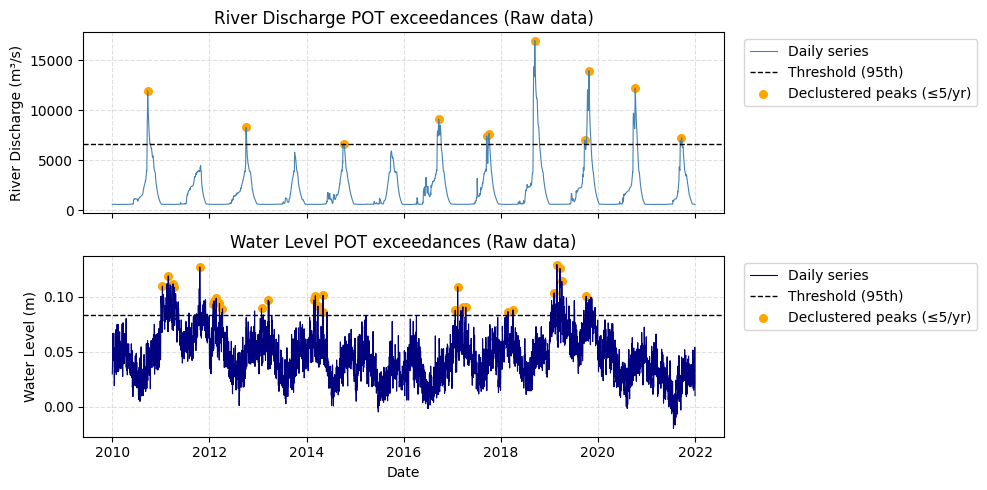

Observed joint days: 15
Expected under independence: 11.0
Amplification factor AF = 1.36



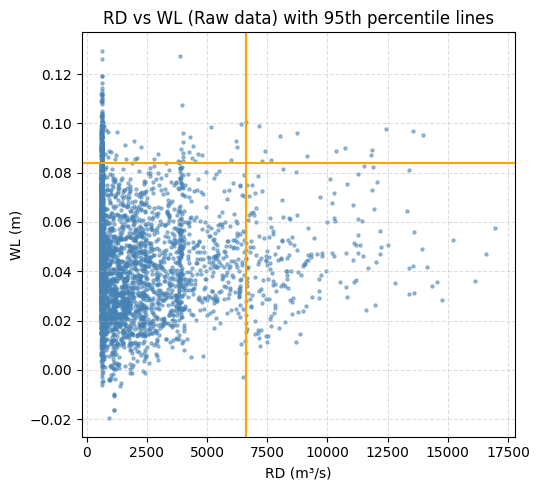

Raw data with 98th percentile
RD peaks (capped): 5  | rate ≈ 0.42 events/yr
WL peaks (capped): 18  | rate ≈ 1.50 events/yr


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]


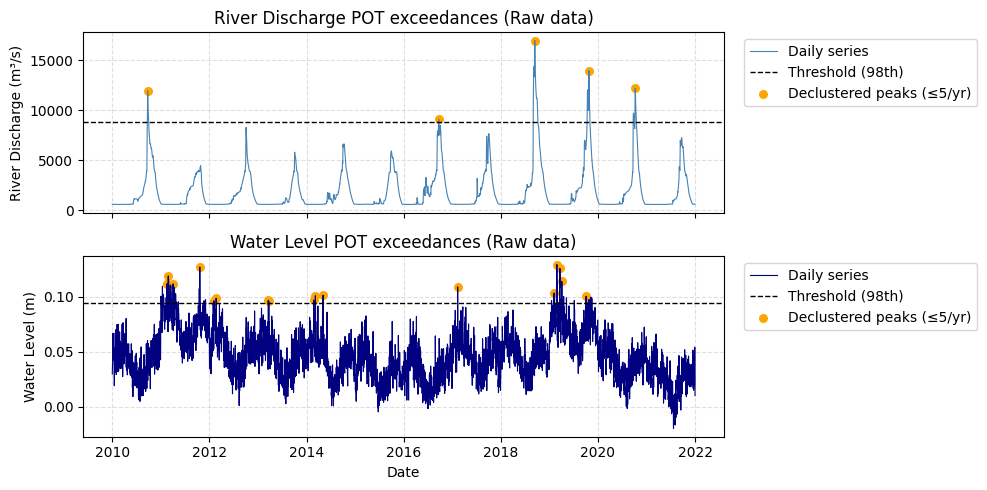

Observed joint days: 3
Expected under independence: 1.7
Amplification factor AF = 1.74



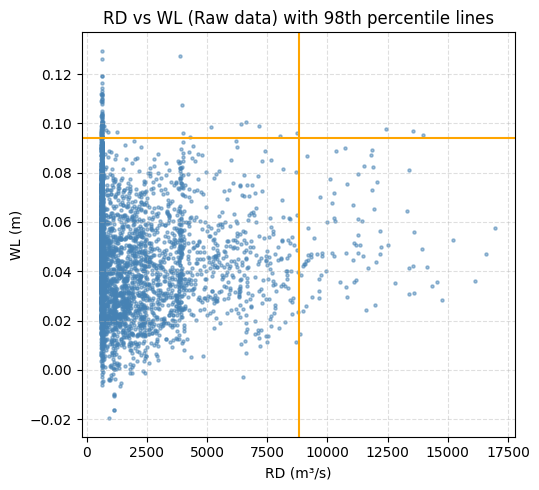

Raw data with 99th percentile
RD peaks (capped): 4  | rate ≈ 0.33 events/yr
WL peaks (capped): 13  | rate ≈ 1.08 events/yr


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]


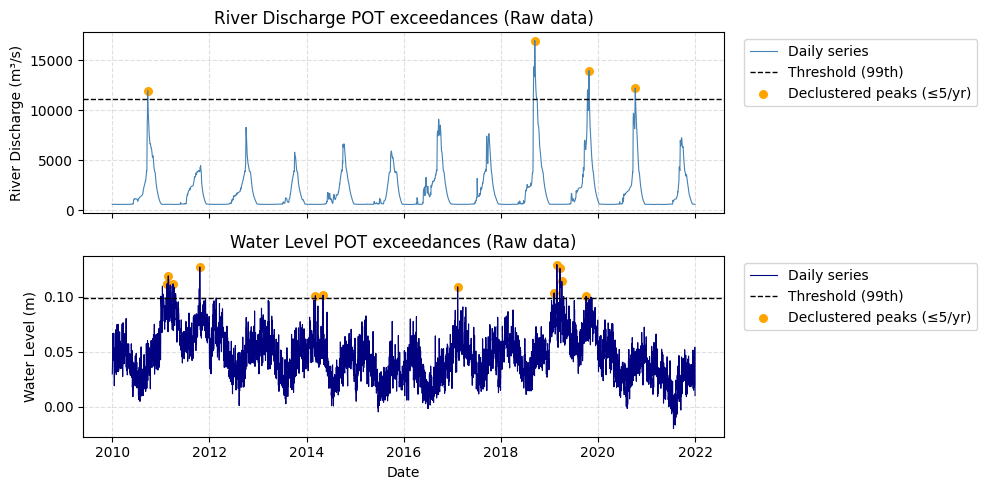

Observed joint days: 0
Expected under independence: 0.4
Amplification factor AF = 0.00



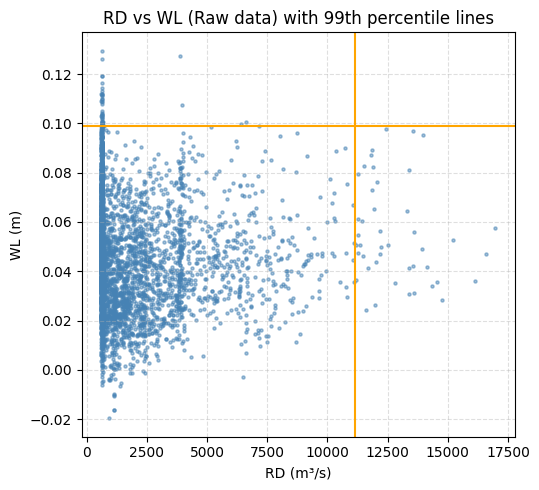

Detrended anomalies with 95th percentile
RD peaks (capped): 13  | rate ≈ 1.08 events/yr
WL peaks (capped): 23  | rate ≈ 1.92 events/yr


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]


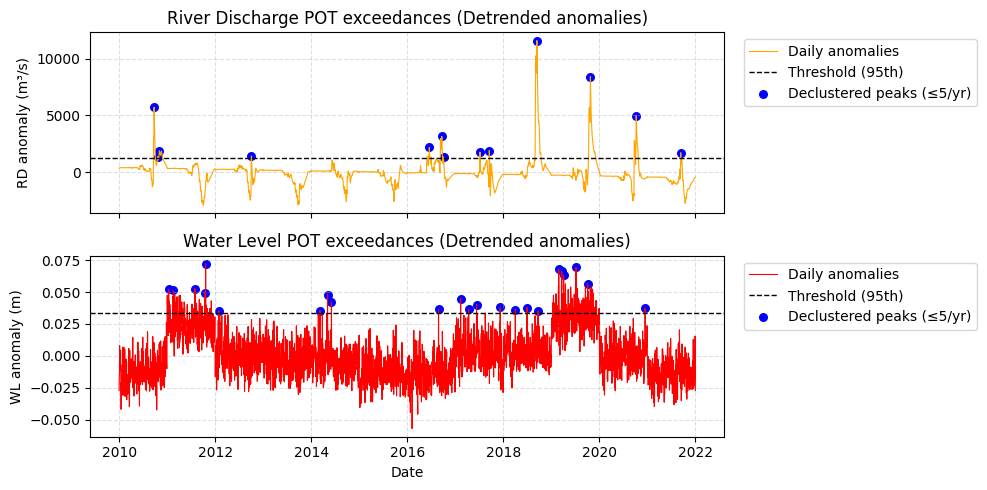

Observed joint days: 31
Expected under independence: 11.0
Amplification factor AF = 2.83



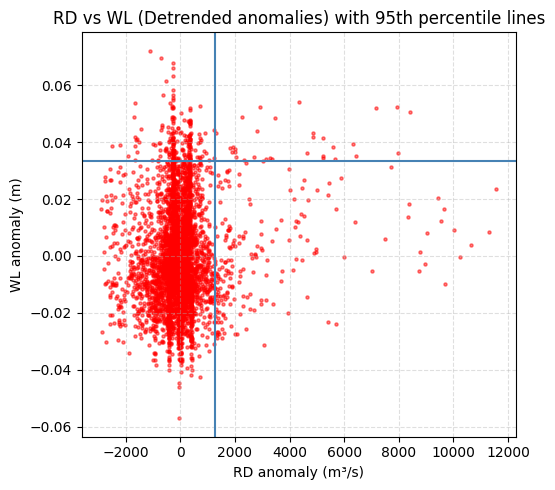

Detrended anomalies with 98th percentile
RD peaks (capped): 5  | rate ≈ 0.42 events/yr
WL peaks (capped): 13  | rate ≈ 1.08 events/yr


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]


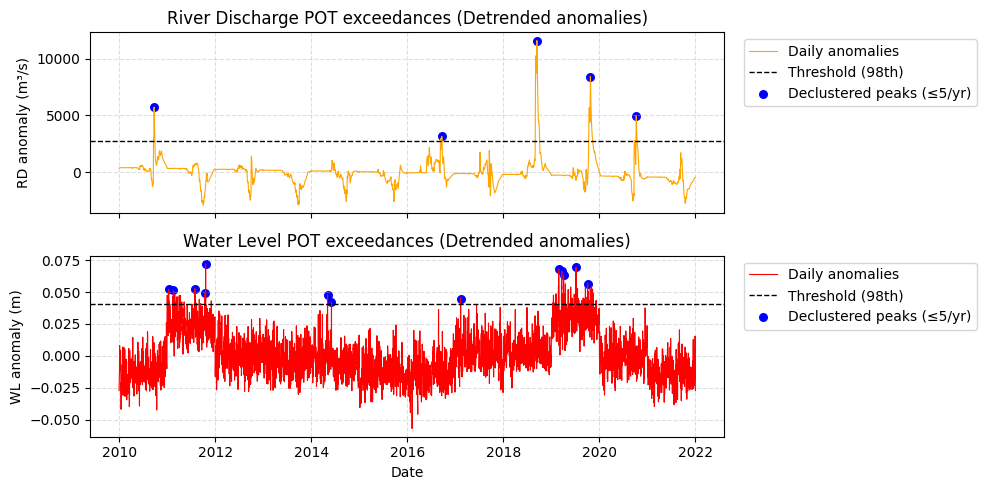

Observed joint days: 10
Expected under independence: 1.8
Amplification factor AF = 5.66



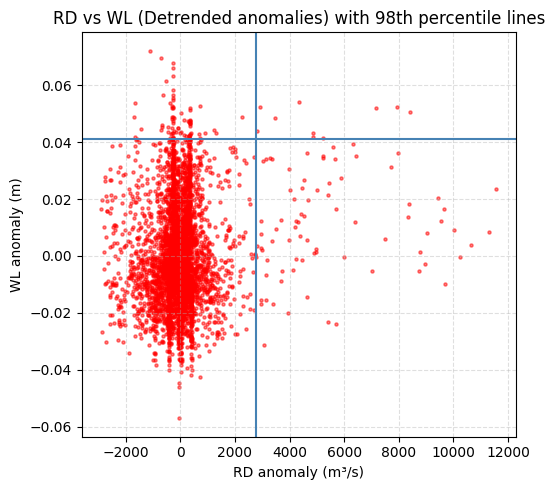

Detrended anomalies with 99th percentile
RD peaks (capped): 4  | rate ≈ 0.33 events/yr
WL peaks (capped): 11  | rate ≈ 0.92 events/yr


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]


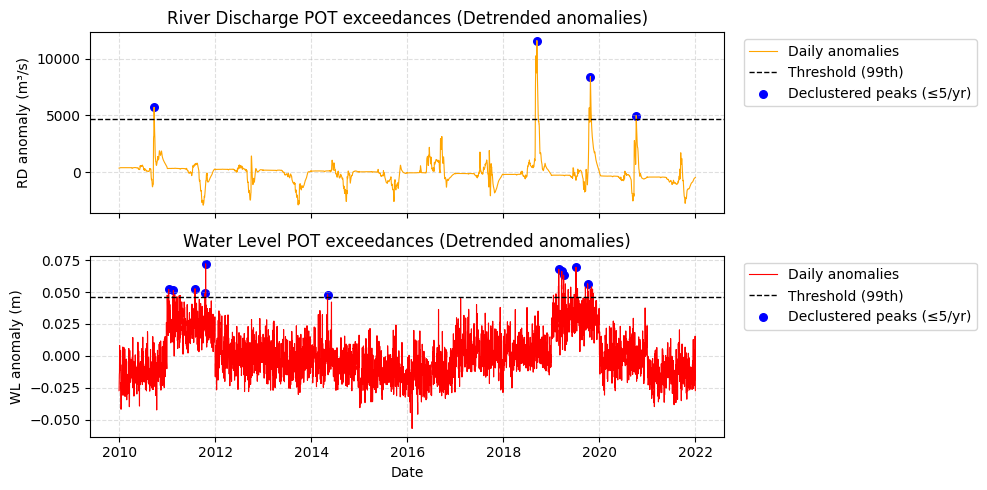

Observed joint days: 3
Expected under independence: 0.4
Amplification factor AF = 6.79



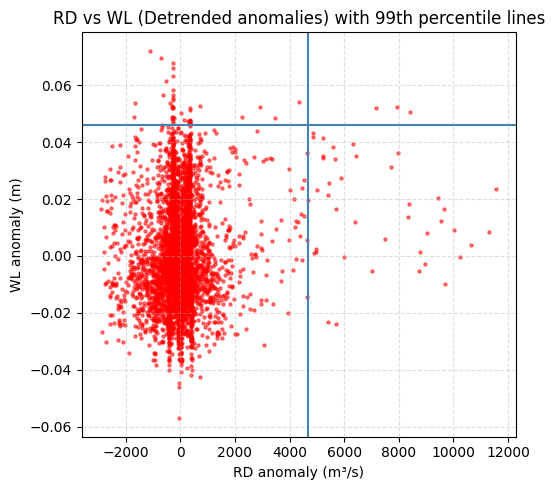

In [208]:
# ============================
# (1) Try stationary thesholds
# ============================

for label, df, col_RD, col_WL in [
    ("Raw data", alignedQW, "RD", "WL"),
    ("Detrended anomalies", alignedQW_da, "RDda", "WLda"),
]:
    years = df.index.year.nunique()
    
    for q in percentiles:
        print("="*60)
        print(f"{label} with {int(q*100)}th percentile")

        # thresholds from the current dataframe/column
        THR_RD = float(df[col_RD].quantile(q))
        THR_WL = float(df[col_WL].quantile(q))

        # --- decluster + cap (≤5 peaks/yr) ---
        ex_rd, rate_rd, rd_peaks_c = pot_prepare(df[col_RD], THR_RD, run=RUN_RD, max_k_per_year=5)
        ex_wl, rate_wl, wl_peaks_c = pot_prepare(df[col_WL], THR_WL, run=RUN_WL, max_k_per_year=5)

        print(f"RD peaks (capped): {len(rd_peaks_c)}  | rate ≈ {rate_rd:.2f} events/yr")
        print(f"WL peaks (capped): {len(wl_peaks_c)}  | rate ≈ {rate_wl:.2f} events/yr")

        # --- Timeline of POT exceedances ---
        fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

        # RD panel
        axes[0].plot(df.index, df[col_RD], lw=0.8,
                     color="steelblue" if "Raw" in label else "orange",
                     label="Daily series" if "Raw" in label else "Daily anomalies")
        axes[0].axhline(THR_RD, color="k", ls="--", lw=1, label=f"Threshold ({int(q*100)}th)")
        axes[0].scatter(rd_peaks_c.index, rd_peaks_c.values, s=30,
                        color="orange" if "Raw" in label else "blue",
                        label="Declustered peaks (≤5/yr)")
        axes[0].set_ylabel("River Discharge (m³/s)" if "Raw" in label else "RD anomaly (m³/s)")
        axes[0].set_title(f"River Discharge POT exceedances ({label})")
        axes[0].legend(loc="upper left", bbox_to_anchor=(1.02, 1))

        # WL panel
        axes[1].plot(df.index, df[col_WL], lw=0.8,
                     color="navy" if "Raw" in label else "red",
                     label="Daily series" if "Raw" in label else "Daily anomalies")
        axes[1].axhline(THR_WL, color="k", ls="--", lw=1, label=f"Threshold ({int(q*100)}th)")
        axes[1].scatter(wl_peaks_c.index, wl_peaks_c.values, s=30,
                        color="orange" if "Raw" in label else "blue",
                        label="Declustered peaks (≤5/yr)")
        axes[1].set_ylabel("Water Level (m)" if "Raw" in label else "WL anomaly (m)")
        axes[1].set_title(f"Water Level POT exceedances ({label})")
        axes[1].set_xlabel("Date")
        axes[1].legend(loc="upper left", bbox_to_anchor=(1.02, 1))

        for a in axes:
            a.grid(True, ls="--", alpha=0.4)

        plt.tight_layout()
        plt.show()

        # --- Joint exceedances (daily) ---
        mask_joint = (df[col_RD] > THR_RD) & (df[col_WL] > THR_WL)
        N_joint = int(mask_joint.sum())

        pRD = (df[col_RD] > THR_RD).mean()
        pWL = (df[col_WL] > THR_WL).mean()
        N = len(df)
        E_ind = N * pRD * pWL
        AF = N_joint / E_ind if E_ind > 0 else np.nan

        print(f"Observed joint days: {N_joint}")
        print(f"Expected under independence: {E_ind:.1f}")
        print(f"Amplification factor AF = {AF:.2f}\n")

        # --- RD vs WL scatter with threshold lines ---
        plt.figure(figsize=(5.5,5))
        plt.scatter(df[col_RD], df[col_WL], s=5, alpha=0.5,
                    color='r' if "Detrended" in label else 'steelblue')
        plt.axvline(THR_RD, color="orange" if "Raw" in label else "steelblue")
        plt.axhline(THR_WL, color="orange" if "Raw" in label else "steelblue")
        plt.xlabel("RD (m³/s)" if "Raw" in label else "RD anomaly (m³/s)")
        plt.ylabel("WL (m)"    if "Raw" in label else "WL anomaly (m)")
        plt.title(f"RD vs WL ({label}) with {int(q*100)}th percentile lines")
        plt.grid(True, ls="--", alpha=0.4)
        plt.tight_layout()
        plt.show()


With the raw data series, it is evident that the 99th percentiles is not a suitable threshold for extrme analysis. It is in fact too high, excluding all the combined extreme events.

using detrended anomalies → exceedance rate is more stable.

Rule of thumb: aim for ≥40–60 peaks for primary inference; if <25, use that threshold only as a qualitative sensitivity.

##### POT diagnostics: MRL, parameter stability, exceedance rate


After trying different percentiles as stationary thresholds, the second step of this selection process consists in ascertaining threshold adequacy. This means to make **MRL (mean residual life) curves**, since linearity with MRL above candidate threshold suggests GPD is reasonable, and **parameter-stability plots (ξ, σ)** across a grid of high thresholds, preferably on the detrended anomalies and using declustered peaks so the i.i.d. assumption is less violated. Lastly, the exceedance rate is comparted to the thresholds as a **sanity check** trade-off between bias (too low threshold) and variance (too high threshold).

The reslunting plots examine the sensitivity of GP parameter estimates to the threshold, as described in Coles (2001, chapter 4) and Scarrott and MacDonald (2012). Over a range of values of thresholds = u, estimates ξ of the shape and σ − ξ of the modified scale are plotted against u with pointwise 95% symmetric confidence intervals (Northrop & Coleman, 2014). The lowest threshold above which these quantities are judged to be approximately constant in u is selected, taking into account sampling variability summarized by the confidence intervals.

In [209]:
# ===========================================
# (2) POT threshold adequacy diagnostics: 
#     MRL + GPD stability + exceedance rate
# ===========================================

# ---------- threshold grid ----------
def threshold_grid(series, qmin=0.90, qmax=0.99, n=20, mark_q=(0.95,0.98,0.99)):
    s = pd.Series(series).dropna()
    qs = np.linspace(qmin, qmax, n).tolist() + list(mark_q)
    qs = sorted(set(qs))
    u_all  = s.quantile(qs).dropna().values
    u_mark = s.quantile(list(mark_q)).dropna().values.tolist()
    return u_all, u_mark

# ---------- GPD parameter estimation helpers ----------
def _gpd_fit_pwm(excess):
    """
    Hosking & Wallis PWM estimator for GPD (ξ, σ).
    Use as fallback when SciPy is missing or MLE fails.
    """
    y = np.sort(np.asarray(excess, float))
    n = len(y)
    if n < 3:
        return np.nan, np.nan
    b0 = y.mean()
    w1 = np.arange(n)/(n-1.0) if n > 1 else np.zeros(n)
    b1 = (w1*y).sum()/n
    denom = (b0 - b1)
    if denom <= 0:
        return np.nan, np.nan
    xi = (2*b1 - b0) / denom
    sigma = b0 * (1 - xi)
    return (float(xi), float(sigma)) if sigma > 0 else (np.nan, np.nan)

def _gpd_fit(excess):
    """
    Try SciPy MLE with loc=0 for excesses; fall back to PWM.
    Returns (xi, sigma).
    """
    y = np.asarray(excess, float)
    if y.size < 3: return np.nan, np.nan
    try:
        from scipy.stats import genpareto
        xi, loc, sigma = genpareto.fit(y, floc=0.0)
        return float(xi), float(sigma)
    except Exception:
        return _gpd_fit_pwm(y)

# ---------- MRL ----------
def mean_residual_life(series, thresholds, run=7, min_exc=10):
    """
    For each threshold u:
      - decluster using runs,
      - compute mean excess E[X-u | X>u],
      - return mean, SE and #exceedances.
    """
    s = pd.Series(series).dropna()
    rows = []
    for u in thresholds:
        _, peaks = decluster(s, u, run=run)
        y = (peaks - u).dropna().to_numpy()
        n = y.size
        if n < min_exc:
            rows.append((u, np.nan, np.nan, n))
        else:
            m  = float(y.mean())
            sd = float(y.std(ddof=1)) if n > 1 else np.nan
            se = sd/np.sqrt(n) if (n > 1 and np.isfinite(sd)) else np.nan
            rows.append((u, m, se, n))
    return pd.DataFrame(rows, columns=["u","mean_excess","se","n_exc"])

def plot_mrl(df_mrl, title="", mark_u=None):
    keep = df_mrl.dropna(subset=["mean_excess"])
    plt.figure(figsize=(6.4,4.1))
    plt.errorbar(keep["u"], keep["mean_excess"], yerr=1.96*keep["se"],
                 fmt="o-", lw=1, ms=4, capsize=2, color ='k')
    if mark_u:
        for uu in mark_u: plt.axvline(uu, ls="--", lw=1)
    plt.xlabel("Threshold u")
    plt.ylabel("Mean excess  E[X - u | X > u]")
    plt.title(f"{title} — MRL")
    plt.grid(True, ls="--", alpha=0.4)
    plt.tight_layout(); plt.show()

# ---------- GPD parameter stability ----------
def gpd_stability(series, thresholds, run=7, min_exc=10, B=300, seed=42):
    """
    For each u:
      - decluster -> cluster peaks -> excesses (peaks - u)
      - fit GPD (xi, sigma)
      - bootstrap resample excesses for 95% CIs
    Returns DataFrame (u, n_exc, xi, xi_lo, xi_hi, sigma, sigma_lo, sigma_hi).
    """
    rng = np.random.default_rng(seed)
    s = pd.Series(series).dropna()
    rows = []
    for u in thresholds:
        _, peaks = decluster(s, u, run=run)
        y = (peaks - u).dropna().to_numpy()
        n = y.size
        if n < min_exc:
            rows.append((u, n, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan))
            continue
        xi, sigma = _gpd_fit(y)
        # bootstrap CIs
        xis, sigs = [], []
        if np.isfinite(xi) and np.isfinite(sigma):
            for _ in range(B):
                yy = rng.choice(y, size=n, replace=True)
                xi_b, sig_b = _gpd_fit(yy)
                if np.isfinite(xi_b) and np.isfinite(sig_b):
                    xis.append(xi_b); sigs.append(sig_b)
        if len(xis) >= 20:
            xi_lo, xi_hi = np.percentile(xis, [2.5, 97.5])
            sg_lo, sg_hi = np.percentile(sigs, [2.5, 97.5])
        else:
            xi_lo = xi_hi = sg_lo = sg_hi = np.nan
        rows.append((u, n, xi, xi_lo, xi_hi, sigma, sg_lo, sg_hi))
    cols = ["u","n_exc","xi","xi_lo","xi_hi","sigma","sigma_lo","sigma_hi"]
    return pd.DataFrame(rows, columns=cols)

def plot_stability(df_stab, title="", mark_u=None):
    keep = df_stab.dropna(subset=["xi","sigma"])
    fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True)

    # ξ
    ax[0].plot(keep["u"], keep["xi"], "o-")
    if keep["xi_lo"].notna().any():
        ax[0].fill_between(keep["u"], keep["xi_lo"], keep["xi_hi"], alpha=0.2, color= 'grey')
    if mark_u:
        for uu in mark_u: ax[0].axvline(uu, ls="--", lw=1)
    ax[0].axhline(0, color="k", lw=0.8, ls="--")
    ax[0].set_xlabel("u"); ax[0].set_ylabel("Shape ξ")
    ax[0].set_title(f"{title} — ξ stability"); ax[0].grid(True, ls="--", alpha=0.4)
    
    # σ
    ax[1].plot(keep["u"], keep["sigma"], "o-")
    if keep["sigma_lo"].notna().any():
        ax[1].fill_between(keep["u"], keep["sigma_lo"], keep["sigma_hi"], alpha=0.2, color= 'grey')
    if mark_u:
        for uu in mark_u: ax[1].axvline(uu, ls="--", lw=1)
    ax[1].set_xlabel("u"); ax[1].set_ylabel("Scale σ")
    ax[1].set_title(f"{title} — σ stability"); ax[1].grid(True, ls="--", alpha=0.4)
    plt.tight_layout(); plt.show()

# ---------- exceedance rate ----------
def exceedance_rate(series, thresholds, run=7):
    """
    For each threshold u:
      - decluster using runs to get cluster peaks,
      - count peaks above u (n_exc),
      - compute exceedance rate p_hat = n_exc / N where N = number of non-NA original observations,
      - provide normal-approx 95% CI for p_hat.
    Returns DataFrame (u, n_exc, N, rate, lo, hi).
    """
    s = pd.Series(series).dropna()
    N = len(s)
    rows = []
    for u in thresholds:
        _, peaks = decluster(s, u, run=run)
        n_exc = int((peaks > u).sum())  # should equal len(peaks) by construction
        p = n_exc / N if N > 0 else np.nan
        if N > 0 and np.isfinite(p):
            se = np.sqrt(p*(1-p)/N)
            lo = max(0.0, p - 1.96*se)
            hi = min(1.0, p + 1.96*se)
        else:
            lo = hi = np.nan
        rows.append((u, n_exc, N, p, lo, hi))
    return pd.DataFrame(rows, columns=["u","n_exc","N","rate","rate_lo","rate_hi"])

def plot_exceedance_rate(df_rate, title="", mark_u=None):
    keep = df_rate.dropna(subset=["rate"])
    plt.figure(figsize=(6.4,4.1))
    plt.plot(keep["u"], keep["rate"], "o-")
    if keep["rate_lo"].notna().any():
        plt.fill_between(keep["u"], keep["rate_lo"], keep["rate_hi"], alpha=0.2, color='grey')
    if mark_u:
        for uu in mark_u: plt.axvline(uu, ls="--", lw=1)
    plt.xlabel("Threshold u")
    plt.ylabel("Exceedance rate  P(X > u)")
    plt.title(f"{title} — exceedance rate")
    plt.grid(True, ls="--", alpha=0.4)
    plt.tight_layout(); plt.show()


# ---------- one-call wrapper  ----------
def run_threshold_diagnostics(series, label, run,
                              qmin=0.90, qmax=0.99, n=20,
                              mark_q=(0.95,0.98,0.99),
                              min_exc=10, B=300, seed=42,
                              return_rate=False):
    """
    Build the u-grid (incl. 95/98/99), then plot:
      - MRL (with 95% error bars)
      - Stability of GPD ξ, σ with bootstrap CIs
      - Exceedance rate P(X>u) with 95% CI

    Returns:
      - if return_rate=False (default): (df_mrl, df_stab, u_marks)
      - if return_rate=True:           (df_mrl, df_stab, df_rate, u_marks)
    """
    u_grid, u_marks = threshold_grid(series, qmin, qmax, n, mark_q)

    # MRL
    df_mrl  = mean_residual_life(series, u_grid, run=run, min_exc=min_exc)
    plot_mrl(df_mrl, title=label, mark_u=u_marks)

    # GPD stability
    df_stab = gpd_stability(series, u_grid, run=run, min_exc=min_exc, B=B, seed=seed)
    plot_stability(df_stab, title=label, mark_u=u_marks)

    # Exceedance rate (always plotted; dataframe optionally returned)
    df_rate = exceedance_rate(series, u_grid, run=run)
    plot_exceedance_rate(df_rate, title=label, mark_u=u_marks)

    # quick table at marked thresholds
    tri = (pd.DataFrame({"u": u_marks})
           .merge(df_stab[["u","n_exc","xi","sigma"]], on="u", how="left")
           .sort_values("u"))
    print(f"\n{label} — GPD at marked thresholds (n = declustered peaks):\n", tri.to_string(index=False))

    if return_rate:
        return df_mrl, df_stab, df_rate, u_marks
    else:
        return df_mrl, df_stab, u_marks


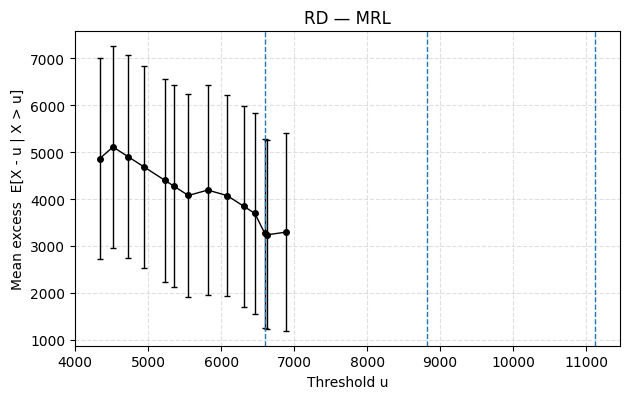

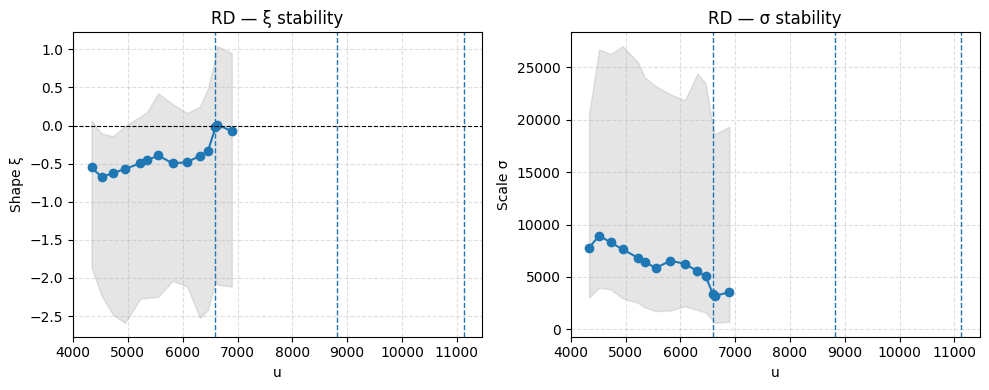

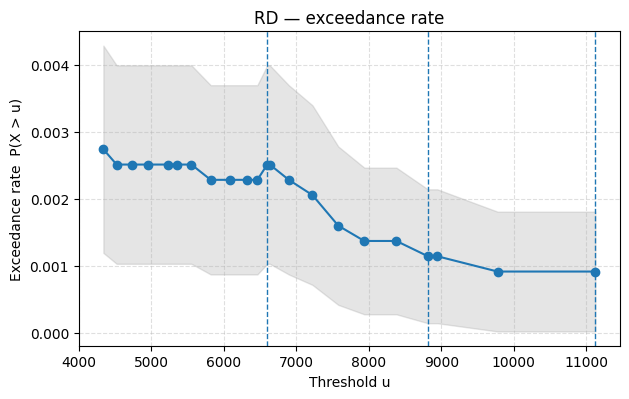


RD — GPD at marked thresholds (n = declustered peaks):
            u  n_exc        xi       sigma
 6597.639062     11 -0.024052 3352.112346
 8814.505937      5       NaN         NaN
11125.952813      4       NaN         NaN


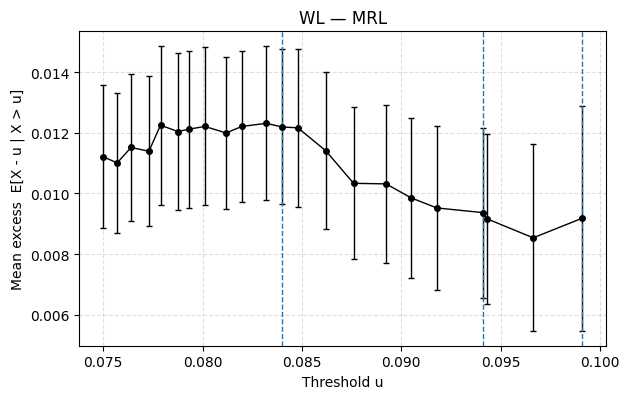

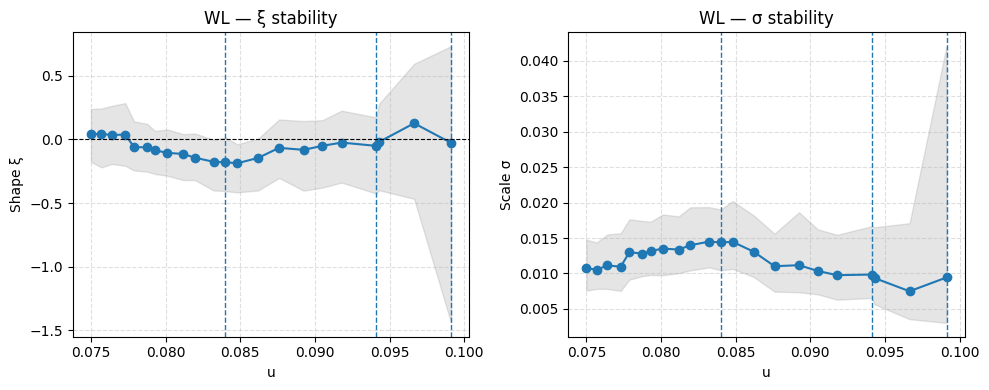

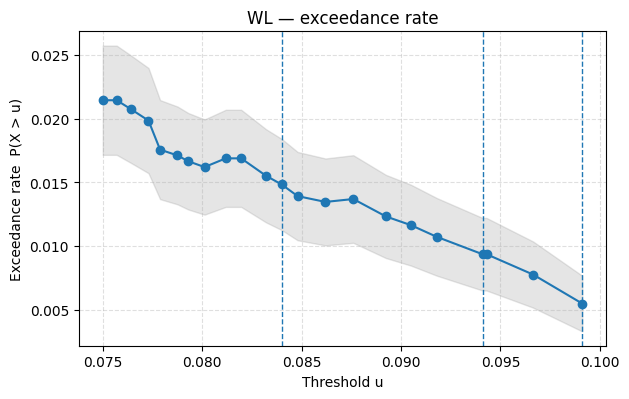


WL — GPD at marked thresholds (n = declustered peaks):
        u  n_exc        xi    sigma
0.084000     65 -0.179721 0.014390
0.094100     41 -0.051367 0.009851
0.099118     24 -0.028145 0.009443


In [210]:
# River discharge, runs=7
df_mrl_RD, df_stab_RD, u_RD_marks = run_threshold_diagnostics(
    alignedQW["RD"], label="RD", run=RUN_RD,
    qmin=0.90, qmax=0.99, n=20, mark_q=(0.95,0.98,0.99),
    min_exc=10, B=300, seed=42
)

# Water level, runs=3
df_mrl_WL, df_stab_WL, u_WL_marks = run_threshold_diagnostics(
    alignedQW["WL"], label="WL", run=RUN_WL,
    qmin=0.90, qmax=0.99, n=20, mark_q=(0.95,0.98,0.99),
    min_exc=15, B=300, seed=42
)

##### Fit GPD to exceeadnce

C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]


RD:                              RL (95% CI)
T                                       
2.0   8.94e+03 m³/s (7.53e+03, 1.21e+04)
5.0   1.17e+04 m³/s (9.08e+03, 1.56e+04)
10.0     1.34e+04 m³/s (1e+04, 1.84e+04)
20.0  1.48e+04 m³/s (1.02e+04, 2.31e+04)
30.0  1.54e+04 m³/s (1.03e+04, 2.64e+04)
50.0  1.61e+04 m³/s (1.04e+04, 3.19e+04)


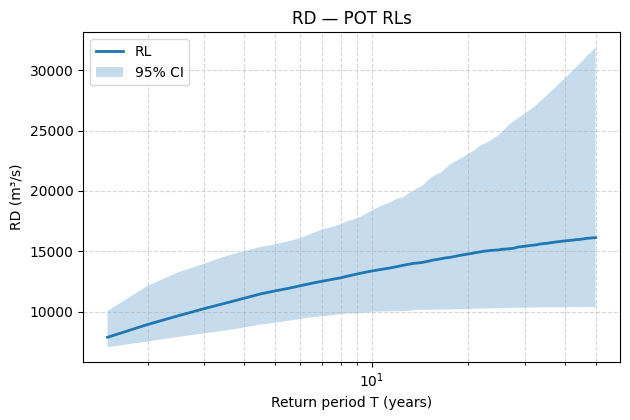

WL:                  RL (95% CI)
T                           
2.0   0.113 m (0.106, 0.122)
5.0   0.121 m (0.113, 0.127)
10.0  0.124 m (0.116, 0.129)
20.0  0.126 m (0.118, 0.132)
30.0  0.127 m (0.118, 0.133)
50.0  0.128 m (0.119, 0.135)


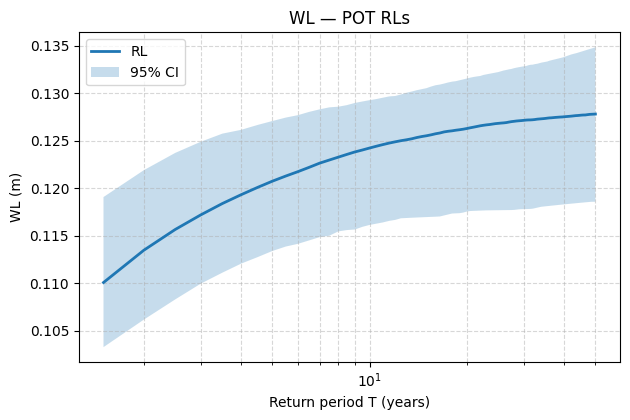

In [211]:
# ============================================================
# (3) FIT GPD TO EXCEEDANCE (RL + CI bootstrap)
# ============================================================
def pot_return_levels(u, xi, sigma, rate, T):
    T = np.asarray(T, float); tiny = 1e-8
    if not np.isfinite(rate) or rate <= 0:
        return np.full_like(T, np.nan)
    if abs(xi) < tiny:
        return u + sigma*np.log(rate*T)
    return u + (sigma/xi)*((rate*T)**xi - 1.0)

def pot_rl_with_ci(excess, u, rate, T, B=BOOT_B, alpha=0.05, seed=SEED):
    rng = np.random.default_rng(seed)
    excess = np.asarray(excess, float); n = len(excess)
    if n < 8 or not np.isfinite(rate) or rate <= 0:
        rl = np.full_like(np.asarray(T, float), np.nan, dtype=float)
        return rl, rl.copy(), rl.copy()
    xi_hat, sig_hat = _gpd_fit(excess)
    T = np.asarray(T, float)
    rl_hat = pot_return_levels(u, xi_hat, sig_hat, rate, T)
    sims = []
    for _ in range(B):
        try:
            exb = st.genpareto.rvs(c=xi_hat, loc=0.0, scale=sig_hat, size=n, random_state=rng)
            xi_b, sig_b = _gpd_fit(exb)
            if np.isfinite(xi_b) and np.isfinite(sig_b) and sig_b>0:
                sims.append(pot_return_levels(u, xi_b, sig_b, rate, T))
        except Exception:
            continue
    if len(sims) < max(200, int(0.3*B)):
        lo = np.full_like(rl_hat, np.nan); hi = np.full_like(rl_hat, np.nan)
        return rl_hat, lo, hi
    sims = np.vstack(sims)
    lo = np.nanpercentile(sims, 2.5, axis=0)
    hi = np.nanpercentile(sims, 97.5, axis=0)
    med = np.nanmedian(sims, axis=0)
    return med, lo, hi

def rl_table(result, Ts=(2,5,10,20,30,50), units=""):
    df = pd.DataFrame({"T": result["T"], "RL": result["RL"],
                       "lo": result["RL_lo"], "hi": result["RL_hi"]})
    df = df[df["T"].isin(Ts)].copy()
    def fmt(r):
        return (f"{r.RL:.3g}{units} ({r.lo:.3g}, {r.hi:.3g})"
                if np.isfinite(r.lo) else f"{r.RL:.3g}{units}")
    df["RL (95% CI)"] = df.apply(fmt, axis=1)
    return df[["T","RL (95% CI)"]].set_index("T")

def plot_pot_curve(res, title, ylab):
    T, RL, lo, hi = res["T"], res["RL"], res["RL_lo"], res["RL_hi"]
    plt.figure(figsize=(6.4,4.3))
    plt.plot(T, RL, lw=2, label="RL")
    if np.isfinite(lo).any(): plt.fill_between(T, lo, hi, alpha=0.25, label="95% CI")
    plt.xscale("log"); plt.xlabel("Return period T (years)"); plt.ylabel(ylab)
    plt.title(title); plt.grid(True, which="both", ls="--", alpha=0.5); plt.legend()
    plt.tight_layout(); plt.show()

def fit_gpd_to_exceedance(
    series: pd.Series,
    run: int,
    cap_k: int = CAP_K,
    q: float | None = 0.95,    # se u non è dato, usa percentile q
    u: float | None = None,    # puoi passare una soglia esplicita
    T_grid = None,
    B: int = BOOT_B
):
    if T_grid is None:
        T_grid = np.arange(1.5, 50.1, 0.5)
    if u is None:
        u = float(pd.Series(series).dropna().quantile(q))
    excess, rate, peaks = pot_prepare(series, u, run=run, max_k_per_year=cap_k)
    xi, sigma = _gpd_fit(excess)
    RL, RL_lo, RL_hi = pot_rl_with_ci(excess, u, rate, np.asarray(T_grid), B=B)
    res = {"u":u, "xi":xi, "sigma":sigma, "rate":rate, "T":np.asarray(T_grid),
           "RL":RL, "RL_lo":RL_lo, "RL_hi":RL_hi, "n_peaks":len(excess), "peaks":peaks}
    return res

# --- (3) Fit GPD to exceedance (q=0.95 o u esplicita) ---
res_RD = fit_gpd_to_exceedance(alignedQW["RD"], run=RUN_RD, cap_k=CAP_K, q=0.95, u=None, B=BOOT_B)
res_WL = fit_gpd_to_exceedance(alignedQW["WL"], run=RUN_WL, cap_k=CAP_K, q=0.95, u=None, B=BOOT_B)
print("RD:", rl_table(res_RD, units=" m³/s")); plot_pot_curve(res_RD, "RD — POT RLs", "RD (m³/s)")
print("WL:", rl_table(res_WL, units=" m"));    plot_pot_curve(res_WL, "WL — POT RLs", "WL (m)")


## Bivariate Extreme Analysis


### Identification of compound events

In [212]:
# ===============================
# Compound events on RAW series
# ===============================

def compound_sets_raw(q=0.95, Δ=0, max_k=5):
    """
    Return three sets of dates for compound events A/B/C at (q, Δ),
    using RAW daily series alignedQW['RD'] and alignedQW['WL'].
    """
    df = alignedQW.dropna().copy()  # RAW series

    # ---- thresholds on RAW series ----
    u_RD = float(df["RD"].quantile(q))
    u_WL = float(df["WL"].quantile(q))

    # ---- A) same-day AND (raw) ----
    A = set(df.index[(df["RD"] > u_RD) & (df["WL"] > u_WL)])

    # ---- B) lagged window ±Δ using declustered RAW peaks ----
    # declustered peaks per margin on RAW series
    _, _, RD_peaks = pot_prepare(df["RD"], u_RD, run=RUN_RD, max_k_per_year=max_k)
    _, _, WL_peaks = pot_prepare(df["WL"], u_WL, run=RUN_WL, max_k_per_year=max_k)
    rdt = RD_peaks.index.sort_values()
    wlt = WL_peaks.index.sort_values()

    # pair peaks if within ±Δ days
    i = j = 0
    pairs = []
    while i < len(rdt) and j < len(wlt):
        dt = (rdt[i] - wlt[j]).days
        if abs(dt) <= Δ:
            pairs.append((rdt[i], wlt[j]))
            i += 1; j += 1
        elif dt < 0:
            i += 1
        else:
            j += 1

    # representative "peak day" per paired episode (take earlier of the two peaks)
    B = set(min(p, w) for p, w in pairs)  # ← avoid shadowing q

    # ---- C) "OR with contributing role" (raw) ----
    elev_RD = df["RD"] > df["RD"].quantile(0.75)
    elev_WL = df["WL"] > df["WL"].quantile(0.75)
    C_mask = ((df["RD"] > u_RD) & elev_WL) | ((df["WL"] > u_WL) & elev_RD)
    C = set(df.index[C_mask])

    return A, B, C, u_RD, u_WL

# Jaccard index to see how much two event selections agree (if they pick the same days/episodes)
def jaccard(S, T):
    if not S and not T:
        return np.nan
    return len(S & T) / len(S | T) if (S | T) else 0.0

# -----------------
# Robustness table
# -----------------
q_list = [0.90, 0.95, 0.98]
Δ_list = [0, 1, 2, 3]

rows = []
for q in q_list:
    for Δ in Δ_list:
        A, B, C, uRD, uWL = compound_sets_raw(q=q, Δ=Δ, max_k=5)
        # counts
        nA, nB, nC = len(A), len(B), len(C)
        # overlaps
        AB = len(A & B); AC = len(A & C); BC = len(B & C)
        ABC = len(A & B & C)
        # similarity
        J_AB = jaccard(A,B); J_AC = jaccard(A,C); J_BC = jaccard(B,C)
        rows.append({
            "q": q, "Δ": Δ,
            "u_RD": uRD, "u_WL": uWL,
            "|A|": nA, "|B|": nB, "|C|": nC,
            "|A∩B|": AB, "|A∩C|": AC, "|B∩C|": BC, "|A∩B∩C|": ABC,
            "J(A,B)": J_AB, "J(A,C)": J_AC, "J(B,C)": J_BC
        })

robust_tbl = pd.DataFrame(rows).sort_values(["q","Δ"]).reset_index(drop=True)

# neat column names
new_names = {
    "q": "quantile_q",
    "Δ": "lag_days",
    "u_RD": "u_RD",
    "u_WL": "u_WL",
    "|A|": "n_AND_days (A)",
    "|B|": "n_lagged_episodes (B)",
    "|C|": "n_OR_days (C)",
    "|A∩B|": "n_A_intersect_B",
    "|A∩C|": "n_A_intersect_C",
    "|B∩C|": "n_B_intersect_C",
    "|A∩B∩C|": "n_A_intersect_B_intersect_C",
    "J(A,B)": "jaccard_A_B",
    "J(A,C)": "jaccard_A_C",
    "J(B,C)": "jaccard_B_C",
}
robust_tbl = robust_tbl.rename(columns=new_names)

# tidy order (optional)
col_order = [
    "quantile_q","lag_days","u_RD","u_WL",
    "n_AND_days (A)","n_lagged_episodes (B)","n_OR_days (C)",
    "n_A_intersect_B","n_A_intersect_C","n_B_intersect_C","n_A_intersect_B_intersect_C",
    "jaccard_A_B","jaccard_A_C","jaccard_B_C",
]
robust_tbl = robust_tbl[col_order]

display(robust_tbl)


C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  years = s.resample("A-DEC").count().shape[0]
C:\Users\aless\AppData\Local\Temp\ipykernel_32364\492173549.py:71: FutureWarning: 'A-DEC' is deprecated and will be 

quantile_q  lag_days         u_RD    u_WL  n_AND_days (A)  \
0         0.90         0  4336.023438  0.0750              42   
1         0.90         1  4336.023438  0.0750              42   
2         0.90         2  4336.023438  0.0750              42   
3         0.90         3  4336.023438  0.0750              42   
4         0.95         0  6597.639062  0.0840              15   
5         0.95         1  6597.639062  0.0840              15   
6         0.95         2  6597.639062  0.0840              15   
7         0.95         3  6597.639062  0.0840              15   
8         0.98         0  8814.505937  0.0941               3   
9         0.98         1  8814.505937  0.0941               3   
10        0.98         2  8814.505937  0.0941               3   
11        0.98         3  8814.505937  0.0941               3   

    n_lagged_episodes (B)  n_OR_days (C)  n_A_intersect_B  n_A_intersect_C  \
0                       0            147                0               42   
1                       0            147                0               42   
2                       0            147                0               42   
3                       0            147                0               42   
4                       0             80                0               15   
5                       0             80                0               15   
6                       0             80                0               15   
7                       0             80                0               15   
8                       0             37                0                3   
9                       0             37                0                3   
10                      0             37                0                3   
11                      0             37                0                3   

    n_B_intersect_C  n_A_intersect_B_intersect_C  jaccard_A_B  jaccard_A_C  \
0                 0                            0          0.0     0.285714   
1                 0                            0          0.0     0.285714   
2                 0                            0          0.0     0.285714   
3                 0                            0          0.0     0.285714   
4                 0                            0          0.0     0.187500   
5                 0                            0          0.0     0.187500   
6                 0                            0          0.0     0.187500   
7                 0                            0          0.0     0.187500   
8                 0                            0          0.0     0.081081   
9                 0                            0          0.0     0.081081   
10                0                            0          0.0     0.081081   
11                0                            0          0.0     0.081081   

    jaccard_B_C  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
5           0.0  
6           0.0  
7           0.0  
8           0.0  
9           0.0  
10          0.0  
11          0.0

### Dependence analysis 
To investigate the co-occurrence and statistical dependence of extreme river discharge (RD) and water level (WL), it is proposed here a combination of correlation metrics (2), tail dependence measures (3), and event coincidence analysis (4).

C:\Users\aless\AppData\Local\Temp\ipykernel_32364\2926165676.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.94])


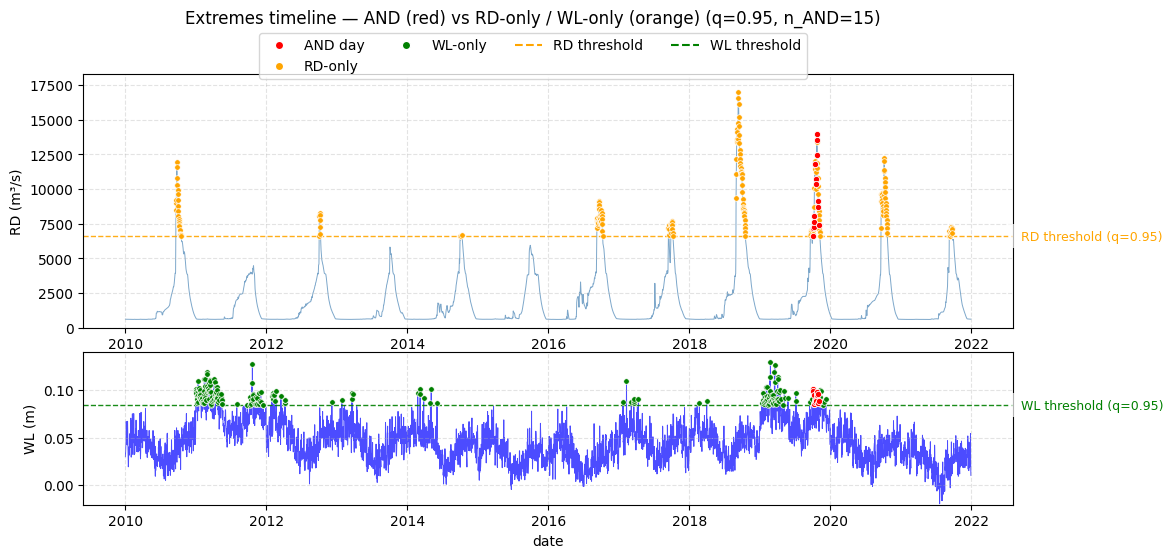

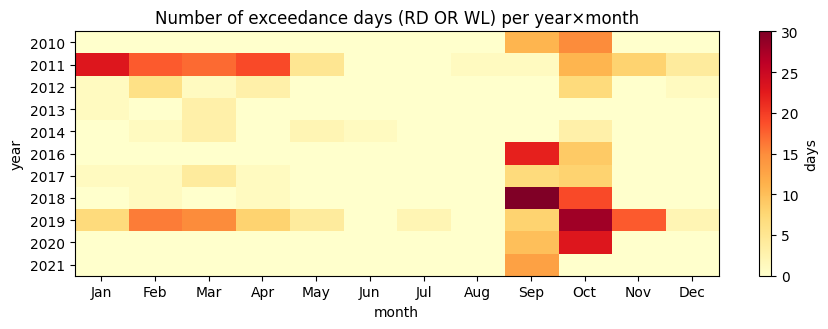

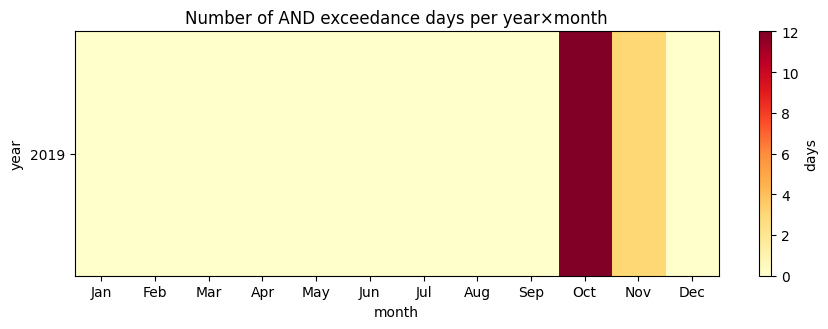

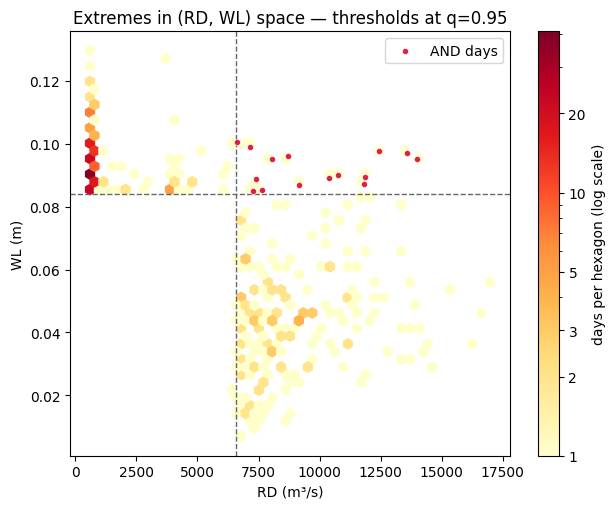

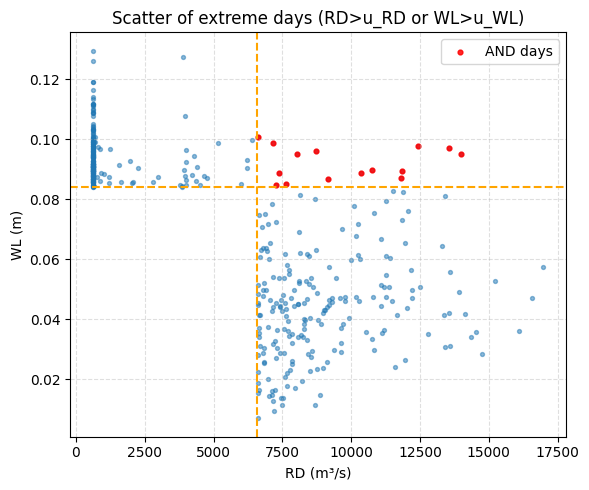

In [213]:
# ==============================================================
# 1) EXPLORATORY / DESCRIPTIVE
#    1a) Time series with thresholds & AND markers
#    1b) Seasonal heatmap of AND counts
#    1c) Scatter / Hexbin of extremes
# ==============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, pearsonr

q = 0.95
u_RD = float(alignedQW["RD"].quantile(q))
u_WL = float(alignedQW["WL"].quantile(q))
m_AND   = (alignedQW["RD"]>u_RD) & (alignedQW["WL"]>u_WL)
m_union = (alignedQW["RD"]>u_RD) | (alignedQW["WL"]>u_WL)

# -------------------------------------------------
# (1a) timeline with thresholds + AND-day markers
# -------------------------------------------------

# masks
and_mask = (alignedQW["RD"] > u_RD) & (alignedQW["WL"] > u_WL)
rd_only  = (alignedQW["RD"] > u_RD) & ~(alignedQW["WL"] > u_WL)
wl_only  = (alignedQW["WL"] > u_WL) & ~(alignedQW["RD"] > u_RD)

# data
rd = alignedQW["RD"]; wl = alignedQW["WL"]; dates = alignedQW.index

def annotate_hline(ax, y, label, color):
    ax.axhline(y, ls="--", lw=1, color=color, alpha=0.9, zorder=1)
    xr = ax.get_xlim()[1]
    ax.text(xr, y, f"  {label}", va="center", ha="left", fontsize=9, color=color,
            bbox=dict(fc="white", ec="none", alpha=0.7))

fig = plt.figure(figsize=(12, 5.6))
gs = fig.add_gridspec(2, 1, height_ratios=[2.0, 1.2], hspace=0.12)
ax1 = fig.add_subplot(gs[0, 0])  # RD
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)     # WL

# ---- RD panel ----
ax1.plot(dates, rd, lw=0.7, color='steelblue', alpha=0.7, label="RD (raw)", zorder=1)
# RD-only (orange) and AND (red)
ax1.scatter(dates[rd_only], rd[rd_only], s=16, color='orange', edgecolor="white",
            linewidths=0.5, zorder=3, label="RD-only day")
ax1.scatter(dates[and_mask], rd[and_mask], s=20, color='red', edgecolor="white",
            linewidths=0.6, zorder=4, label="AND day")
annotate_hline(ax1, u_RD, f"RD threshold (q={q:.2f})", color='orange')
ax1.set_ylabel("RD (m³/s)")
ax1.grid(True, ls="--", alpha=0.35)
ax1.set_ylim(bottom=0, top=np.nanmax(rd)*1.08)

# ---- WL panel ----
ax2.plot(dates, wl, lw=0.7, color='blue', alpha=0.7, label="WL (raw)", zorder=1)
ax2.scatter(dates[wl_only], wl[wl_only], s=16, color='green', edgecolor="white",
            linewidths=0.5, zorder=3, label="WL-only day")
ax2.scatter(dates[and_mask], wl[and_mask], s=20, color='red', edgecolor="white",
            linewidths=0.6, zorder=4, label="AND day")
annotate_hline(ax2, u_WL, f"WL threshold (q={q:.2f})", 'green')
ax2.set_ylabel("WL (m)"); ax2.set_xlabel("date")
ax2.grid(True, ls="--", alpha=0.35)
ax2.set_ylim(bottom=min(0, np.nanmin(wl)*1.05), top=np.nanmax(wl)*1.08)

# ---- Title + legend ----
fig.suptitle(
    f"Extremes timeline — AND (red) vs RD-only / WL-only (orange) (q={q:.2f}, n_AND={int(and_mask.sum())})",
    y=0.995, fontsize=12
)

handles = [
    plt.Line2D([], [], marker='o', linestyle='None', markersize=6, color='red',
               markeredgecolor="white", label="AND day"),
    plt.Line2D([], [], marker='o', linestyle='None', markersize=6, color='orange',
               markeredgecolor="white", label="RD-only"),
    plt.Line2D([], [], marker='o', linestyle='None', markersize=6, color='green',
               markeredgecolor="white", label="WL-only"),
    plt.Line2D([], [], ls="--", color='orange', label="RD threshold"),
    plt.Line2D([], [], ls="--", color='green', label="WL threshold"),
]
fig.legend(handles=handles, loc="upper center", ncol=4, frameon=True, bbox_to_anchor=(0.5, 0.965))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

# --------------------------------------------
# (1b) Seasonal heatmap of OR + AND-day counts
# --------------------------------------------
# OR counts
if m_AND.any():
    tab = (alignedQW[m_union]
           .assign(year=lambda d: d.index.year, month=lambda d: d.index.month)
           .groupby(["year","month"]).size().unstack(fill_value=0)
           .reindex(columns=range(1,13), fill_value=0))  # ensure all months present

    month_labels = [calendar.month_abbr[m] for m in range(1,13)]

    fig, ax = plt.subplots(figsize=(9,3.4))
    im = ax.imshow(tab.values, aspect="auto", origin="upper", cmap="YlOrRd")  # <-- palette here

    ax.set_yticks(range(tab.shape[0]))
    ax.set_yticklabels(tab.index)

    ax.set_xticks(range(12))
    ax.set_xticklabels(month_labels)

    ax.set_xlabel("month"); ax.set_ylabel("year")
    ax.set_title("Number of exceedance days (RD OR WL) per year×month")
    plt.colorbar(im, ax=ax, label="days")
    plt.tight_layout(); plt.show()

# AND counts
if m_AND.any():
    tab = (alignedQW[m_AND]
           .assign(year=lambda d: d.index.year, month=lambda d: d.index.month)
           .groupby(["year","month"]).size().unstack(fill_value=0)
           .reindex(columns=range(1,13), fill_value=0))  # ensure all months present

    month_labels = [calendar.month_abbr[m] for m in range(1,13)]

    fig, ax = plt.subplots(figsize=(9,3.4))
    im = ax.imshow(tab.values, aspect="auto", origin="upper", cmap="YlOrRd")  # <-- palette here

    ax.set_yticks(range(tab.shape[0]))
    ax.set_yticklabels(tab.index)

    ax.set_xticks(range(12))
    ax.set_xticklabels(month_labels)

    ax.set_xlabel("month"); ax.set_ylabel("year")
    ax.set_title("Number of AND exceedance days per year×month")
    plt.colorbar(im, ax=ax, label="days")
    plt.tight_layout(); plt.show()

# --------------------------------------------
# (1c) Joint space views for extremes (union)
# --------------------------------------------
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker

ext = alignedQW[m_union]; both = alignedQW[m_AND]

# --- HEXBIN with AND overlay ---
plt.figure(figsize=(6.4, 5.2))
hb = plt.hexbin(
    ext["RD"], ext["WL"],
    gridsize=45, mincnt=1,
    cmap="YlOrRd", norm=LogNorm()   # log scale makes dense bins visible
)
plt.axvline(u_RD, ls="--", color="0.4", lw=1)
plt.axhline(u_WL, ls="--", color="0.4", lw=1)

plt.scatter(
    both["RD"], both["WL"],
    s=20, color="crimson", alpha=0.95,
    edgecolor="white", linewidths=0.5, zorder=3, label="AND days"
)

# Colorbar with integer day counts
arr = hb.get_array()
vmax = int(np.nanmax(arr)) if arr.size else 1
tick_values = [v for v in [1,2,3,5,10,20,50,100,200,500,1000] if v <= vmax]
cb = plt.colorbar(hb)
cb.set_label("days per hexagon (log scale)")
if tick_values:
    cb.set_ticks(tick_values)
    cb.set_ticklabels([str(v) for v in tick_values])

plt.xlabel("RD (m³/s)")
plt.ylabel("WL (m)")
plt.title(f"Extremes in (RD, WL) space — thresholds at q={q:.2f}")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()


# --- PLAIN SCATTER of union extremes + AND overlay ---
plt.figure(figsize=(6,5))
plt.scatter(ext["RD"], ext["WL"], s=8, alpha=0.5)
plt.scatter(both["RD"], both["WL"], s=12, alpha=0.85, color= 'r', label="AND days")
plt.axvline(u_RD, ls="--", color= 'orange'); plt.axhline(u_WL, ls="--", color='orange')
plt.xlabel("RD (m³/s)"); plt.ylabel("WL (m)")
plt.title("Scatter of extreme days (RD>u_RD or WL>u_WL)")
plt.legend()
plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()


In [222]:
# ==============================================================
# 2) CLASSICAL CORRELATION + BLOCK-BOOTSTRAP CIs
#    - Spearman, Kendall, Pearson(log)
# ==============================================================

# Block bootstrap (resampling with serial dependence preserved)
def _corr_value(res):
    """Handle SciPy versions uniformly:
        spearmanr/kendalltau may return tuple-like or an object with .correlation/.statistic."""
    if hasattr(res, "correlation"):
        return float(res.correlation)
    if hasattr(res, "statistic"):
        return float(res.statistic)
    try:
        return float(res[0])
    except Exception:
        return np.nan

def pseudo_obs(x):
    r = pd.Series(x).rank(method="average").to_numpy()
    n = np.isfinite(x).sum()
    return r / (n + 1.0)

def acf1(x):
    """Lag-1 autocorrelation with guards for short/constant series."""
    x = np.asarray(x, float)
    if x.size < 2:
        return 0.0
    x = x - np.nanmean(x)
    if np.nanstd(x) == 0:
        return 0.0
    r = np.corrcoef(x[:-1], x[1:])[0, 1]
    return 0.0 if not np.isfinite(r) else float(r)

def suggest_block_len(x, y, min_b=5, max_b=30):
    """
    Suggest block length for block bootstrap:
    - Based on average lag-1 autocorrelation of RD and WL.
    - Higher autocorrelation ⇒ longer blocks needed.
    - Constrained between min_b and max_b.
    """
    # heuristic grows with persistence
    r = max(0.0, (acf1(x) + acf1(y)) / 2.0)
    b = int(np.round(2.0 / (1.0 - r + 1e-6)))
    return int(np.clip(b, min_b, max_b))

def circular_block_bootstrap_idx(n, block_len=7, B=500, rng=None):
    """
    Circular block bootstrap resampling indices.
    - Draw k blocks of length 'block_len' to cover the time series.
    - Wrap around at end of series (circular).
    - Produces B bootstrap replicates of length n.
    """
    if rng is None:
        rng = np.random.default_rng(42)
    n = int(n)
    block_len = int(max(1, min(block_len, n)))
    k = int(np.ceil(n / block_len))
    idxs = []
    for _ in range(B):
        starts = rng.integers(0, n, size=k)
        idx = np.concatenate([ (np.arange(s, s + block_len) % n) for s in starts ])[:n]
        idxs.append(idx)
    return idxs

def _ci(a):
    a = np.asarray(a, float)
    if a.size == 0 or not np.isfinite(a).any():
        return [np.nan, np.nan]
    return list(np.nanpercentile(a, [2.5, 97.5]))

def _pearson_log_safe(x, y):
    """Pearson on log1p with guards for NaN/inf and constant series."""
    lx = np.log1p(np.asarray(x, dtype=float))
    ly = np.log1p(np.asarray(y, dtype=float))
    m = np.isfinite(lx) & np.isfinite(ly)
    lx, ly = lx[m], ly[m]
    if lx.size < 2:
        return np.nan
    if np.nanstd(lx) == 0 or np.nanstd(ly) == 0:
        return np.nan
    try:
        return float(pearsonr(lx, ly)[0])
    except Exception:
        return np.nan

def _pearson_log_safe_boot(xb, yb):
    return _pearson_log_safe(xb, yb)

# Correlation metrics
def corr_and_ci(df, q=0.95, B=500, block_len=None, random_state=42, rd_col="RD", wl_col="WL"):
    """
    Returns a DataFrame with:
      - Spearman (all), Kendall (all), Pearson(log) (all)
      - Same 3 metrics on Union exceed (q=...), AND exceed (q=...) if n>=10
    Columns: metric, estimate, lo95, hi95, n
    """
    # Resolve column names case-insensitively
    cols_lower = {c.lower(): c for c in df.columns}
    if rd_col.lower() not in cols_lower or wl_col.lower() not in cols_lower:
        raise ValueError(f"df must contain columns '{rd_col}' and '{wl_col}' (case-insensitive). "
                         f"Got: {list(df.columns)}")
    RD = cols_lower[rd_col.lower()]
    WL = cols_lower[wl_col.lower()]

    # Extract arrays
    x = df[RD].to_numpy(dtype=float)
    y = df[WL].to_numpy(dtype=float)

    # Base block length
    if block_len is None:
        block_len = suggest_block_len(x, y)

    rng = np.random.default_rng(random_state)

    # ---------- full sample ----------
    idxs = circular_block_bootstrap_idx(len(x), block_len, B, rng)
    rho  = _corr_value(spearmanr(x, y, nan_policy="omit"))
    tau  = _corr_value(kendalltau(x, y, nan_policy="omit"))
    rlin = _pearson_log_safe(x, y)

    rho_b, tau_b, rlin_b = [], [], []
    for idx in idxs:
        xb, yb = x[idx], y[idx]
        rho_b.append(_corr_value(spearmanr(xb, yb, nan_policy="omit")))
        tau_b.append(_corr_value(kendalltau(xb, yb, nan_policy="omit")))
        rlin_b.append(_pearson_log_safe_boot(xb, yb))

    out = []
    out.append(["Spearman rho (all)",    rho,  *_ci(rho_b),  len(x)])
    out.append(["Kendall tau (all)",     tau,  *_ci(tau_b),  len(x)])
    out.append(["Pearson r log (all)",   rlin, *_ci(rlin_b), len(x)])

    # ---------- exceedances ----------
    u_RD = float(df[RD].quantile(q))
    u_WL = float(df[WL].quantile(q))
    mask_union = (df[RD] > u_RD) | (df[WL] > u_WL)
    mask_and   = (df[RD] > u_RD) & (df[WL] > u_WL)

    for label, m in [(f"Union exceed (q={q:.2f})", mask_union),
                     (f"AND exceed (q={q:.2f})",   mask_and)]:
        sub = df.loc[m, [RD, WL]]
        n_sub = len(sub)
        if n_sub >= 10:
            sx = sub[RD].to_numpy(float)
            sy = sub[WL].to_numpy(float)

            # Point estimates
            rho  = _corr_value(spearmanr(sx, sy, nan_policy="omit"))
            tau  = _corr_value(kendalltau(sx, sy, nan_policy="omit"))
            rlin = _pearson_log_safe(sx, sy)

            # Block length for subset
            b_sub = min(suggest_block_len(sx, sy), n_sub)
            idxs_sub = circular_block_bootstrap_idx(n_sub, b_sub, B, rng)

            rho_b, tau_b, rlin_b = [], [], []
            for idx in idxs_sub:
                xb, yb = sx[idx], sy[idx]
                rho_b.append(_corr_value(spearmanr(xb, yb, nan_policy="omit")))
                tau_b.append(_corr_value(kendalltau(xb, yb, nan_policy="omit")))
                rlin_b.append(_pearson_log_safe_boot(xb, yb))

            out.append([f"Spearman rho ({label})", rho,  *_ci(rho_b),  n_sub])
            out.append([f"Kendall tau  ({label})",  tau,  *_ci(tau_b),  n_sub])
            out.append([f"Pearson r log ({label})", rlin, *_ci(rlin_b), n_sub])

    return pd.DataFrame(out, columns=["metric","estimate","lo95","hi95","n"])

# ---- usage ----
# df = alignedQW.dropna()[["RD","WL"]].copy()
corr_tbl = corr_and_ci(alignedQW, q=0.95, B=600, rd_col="RD", wl_col="WL")
display(corr_tbl)


metric  estimate      lo95      hi95     n
0                     Spearman rho (all) -0.214773 -0.315238 -0.101617  4383
1                      Kendall tau (all) -0.140350 -0.204338 -0.067315  4383
2                    Pearson r log (all) -0.126264 -0.232502 -0.008320  4383
3   Spearman rho (Union exceed (q=0.95)) -0.692725 -0.761582 -0.510314   424
4   Kendall tau  (Union exceed (q=0.95)) -0.460757 -0.525091 -0.321931   424
5  Pearson r log (Union exceed (q=0.95)) -0.762069 -0.880994 -0.624546   424
6     Spearman rho (AND exceed (q=0.95))  0.071429 -0.628865  0.710454    15
7     Kendall tau  (AND exceed (q=0.95))  0.104762 -0.460000  0.500000    15
8    Pearson r log (AND exceed (q=0.95))  0.048047 -0.494754  0.693120    15


To remove marginal effects and focus on dependence, raw values are transformed into pseudo-observations using the empirical probability integral transform, i.e., ranks scaled by sample size (r/(n+1)) as in Bevacqua et al., 2019.

This code sets up a block bootstrap: a procedure adapted for serially dependent data (such as time series) to construct confidence intervals of tail dependence metrics. Both Gilleland (2020) and Wilks (2011) discuss block bootstrap methods in the context of dependent (time‐correlated) atmospheric data. They specified the importance of this technique, as standard i.i.d. bootstrap assumes independence, which is violated in time series with autocorrelation. Here, the Circular Block Bootstrap is implemented, ansuring every index is elegible. 

[block length] Wilks τ-average → b = 30
       u    chi  chi_lo  chi_hi  chibar  chibar_lo  chibar_hi  lambda_sym  \
0   0.80  0.167   0.074   0.271  -0.054     -0.250      0.133       0.167   
1   0.81  0.163   0.072   0.265  -0.044     -0.248      0.144       0.163   
2   0.82  0.157   0.065   0.260  -0.038     -0.251      0.155       0.157   
3   0.83  0.153   0.057   0.262  -0.029     -0.258      0.168       0.153   
4   0.84  0.152   0.054   0.268  -0.013     -0.260      0.193       0.152   
5   0.85  0.155   0.055   0.279   0.009     -0.239      0.219       0.155   
6   0.86  0.155   0.052   0.280   0.026     -0.222      0.245       0.155   
7   0.87  0.144   0.047   0.263   0.026     -0.223      0.242       0.144   
8   0.88  0.129   0.037   0.246   0.018     -0.245      0.219       0.129   
9   0.89  0.104   0.016   0.217  -0.013     -0.330      0.192       0.104   
10  0.90  0.096   0.007   0.206  -0.009     -0.368      0.202       0.096   
11  0.91  0.086   0.004   0.198  -0.

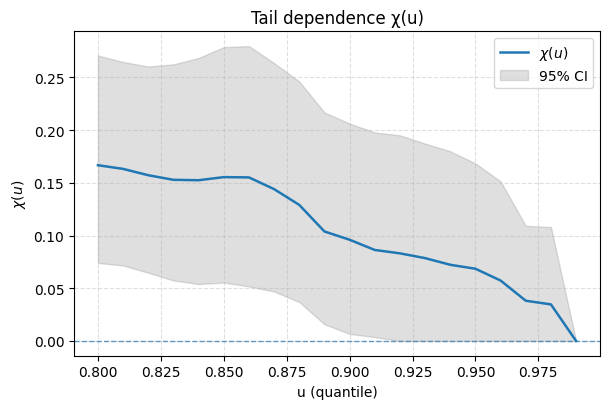

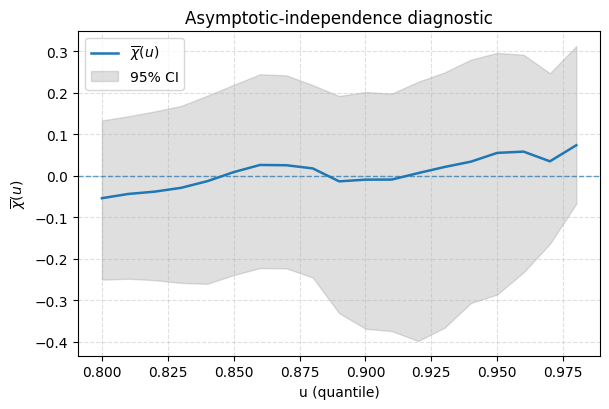

[INFO] Ledford–Tawn η = 0.574  (95% CI [0.149, 0.778])


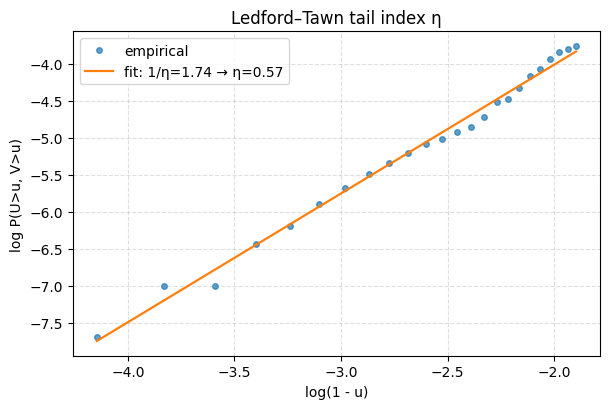

In [227]:
# ==============================================================
# 3) TAIL DEPENDENCE DIAGNOSTICS
#    - Pseudo-observations → χ(u), \bar{χ}(u)
#    - Finite-λ(u) curves & Ledford–Tawn η
#    - Bootstrap CIs (block)
# ==============================================================

# ---- sane defaults ----
B = 600                 # bootstrap reps
min_block = 5
max_block = 30
rng = np.random.default_rng(42)

# ---- helpers reused from correlation section (safe versions) ----
def _acf_1d(x, max_lag=None):
    """
    Unbiased sample ACF up to max_lag (default ~ n/4), with guards.
    Returns array r where r[0]=1, r[k]=Corr(x_t, x_{t-k}).
    """
    x = np.asarray(x, float)
    n = x.size
    if n < 3 or np.all(~np.isfinite(x)):
        return np.array([1.0])
    x = x - np.nanmean(x)
    # replace remaining NaNs (if any) with 0 so dot products work
    x = np.where(np.isfinite(x), x, 0.0)
    var = np.dot(x, x) / (n - 1) if n > 1 else 0.0
    if var <= 0:
        return np.array([1.0])
    if max_lag is None:
        max_lag = max(1, int(np.floor(n / 4)))
    max_lag = min(max_lag, n - 2)

    acf = [1.0]
    for k in range(1, max_lag + 1):
        num = np.dot(x[:-k], x[k:]) / (n - k)
        acf.append(num / var)
    return np.array(acf, float)

def _integral_time_scale_from_acf(acf_vals, zero_cross="first", keep_nonneg=True):
    """
    Compute integral time scale tau = 1 + 2 * sum_{k>=1} rho(k),
    summing until first zero-crossing (Wilks) or over nonnegative rhos.
    """
    if acf_vals.size <= 1:
        return 1.0
    r = acf_vals[1:]  # exclude lag 0
    if zero_cross == "first":
        pos = np.where(r > 0)[0]
        if len(pos) == 0:
            s = 0.0
        else:
            last_pos_idx = pos[-1]
            s = np.sum(r[: last_pos_idx + 1])
    else:
        s = np.sum(r[r > 0]) if keep_nonneg else np.sum(r)
    tau = 1.0 + 2.0 * max(0.0, s)
    return float(tau)

def suggest_block_len_wilks(x, y, min_b=5, max_b=30, max_lag=None, zero_cross="first"):
    """
    Wilks-style block length via integral time scale (correlation length).
    """
    acf_x = _acf_1d(x, max_lag=max_lag)
    acf_y = _acf_1d(y, max_lag=max_lag)
    tau_x = _integral_time_scale_from_acf(acf_x, zero_cross=zero_cross)
    tau_y = _integral_time_scale_from_acf(acf_y, zero_cross=zero_cross)
    tau_avg = np.nanmean([tau_x, tau_y])
    b = int(np.rint(tau_avg))
    return int(np.clip(max(1, b), min_b, max_b))

def circular_block_bootstrap_idx(n, block_len, B, rng=None):
    """Return list of index arrays (length n) for circular block bootstrap."""
    if rng is None:
        rng = np.random.default_rng(42)
    n = int(n)
    block_len = int(max(1, min(block_len, n)))  # 1 ≤ b ≤ n
    k = int(np.ceil(n / block_len))
    idxs = []
    for _ in range(B):
        starts = rng.integers(0, n, size=k)
        idx = np.concatenate([(np.arange(s, s + block_len) % n) for s in starts])[:n]
        idxs.append(idx)
    return idxs

def ci_from_boot(a, alpha=0.05):
    a = np.asarray(a, float)
    if a.size == 0 or not np.isfinite(a).any():
        return [np.nan, np.nan]
    return list(np.nanpercentile(a, [100*alpha/2, 100*(1-alpha/2)]))

# ---- pseudo-observations (ranks/(n+1)) ----
def to_pseudo_obs(x):
    """Map margins to U(0,1) via empirical PIT (ranks/(n+1))."""
    x = pd.Series(x).astype(float)
    r = x.rank(method="average")
    return (r / (len(x) + 1.0)).to_numpy()

U = to_pseudo_obs(alignedQW['RD'])
V = to_pseudo_obs(alignedQW['WL'])

# ---- tail stats ----
def count_joint_exceed(U, V, u):
    maskU = U > u; maskV = V > u
    nUV = int(np.sum(maskU & maskV))
    nU  = int(np.sum(maskU))
    nV  = int(np.sum(maskV))
    return nUV, nU, nV

def chi_emp(U, V, u):
    nUV, nU, nV = count_joint_exceed(U, V, u)
    a = (nUV / nV) if nV > 0 else np.nan  # P(U>u | V>u)
    b = (nUV / nU) if nU > 0 else np.nan  # P(V>u | U>u)
    return np.nanmean([a, b])

def chi_bar_emp(U, V, u):
    n = len(U)
    nUV = int(np.sum((U > u) & (V > u)))
    pUV = nUV / n if n > 0 else np.nan
    if not np.isfinite(pUV) or pUV <= 0:
        return np.nan
    if u >= 1.0:
        return np.nan
    with np.errstate(divide='ignore', invalid='ignore'):
        val = 2*np.log(1 - u) / np.log(pUV) - 1
    return float(val) if np.isfinite(val) else np.nan

def lambda_U_emp(U, V, u):
    nUV, nU, nV = count_joint_exceed(U, V, u)
    lam1 = (nUV / nV) if nV > 0 else np.nan   # P(U>u | V>u)
    lam2 = (nUV / nU) if nU > 0 else np.nan   # P(V>u | U>u)
    return lam1, lam2, np.nanmean([lam1, lam2])

# ---- bootstrap indices (now using Wilks selector) ----
x = alignedQW['RD'].to_numpy()
y = alignedQW['WL'].to_numpy()
blk = suggest_block_len_wilks(x, y, min_b=min_block, max_b=max_block)   # <- Wilks-aligned
print(f"[block length] Wilks τ-average → b = {blk}")
idxs_tail = circular_block_bootstrap_idx(len(DATA), blk, B, rng=rng)

def boot_stat(U, V, func, u):
    out = []
    for idx in idxs_tail:
        out.append(func(U[idx], V[idx], u))
    return np.array(out, float)

# ---- grid evaluation ----
u_grid = np.linspace(0.80, 0.99, 20)

rows = []
for u in u_grid:
    chi_hat    = chi_emp(U, V, u)
    chibar_hat = chi_bar_emp(U, V, u)
    lam1, lam2, lam_sym = lambda_U_emp(U, V, u)

    chi_b        = boot_stat(U, V, chi_emp, u)
    chibar_b     = boot_stat(U, V, chi_bar_emp, u)
    lam_b        = boot_stat(U, V, lambda U2, V2, u2: lambda_U_emp(U2, V2, u2)[2], u)

    chi_lo, chi_hi         = ci_from_boot(chi_b)
    chibar_lo, chibar_hi   = ci_from_boot(chibar_b)
    lam_lo, lam_hi         = ci_from_boot(lam_b)

    rows.append([u, chi_hat, chi_lo, chi_hi,
                 chibar_hat, chibar_lo, chibar_hi,
                 lam_sym, lam_lo, lam_hi, lam1, lam2])

tail_tbl = pd.DataFrame(rows, columns=[
    "u","chi","chi_lo","chi_hi",
    "chibar","chibar_lo","chibar_hi",
    "lambda_sym","lambda_lo","lambda_hi",
    "lambda_U|V","lambda_V|U"
])

print(tail_tbl.round(3))

# ---- plots ----
plt.figure(figsize=(6.2,4.2))
plt.plot(tail_tbl["u"], tail_tbl["chi"], lw=1.8, label=r"$\chi(u)$")
plt.fill_between(tail_tbl["u"], tail_tbl["chi_lo"], tail_tbl["chi_hi"], color='grey', alpha=0.25, label="95% CI")
plt.axhline(0, ls="--", lw=1, alpha=0.7)
plt.xlabel("u (quantile)"); plt.ylabel(r"$\chi(u)$")
plt.title("Tail dependence χ(u)"); plt.grid(True, ls="--", alpha=0.4)
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.2,4.2))
plt.plot(tail_tbl["u"], tail_tbl["chibar"], lw=1.8, label=r"$\overline{\chi}(u)$")
plt.fill_between(tail_tbl["u"], tail_tbl["chibar_lo"], tail_tbl["chibar_hi"], color='grey', alpha=0.25, label="95% CI")
plt.axhline(0, ls="--", lw=1, alpha=0.7)
plt.xlabel("u (quantile)"); plt.ylabel(r"$\overline{\chi}(u)$")
plt.title("Asymptotic-independence diagnostic"); plt.grid(True, ls="--", alpha=0.4)
plt.legend(); plt.tight_layout(); plt.show()

# ---- Ledford–Tawn η ----
u_fit = np.linspace(0.85, 0.99, 25)
n = len(U)
p_joint = np.array([np.sum((U > u) & (V > u)) / n for u in u_fit], float)
mask = (p_joint > 0) & np.isfinite(p_joint)

X = np.log(1 - u_fit[mask])
Y = np.log(p_joint[mask])
eta_hat = np.nan
slope = np.nan
intercept = np.nan

if np.isfinite(X).all() and np.isfinite(Y).all() and X.size >= 2:
    slope, intercept = np.polyfit(X, Y, 1)
    eta_hat = (1.0 / slope) if slope != 0 else np.nan

eta_b = []
for idx in idxs_tail:
    Ub, Vb = U[idx], V[idx]
    pj = np.array([np.sum((Ub > u) & (Vb > u)) / len(Ub) for u in u_fit], float)
    m = (pj > 0) & np.isfinite(pj)
    Xb = np.log(1 - u_fit[m])
    Yb = np.log(pj[m])
    if Xb.size >= 2 and np.isfinite(Yb).all():
        sb, ib = np.polyfit(Xb, Yb, 1)
        if sb != 0 and np.isfinite(sb):
            eta_b.append(1.0 / sb)

eta_lo, eta_hi = ci_from_boot(eta_b)
print(f"[INFO] Ledford–Tawn η = {eta_hat:.3f}  (95% CI [{eta_lo:.3f}, {eta_hi:.3f}])")

plt.figure(figsize=(6.2,4.2))
if np.isfinite(slope):
    plt.plot(X, Y, 'o', ms=4, alpha=0.7, label="empirical")
    xx = np.linspace(np.min(X), np.max(X), 100)
    plt.plot(xx, slope*xx + intercept, lw=1.6, label=f"fit: 1/η={slope:.2f} → η={eta_hat:.2f}")
else:
    plt.plot([], [], label="insufficient nonzero joint probs")
plt.xlabel("log(1 - u)"); plt.ylabel("log P(U>u, V>u)")
plt.title("Ledford–Tawn tail index η"); plt.grid(True, ls="--", alpha=0.4); plt.legend()
plt.tight_layout(); plt.show()


### Multivariate and joint probability modeling
#### Copula-based approach
The copula approach, particularly Gaussian and t-copulas, allow to estiamte joint exceedance probabilities and bivariate return perios, when used with pseudo-observations (margins mapped to uniform ranks) and paired with POT-fitted marginals (Bevacqua et al. (2019), Zhang et al. (2021), Nelsen (2007), Vandenberghe et al. (2011), Sadegh et al. (2018)).


In [240]:
import copulas
print(copulas.__version__)
import copulas.bivariate as cb
print(dir(cb))
import statsmodels
print(statsmodels.__version__)

from statsmodels.distributions.copula.api import GaussianCopula, StudentTCopula, ClaytonCopula, FrankCopula, GumbelCopula


0.12.3
['Bivariate', 'COMPUTE_EMPIRICAL_STEPS', 'Clayton', 'CopulaTypes', 'EPSILON', 'Frank', 'Gumbel', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_compute_candidates', '_compute_empirical', '_compute_tail', 'base', 'clayton', 'frank', 'gumbel', 'np', 'pd', 'select_copula', 'split_matrix', 'utils']
0.14.5


c:\Users\aless\Desktop\tesi\SoC_master_thesis_git\.venv\Lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


family        loglik         AIC         BIC
0          Gaussian -8.881784e-14    2.000000    7.382124
1  Student-t(df=40) -5.861207e+00   15.722413   26.486662
2             Frank -1.818601e+02  365.720242  371.102367

[best copula] Gaussian
RD: u=6.6e+03, xi=-0.132, sigma=2.79e+03, n_exc=220, daily p>u=0.0502
WL: u=0.084, xi=-0.161, sigma=0.0116, n_exc=219, daily p>u=0.0500
[AND @ (RD=6.6e+03, WL=0.084)] p=2.508e-03 → T≈398.73 yrs  (u=0.950, v=0.950, C(u,v)=0.902, copula=Gaussian)


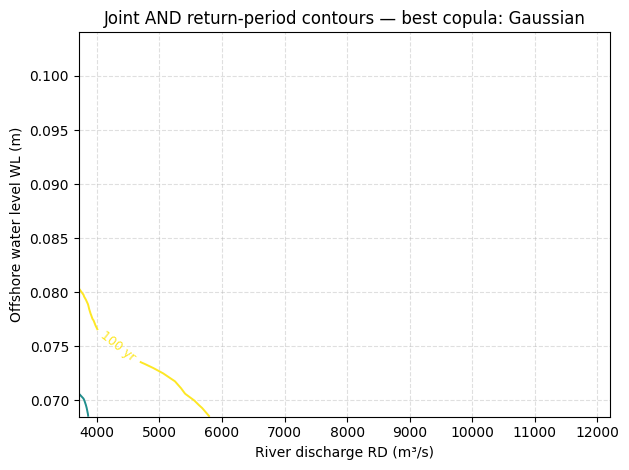

target           RD      WL     p_AND      T_years
0  q95 per-margin  6597.639062  0.0840  0.002508   398.727460
1  q98 per-margin  8814.505937  0.0941  0.000423  2366.487977

In [243]:
# ================================
# Bivariate EVA with Copulas (fixed Archimedean fit)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto, kendalltau

# Elliptical copulas from statsmodels
from statsmodels.distributions.copula.api import GaussianCopula, StudentTCopula

# Archimedean copulas from `copulas` package (v0.12.x)
from copulas.bivariate import Clayton, Gumbel, Frank

# ---------
# 0) INPUTS
# ---------
# Expect alignedQW with daily RD, WL (no NaNs)
df = alignedQW[['RD','WL']].dropna().copy()

# POT thresholds for marginals (use your diagnostics if you like)
q_marg = 0.95
u_RD = float(df['RD'].quantile(q_marg))
u_WL = float(df['WL'].quantile(q_marg))

# Focus the dependence fit on the upper mass (helps extremes)
q_dep = 0.80
mask_dep = (df['RD'] > df['RD'].quantile(q_dep)) | (df['WL'] > df['WL'].quantile(q_dep))

# -------------
# 1) PSEUDO-OBS
# -------------
def pseudo_obs_col(x: pd.Series) -> np.ndarray:
    r = x.rank(method="average")
    return (r / (len(x) + 1.0)).to_numpy()

U = pseudo_obs_col(df['RD'])
V = pseudo_obs_col(df['WL'])
UV_all = np.column_stack([U, V])
UV_fit = UV_all[mask_dep] if mask_dep.any() else UV_all

# --------------------------------------
# 2) FIT COPULAS (Gaussian, t, Clayton, Gumbel, Frank)
#    - SM for elliptical; copulas for Archimedean (avoids theta error)
# --------------------------------------
def _loglik_sm(cop, U):
    # statsmodels returns per-observation logpdf
    vals = cop.logpdf(U)
    return float(np.nansum(vals))

def _loglik_copulas(model, U):
    # copulas may have log_likelihood; else sum log(pdf)
    if hasattr(model, "log_likelihood"):
        return float(model.log_likelihood(U))
    # pdf may be named differently across versions
    if hasattr(model, "pdf"):
        dens = model.pdf(U)
    elif hasattr(model, "probability_density"):
        dens = model.probability_density(U)
    else:
        raise AttributeError("copulas model has no pdf/probability_density")
    dens = np.asarray(dens, float)
    return float(np.sum(np.log(np.maximum(dens, 1e-300))))

def _cdf_sm(cop, u, v):
    return float(cop.cdf(np.array([[u, v]])))

def _cdf_copulas(model, u, v):
    if hasattr(model, "cdf"):
        return float(model.cdf(np.array([[u, v]])))
    if hasattr(model, "cumulative_distribution"):
        return float(model.cumulative_distribution(np.array([[u, v]])))
    raise AttributeError("copulas model has no cdf/cumulative_distribution")

class ModelWrap:
    def __init__(self, name, k, kind, model):
        self.name = name      # string
        self.k = k            # number of free params used in AIC/BIC
        self.kind = kind      # 'sm' or 'copulas'
        self.model = model
    def loglik(self, U):
        return _loglik_sm(self.model, U) if self.kind=='sm' else _loglik_copulas(self.model, U)
    def cdf(self, u, v):
        return _cdf_sm(self.model, u, v) if self.kind=='sm' else _cdf_copulas(self.model, u, v)


def fit_all(UV):
    UV = np.asarray(UV, float)
    n = UV.shape[0]
    fits = []

    # sample Kendall's tau (guard for old/new scipy return types)
    kt = kendalltau(UV[:,0], UV[:,1])
    tau_hat = float(getattr(kt, "statistic", kt[0]))
    if not np.isfinite(tau_hat):
        tau_hat = 0.0

    # ---- Gaussian (ρ from τ) ----
    gc = GaussianCopula()
    gc.fit_corr_param(UV)
    fits.append(ModelWrap("Gaussian", k=1, kind='sm', model=gc))

    # ---- Student-t (grid df, ρ from τ) ----
    best_ll, best_wrap = -np.inf, None
    for dfc in [3,4,6,8,10,15,25,40]:
        tc = StudentTCopula(df=dfc)
        tc.fit_corr_param(UV)
        ll = _loglik_sm(tc, UV)
        if ll > best_ll:
            best_ll = ll
            best_wrap = ModelWrap(f"Student-t(df={dfc})", k=2, kind='sm', model=tc)
    fits.append(best_wrap)

    # ---- Archimedean via `copulas` (respect parameter domains) ----
    # Clayton: requires tau > 0 (theta > 0)
    if tau_hat > 0:
        try:
            m = Clayton()
            m.fit(UV)
            fits.append(ModelWrap("Clayton", k=1, kind='copulas', model=m))
        except Exception as e:
            print(f"[warn] Clayton skipped: {e}")

    # Gumbel: requires tau >= 0 (theta >= 1)
    if tau_hat >= 0:
        try:
            m = Gumbel()
            m.fit(UV)
            fits.append(ModelWrap("Gumbel", k=1, kind='copulas', model=m))
        except Exception as e:
            print(f"[warn] Gumbel skipped: {e}")

    # Frank: allows tau in (-1,1), ok for negative dependence
    try:
        m = Frank()
        m.fit(UV)
        fits.append(ModelWrap("Frank", k=1, kind='copulas', model=m))
    except Exception as e:
        print(f"[warn] Frank skipped: {e}")

    # ---- Score all successful fits ----
    rows = []
    for f in fits:
        ll = f.loglik(UV)
        aic = 2*f.k - 2*ll
        bic = f.k*np.log(n) - 2*ll
        rows.append([f.name, f.k, ll, aic, bic, f])

    if not rows:
        raise RuntimeError("No copula could be fitted to the provided data.")

    tbl = (pd.DataFrame(rows, columns=["family","k","loglik","AIC","BIC","_wrap"])
             .sort_values("AIC")
             .reset_index(drop=True))
    return tbl

fit_tbl = fit_all(UV_fit)
display(fit_tbl[["family","loglik","AIC","BIC"]])
best = fit_tbl.loc[0, "_wrap"]
print(f"[best copula] {best.name}")

# ------------------------------------------------------------
# 3) SEMI-PARAMETRIC MARGINALS (empirical below u + GPD above)
# ------------------------------------------------------------
def fit_gpd_daily(series: pd.Series, u: float):
    exc = (series[series > u] - u).astype(float).to_numpy()
    if exc.size < 10:
        raise ValueError(f"Too few exceedances ({exc.size}) above u={u:.3g} to fit GPD.")
    xi, loc, sigma = genpareto.fit(exc, floc=0.0)
    return float(xi), float(sigma), exc.size

def make_semiparam_cdf(series: pd.Series, u: float, xi: float, sigma: float):
    x = np.asarray(series, float)
    N = x.size
    p_u = float(np.mean(x > u))  # daily exceedance prob
    xb = np.sort(x[x <= u])

    def gpd_cdf(y):
        y = np.asarray(y, float)
        y = np.maximum(y, 0.0)
        if abs(xi) < 1e-10:
            return 1.0 - np.exp(-y/np.maximum(sigma, 1e-12))
        arg = 1.0 + xi*y/np.maximum(sigma, 1e-12)
        arg = np.maximum(arg, 1e-12)
        return 1.0 - arg**(-1.0/xi)

    def F(q):
        q = np.asarray(q, float)
        F_emp = np.searchsorted(xb, q, side='right') / N
        above = q > u
        if np.any(above):
            F_emp[above] = 1.0 - p_u*(1.0 - gpd_cdf(q[above] - u))
        return F_emp

    return F, p_u

xi_RD, sig_RD, ne_RD = fit_gpd_daily(df['RD'], u_RD)
xi_WL, sig_WL, ne_WL = fit_gpd_daily(df['WL'], u_WL)
F_RD, pRD_u = make_semiparam_cdf(df['RD'], u_RD, xi_RD, sig_RD)
F_WL, pWL_u = make_semiparam_cdf(df['WL'], u_WL, xi_WL, sig_WL)

print(f"RD: u={u_RD:.3g}, xi={xi_RD:.3g}, sigma={sig_RD:.3g}, n_exc={ne_RD}, daily p>u={pRD_u:.4f}")
print(f"WL: u={u_WL:.3g}, xi={xi_WL:.3g}, sigma={sig_WL:.3g}, n_exc={ne_WL}, daily p>u={pWL_u:.4f}")

# ----------------------------------------------------------------
# 4) JOINT EXCEEDANCE & BIVARIATE RETURN PERIOD (AND = both exceed)
# ----------------------------------------------------------------
def joint_exceed_prob(cop_wrap: ModelWrap, Fx, Fy, x_star, y_star):
    """P(X>x*, Y>y*) = 1 - F_X(x*) - F_Y(y*) + C(F_X(x*), F_Y(y*))"""
    u = float(Fx([x_star])[0])
    v = float(Fy([y_star])[0])
    Cuv = cop_wrap.cdf(u, v)
    p = max(1e-15, 1.0 - u - v + Cuv)
    return p, u, v, Cuv

def return_period_years(p_joint, sampling="daily"):
    return 1.0 / (p_joint * 365.25) if sampling.lower().startswith("day") else 1.0 / p_joint

# Example: joint RP at each margin’s 95th percentile
x_star = u_RD
y_star = u_WL
pAND, u_, v_, Cuv = joint_exceed_prob(best, F_RD, F_WL, x_star, y_star)
T_AND = return_period_years(pAND, "daily")
print(f"[AND @ (RD={x_star:.3g}, WL={y_star:.3g})] p={pAND:.3e} → T≈{T_AND:.2f} yrs  "
      f"(u={u_:.3f}, v={v_:.3f}, C(u,v)={Cuv:.3f}, copula={best.name})")

# ----------------------------------------------------------------
# 5) (Optional) Joint RP contours over a high-quantile grid
# ----------------------------------------------------------------
q_grid = np.linspace(0.85, 0.995, 30)
x_grid = np.quantile(df['RD'], q_grid)
y_grid = np.quantile(df['WL'], q_grid)

TT = np.empty((len(y_grid), len(x_grid)))
for i, yv in enumerate(y_grid):
    for j, xv in enumerate(x_grid):
        p, *_ = joint_exceed_prob(best, F_RD, F_WL, xv, yv)
        TT[i, j] = return_period_years(p, "daily")

cs = plt.contour(x_grid, y_grid, TT, levels=[2,5,10,20,30,50,100], linewidths=1.4)
plt.clabel(cs, inline=True, fmt="%.0f yr", fontsize=9)
plt.xlabel("River discharge RD (m³/s)")
plt.ylabel("Offshore water level WL (m)")
plt.title(f"Joint AND return-period contours — best copula: {best.name}")
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

# -------------------------
# 6) Sensitivity table
# -------------------------
targets = [
    ("q95 per-margin", float(df['RD'].quantile(0.95)), float(df['WL'].quantile(0.95))),
    ("q98 per-margin", float(df['RD'].quantile(0.98)), float(df['WL'].quantile(0.98))),
]
rows = []
for name, xr, yw in targets:
    p, _, _, _ = joint_exceed_prob(best, F_RD, F_WL, xr, yw)
    rows.append([name, xr, yw, p, return_period_years(p, "daily")])
sens_tbl = pd.DataFrame(rows, columns=["target","RD","WL","p_AND","T_years"])
display(sens_tbl)


family        loglik       AIC        BIC  \
0   Gaussian -4.252154e-14  2.000000   6.726233   
1  Student-t -1.270292e+00  6.540583  15.993050   
2        BB1           NaN       NaN        NaN   

                                          info  
0            {'rho': [[1.0, 0.0], [0.0, 1.0]]}  
1  {'rho': [[1.0, 0.0], [0.0, 1.0]], 'df': 40}  
2        BB1 unavailable (pip install copulae)

[best by AIC] → Gaussian
      family        loglik       AIC        BIC  \
0   Gaussian -4.252154e-14  2.000000   6.726233   
1  Student-t -1.270292e+00  6.540583  15.993050   
2        BB1           NaN       NaN        NaN   

                                          info  
0            {'rho': [[1.0, 0.0], [0.0, 1.0]]}  
1  {'rho': [[1.0, 0.0], [0.0, 1.0]], 'df': 40}  
2        BB1 unavailable (pip install copulae)  
[best by AIC] → Gaussian

AND return period (capped at 50 yr) when both margins set to their univariate RL(T):
 Univ_T           Copula    RD_level  WL_level  AND_RP_capped
      2         Gaussian 6597.639065  0.084000           50.0
      2 Student-t(df=40) 6597.639065  0.084000           50.0
      5         Gaussian 6597.639065  0.084000           50.0
      5 Student-t(df=40) 6597.639065  0.084000           50.0
     10         Gaussian 6597.639065  0.084000           50.0
     10 Student-t(df=40) 6597.639065  0.084000           50.0
     20         Gaussian 6608

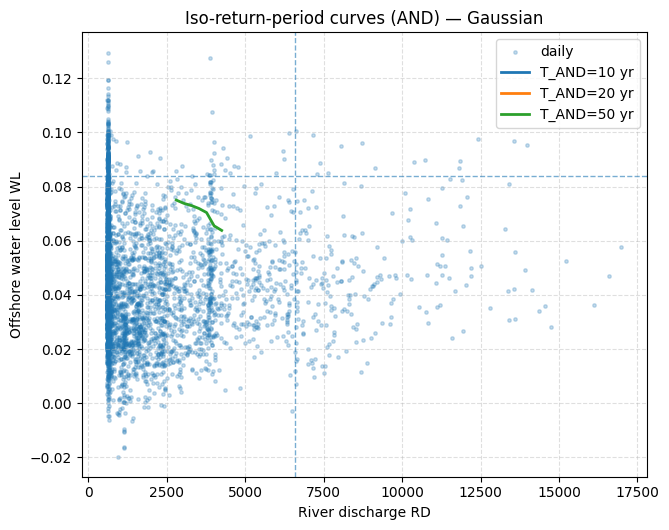

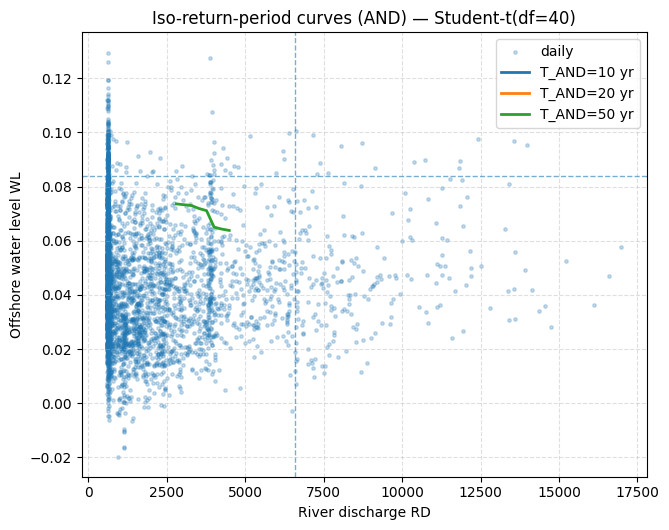


[notes]
• Marginals: semi-parametric (empirical below 95th pct; POT-GPD above).
• Dependence fitted on union exceedances (q_dep=0.90) to focus on the tail.
• BB1 fit uses copulae (method='mpl'); if unavailable, only Gaussian & Student-t are used.
• Joint AND return periods are capped to 50 years in the summaries and plots.
• To enable BB1:  pip install copulae   # then restart kernel and re-run.


In [246]:
# ============================================
# Bivariate EVA with Gaussian / t / BB1 copulas
# — Semi-parametric marginals (empirical + POT-GPD)
# — Joint exceedance & AND return periods (T ≤ 50 yr)
# ============================================

import numpy as np, pandas as pd
from dataclasses import dataclass
from typing import Optional, Tuple, Callable

# ---------- deps ----------
from scipy.stats import genpareto, kendalltau
from scipy.optimize import brentq
from scipy.stats import norm, t as t_dist, multivariate_normal

# Copulas: statsmodels (Gaussian, Student-t)
from statsmodels.distributions.copula.api import GaussianCopula, StudentTCopula

# Copulas: BB1 from copulae
try:
    from copulae.archimedean import BB1Copula
    HAS_BB1 = True
except Exception:
    HAS_BB1 = False

# ============================================
# 0) Safety checks
# ============================================
if not isinstance(alignedQW, pd.DataFrame) or not {'RD','WL'}.issubset(alignedQW.columns):
    raise ValueError("Expected `alignedQW` DataFrame with columns 'RD' and 'WL'.")

# Keep a clean daily, finite copy
DATA = alignedQW[['RD','WL']].dropna().copy()
DATA = DATA[np.isfinite(DATA.values).all(axis=1)]

# ============================================
# 1) Pseudo-observations (ranks/(n+1))
# ============================================
def pseudo_obs(x: pd.Series) -> np.ndarray:
    r = x.rank(method='average').to_numpy(dtype=float)
    n = np.isfinite(r).sum()
    return r / (n + 1.0)

# for fitting dependence (on a “high” subset by default)
def build_dep_sample(df: pd.DataFrame, q_dep: float = 0.90, mode: str = 'union') -> np.ndarray:
    u_RD = df['RD'].quantile(q_dep)
    u_WL = df['WL'].quantile(q_dep)
    if mode == 'and':
        m = (df['RD'] > u_RD) & (df['WL'] > u_WL)
    else:  # 'union'
        m = (df['RD'] > u_RD) | (df['WL'] > u_WL)
    sub = df.loc[m, ['RD','WL']]
    if len(sub) < 30:     # fallback if too small
        sub = df[['RD','WL']]
    U = pseudo_obs(sub['RD'])
    V = pseudo_obs(sub['WL'])
    return np.column_stack([U, V]), sub

UV_fit, SUB_DEP = build_dep_sample(DATA, q_dep=0.90, mode='union')

# ============================================
# 2) Semi-parametric marginal models
#    (empirical below threshold; POT-GPD above)
# ============================================
@dataclass
class SemiParamMarginal:
    values: np.ndarray            # full series (1D)
    threshold: float              # u
    c: float                      # GPD shape (xi)
    scale: float                  # GPD scale (sigma), loc fixed to 0
    p_exc: float                  # exceedance prob ~ N_exc/N
    N_below: int                  # count <= u
    vals_below_sorted: np.ndarray # sorted values ≤ u

    @classmethod
    def fit(cls, s: pd.Series, q_thr: float = 0.95) -> "SemiParamMarginal":
        x = pd.Series(s).dropna().to_numpy(dtype=float)
        u = float(np.quantile(x, q_thr))
        # empirical bits
        vals_below = x[x <= u]
        vals_below_sorted = np.sort(vals_below)
        N = x.size
        N_exc = int(np.sum(x > u))
        p_exc = N_exc / N if N > 0 else 0.0

        # POT-GPD fit on *exceedances* (no declustering here; you used declustering upstream for RLs)
        exc = x[x > u] - u
        if exc.size >= 5:
            c, loc, scale = genpareto.fit(exc, floc=0.0)  # MLE, loc=0 for excesses
        else:
            # fallback tiny-noise
            c, scale = 0.0, np.maximum(np.std(exc), 1e-6) if exc.size > 1 else 1e-3

        return cls(values=x, threshold=u, c=c, scale=float(scale),
                   p_exc=float(p_exc), N_below=vals_below_sorted.size,
                   vals_below_sorted=vals_below_sorted)

    # F(x): empirical below u (scaled), GPD tail above u
    def cdf(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, float)
        out = np.empty_like(x, dtype=float)
        below = x <= self.threshold
        above = ~below

        # below: scaled empirical CDF on values <= u
        if self.N_below > 0:
            # rank / N_below scaled to (1 - p_exc)
            ranks = np.searchsorted(self.vals_below_sorted, x[below], side='right')
            F_emp = ranks / self.N_below
            out[below] = (1.0 - self.p_exc) * F_emp
        else:
            out[below] = 0.0

        # above: 1 - p_exc * S_GPD(excess)
        if np.any(above):
            y = x[above] - self.threshold
            # survival of GPD with loc=0
            S = genpareto.sf(y, c=self.c, loc=0.0, scale=self.scale)
            out[above] = 1.0 - self.p_exc * S

        return np.clip(out, 1e-12, 1.0 - 1e-12)

    def sf(self, x: np.ndarray) -> np.ndarray:
        return 1.0 - self.cdf(x)

# Fit marginals (95% threshold by default)
marg_RD = SemiParamMarginal.fit(DATA['RD'], q_thr=0.95)
marg_WL = SemiParamMarginal.fit(DATA['WL'], q_thr=0.95)

# helper to map levels -> uniforms for a copula
def to_unit_square(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    return marg_RD.cdf(np.asarray(x, float)), marg_WL.cdf(np.asarray(y, float))

# ============================================
# 3) Copula fitting (Gaussian baseline, Student-t, BB1)
# ============================================
def loglik_sm(cop, U: np.ndarray) -> float:
    # per-observation logpdf from statsmodels
    vals = cop.logpdf(U)
    return float(np.sum(vals[np.isfinite(vals)]))

def fit_gaussian(UV: np.ndarray) -> Tuple[GaussianCopula, float, int]:
    gc = GaussianCopula()
    gc.fit_corr_param(UV)         # estimate rho from ranks
    ll = loglik_sm(gc, UV); k = 1 # rho
    return gc, ll, k

def fit_student_t(UV: np.ndarray, dfs=(3,4,6,8,10,15,25,40)) -> Tuple[StudentTCopula, float, int, int]:
    best = None; best_ll = -np.inf; best_df = None
    for df in dfs:
        tc = StudentTCopula(df=df)
        tc.fit_corr_param(UV)     # estimate rho
        ll = loglik_sm(tc, UV)
        if ll > best_ll:
            best, best_ll, best_df = tc, ll, df
    return best, best_ll, 2, best_df   # (rho, df)

def fit_bb1(UV: np.ndarray):
    """
    Fit BB1 (Clayton-Gumbel) via copulae if available.
    Returns (model, loglik, k, info_str) or (None, None, None, msg) if unavailable.
    """
    if not HAS_BB1:
        return None, None, None, "BB1 unavailable (pip install copulae)"
    try:
        bb = BB1Copula(dim=2)         # initialize; copulae uses dim, then fit
        bb.fit(UV, method='mpl')      # maximum pseudo-likelihood on uniforms
        # log-likelihood from pdf
        pdf = bb.pdf(UV)
        ll = float(np.sum(np.log(np.clip(pdf, 1e-300, None))))
        return bb, ll, 2, "ok"
    except Exception as e:
        return None, None, None, f"BB1 fit failed: {e}"

# Run fits
UV = UV_fit  # rename for brevity
n = UV.shape[0]

gc, ll_g, k_g = fit_gaussian(UV)
tc, ll_t, k_t, df_best = fit_student_t(UV)
bb1, ll_b, k_b, bb1_msg = fit_bb1(UV)

# --- helper to safely read the correlation from a statsmodels copula ---
def _get_corr(m):
    for attr in ("corr", "corr_param", "dep_params", "corr_matrix"):
        if hasattr(m, attr):
            return getattr(m, attr)
    return None

# rebuild the results table using safe accessors
rows = [
    ["Gaussian",  k_g, ll_g, 2*k_g - 2*ll_g, k_g*np.log(n) - 2*ll_g, gc, {"rho": _get_corr(gc)}],
    ["Student-t", k_t, ll_t, 2*k_t - 2*ll_t, k_t*np.log(n) - 2*ll_t, tc, {"rho": _get_corr(tc), "df": df_best}],
]
if bb1 is not None:
    rows.append(["BB1", k_b, ll_b, 2*k_b - 2*ll_b, k_b*np.log(n) - 2*ll_b, bb1, "fitted"])
else:
    rows.append(["BB1", np.nan, np.nan, np.nan, np.nan, None, bb1_msg])

fit_table = pd.DataFrame(rows, columns=["family","k","loglik","AIC","BIC","model","info"]).sort_values("AIC")
display(fit_table[["family","loglik","AIC","BIC","info"]])

best_family = fit_table.iloc[0]['family']
print(f"[best by AIC] → {best_family}")

# build the models dict for downstream (RP tables / iso-RP)
try:
    info_obj = fit_table.loc[fit_table.family=='Student-t', 'info'].values[0]
    df_label = info_obj.get('df') if isinstance(info_obj, dict) else getattr(tc, 'df', None)
except Exception:
    df_label = getattr(tc, 'df', None)

student_name = f"Student-t(df={df_label})" if df_label is not None else "Student-t"

models = {"Gaussian": gc, student_name: tc}
if bb1 is not None:
    models["BB1"] = bb1

fit_table = pd.DataFrame(rows, columns=["family","k","loglik","AIC","BIC","model","info"]).sort_values("AIC")
print(fit_table[["family","loglik","AIC","BIC","info"]])

best_family = fit_table.iloc[0]['family']
print(f"[best by AIC] →", best_family)

# ============================================
# 4) Joint exceedance prob & AND return period
#    P(X>x, Y>y) = 1 - u - v + C(u,v)
#    (Patched: add exact Gaussian CDF + cached MC Student-t CDF)
# ============================================
from scipy.stats import norm, t as t_dist, multivariate_normal

# ---- helpers to extract parameters from fitted copulas ----
def _extract_rho(model):
    """Best-effort extractor of the scalar correlation parameter."""
    for attr in ("rho", "corr", "corr_param", "dep_params", "corr_matrix", "corr_mat"):
        if hasattr(model, attr):
            val = getattr(model, attr)
            if val is None:
                continue
            arr = np.array(val, dtype=float)
            if arr.size == 1:
                return float(arr.ravel()[0])
            # 2x2 matrix form -> off-diagonal
            if arr.size == 4:
                return float(arr.reshape(2, 2)[0, 1])
    # last-resort: estimate from the fit sample (assumes UV global)
    try:
        tau = kendalltau(UV[:, 0], UV[:, 1])[0]
        if np.isfinite(tau):
            return float(np.sin(np.pi * tau / 2.0))  # tau ↔ rho for elliptical copulas
    except Exception:
        pass
    raise RuntimeError("Could not extract copula correlation parameter (rho).")

def _extract_df(model, default=6):
    """Pull degrees of freedom for Student-t. Fallback to a sane default."""
    for attr in ("df", "nu", "dof"):
        if hasattr(model, attr):
            v = getattr(model, attr)
            try:
                vv = int(v)
                if vv > 1:
                    return vv
            except Exception:
                pass
    return int(default)

# ---- exact CDF for Gaussian copula via bivariate normal ----
def _gaussian_copula_cdf(U, rho):
    U = np.asarray(U, float)
    Z = norm.ppf(np.clip(U, 1e-12, 1 - 1e-12))
    mvn = multivariate_normal(mean=[0.0, 0.0], cov=[[1.0, rho], [rho, 1.0]])
    return mvn.cdf(Z)

# ---- cached Monte-Carlo CDF for Student-t copula ----
_MC_CACHE = {}  # key = (round(rho,3), df, nsamples) -> (x1, x2) samples

def _get_mvt_samples(rho, df, nsamples=40000, seed=12345):
    key = (round(float(rho), 3), int(df), int(nsamples))
    if key in _MC_CACHE:
        return _MC_CACHE[key]
    rng = np.random.default_rng(seed)
    # sample from N(0, Sigma)
    L = np.linalg.cholesky(np.array([[1.0, rho], [rho, 1.0]], float))
    Z = rng.standard_normal(size=(nsamples, 2))
    Y = Z @ L.T
    # common scale sqrt(W/df), W ~ chi2(df)
    W = rng.chisquare(df, size=nsamples)
    scale = np.sqrt(W / df)[:, None]
    X = Y / scale  # ~ bivariate Student-t(df, correlation=rho)
    _MC_CACHE[key] = (X[:, 0], X[:, 1])
    return _MC_CACHE[key]

def _student_t_copula_cdf(U, rho, df, nsamples=40000):
    U = np.asarray(U, float)
    q = t_dist.ppf(np.clip(U, 1e-12, 1 - 1e-12), df)
    x1, x2 = _get_mvt_samples(rho, df, nsamples=nsamples)
    # For each (q1,q2) count proportion of samples ≤ thresholds
    # Vectorized via broadcasting
    le1 = (x1[:, None] <= q[:, 0][None, :])
    le2 = (x2[:, None] <= q[:, 1][None, :])
    C = (le1 & le2).mean(axis=0)
    return C

def copula_cdf(model, U: np.ndarray) -> np.ndarray:
    """
    Return C(u,v) for Nx2 uniforms.
    - Gaussian (statsmodels): exact using bivariate normal CDF
    - Student-t (statsmodels): MC approximate CDF (cached)
    - BB1 (copulae): use library .cdf
    """
    if model is None:
        return np.full(U.shape[0], np.nan)

    # Identify class by name to avoid tight imports
    cname = model.__class__.__name__.lower()

    if "gaussiancopula" in cname:
        rho = _extract_rho(model)
        return _gaussian_copula_cdf(U, rho).astype(float)

    if "studenttcopula" in cname or "student" in cname:
        rho = _extract_rho(model)
        df = _extract_df(model, default=6)
        return _student_t_copula_cdf(U, rho, df, nsamples=40000).astype(float)

    # copulae's BB1 (has native CDF)
    if hasattr(model, "cdf"):
        return np.asarray(model.cdf(U), dtype=float).ravel()

    raise TypeError("Unsupported copula for CDF computation.")

def joint_and_prob(x: np.ndarray, y: np.ndarray, model) -> np.ndarray:
    u, v = to_unit_square(x, y)
    U = np.column_stack([u, v])
    C = copula_cdf(model, U)
    pj = 1.0 - u - v + C
    return np.clip(pj, 0.0, 1.0)

def and_return_period_years(x: np.ndarray, y: np.ndarray, model) -> np.ndarray:
    p = joint_and_prob(x, y, model)
    with np.errstate(divide='ignore', invalid='ignore'):
        T = 1.0 / np.clip(p, 1e-12, None)
    return T

# ============================================
# 5) Univariate RLs for reporting (T ≤ 50 yr)
#    (quick POT formula using tail mass p_exc)
# ============================================
def univariate_RL_SP(marg: SemiParamMarginal, T: float) -> float:
    """
    Approximate univariate RL at return period T (years) using tail Poisson rate
    lambda_hat = (#exceeding days per year). Estimation:
      P(X > x_T) ≈ 1/T  →  p_exc * S_GPD(x_T - u) ≈ 1/T * (days_per_year / N_per_year)
    We approximate days_per_year/N_per_year = 1 (daily), so:
      S_GPD(y) ≈ 1 / (T * p_exc)
    """
    # guard
    p_tail = marg.p_exc
    if p_tail <= 0:
        return np.nan
    S = 1.0 / (T * p_tail)
    S = np.clip(S, 1e-9, 1-1e-9)
    # invert GPD survival at S: S = 1 - GPD_CDF(y)
    # so GPD_CDF(y) = 1 - S  →  y = genpareto.ppf(1-S, c, loc=0, scale=scale)
    y = genpareto.ppf(1.0 - S, c=marg.c, loc=0.0, scale=marg.scale)
    return marg.threshold + max(0.0, float(y))

T_list = [2, 5, 10, 20, 30, 50]
rl_RD = {T: univariate_RL_SP(marg_RD, T) for T in T_list}
rl_WL = {T: univariate_RL_SP(marg_WL, T) for T in T_list}

# ============================================
# 6) Table: AND return period for paired univariate RLs
# ============================================
def rp_table_for_pairs(models: dict, T_list):
    rows = []
    for T in T_list:
        x = rl_RD[T]; y = rl_WL[T]
        for name, mdl in models.items():
            RP = and_return_period_years(np.array([x]), np.array([y]), mdl)[0]
            RP = min(RP, 50.0)  # cap at 50 years as requested
            rows.append([T, name, x, y, RP])
    return pd.DataFrame(rows, columns=["Univ_T","Copula","RD_level","WL_level","AND_RP_capped"])

models = {
    "Gaussian": gc,
    f"Student-t(df={fit_table.loc[fit_table.family=='Student-t','info'].values[0]['df']})": tc,
}
if bb1 is not None:
    models["BB1"] = bb1

rp_pairs_tbl = rp_table_for_pairs(models, T_list)
print("\nAND return period (capped at 50 yr) when both margins set to their univariate RL(T):")
print(rp_pairs_tbl.to_string(index=False))

# ============================================
# 7) Iso-return-period curves (T={10,20,50}) in (RD, WL) space
# ============================================
import matplotlib.pyplot as plt

T_targets = [10, 20, 50]
x_grid = np.linspace(np.quantile(DATA['RD'], 0.80), max(rl_RD[50], np.quantile(DATA['RD'], 0.995)), 40)

def solve_y_for_T(x, T_target, model, y_low, y_high):
    # Find y s.t. joint_and_prob(x,y) = 1/T_target
    target = 1.0 / T_target
    f = lambda y: joint_and_prob(np.array([x]), np.array([y]), model)[0] - target
    # Expand bounds if needed
    a, b = y_low, y_high
    fa, fb = f(a), f(b)
    # If already below target across range, return NaN
    if (fa < 0) and (fb < 0):
        return np.nan
    # Ensure sign change
    tries = 0
    while fa * fb > 0 and tries < 8:
        b = b + 0.20*(b - a + 1.0)
        fb = f(b); tries += 1
        if not np.isfinite(fb): break
    try:
        y_star = brentq(f, a, b, maxiter=200, xtol=1e-6)
        return y_star
    except Exception:
        return np.nan

# Plot for each copula
for name, mdl in models.items():
    plt.figure(figsize=(6.8,5.4))
    # scatter light background
    plt.scatter(DATA['RD'], DATA['WL'], s=6, alpha=0.25, label='daily')
    # thresholds
    plt.axvline(marg_RD.threshold, ls='--', lw=1, alpha=0.6)
    plt.axhline(marg_WL.threshold, ls='--', lw=1, alpha=0.6)
    # iso-RP curves
    y_min = np.quantile(DATA['WL'], 0.80)
    y_max = max(rl_WL[50], np.quantile(DATA['WL'], 0.995))*1.10
    for Ttar in T_targets:
        ys = [solve_y_for_T(x, Ttar, mdl, y_min, y_max) for x in x_grid]
        ys = np.array(ys, dtype=float)
        m = np.isfinite(ys)
        plt.plot(x_grid[m], ys[m], lw=2, label=f"T_AND={Ttar} yr")

    plt.title(f"Iso-return-period curves (AND) — {name}")
    plt.xlabel("River discharge RD"); plt.ylabel("Offshore water level WL")
    plt.legend()
    plt.grid(True, ls='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# ============================================
# 8) Notes printed for transparency
# ============================================
print("\n[notes]")
print("• Marginals: semi-parametric (empirical below 95th pct; POT-GPD above).")
print("• Dependence fitted on union exceedances (q_dep=0.90) to focus on the tail.")
print("• BB1 fit uses copulae (method='mpl'); if unavailable, only Gaussian & Student-t are used.")
print("• Joint AND return periods are capped to 50 years in the summaries and plots.")
if not HAS_BB1:
    print("• To enable BB1:  pip install copulae   # then restart kernel and re-run.")


Iso-return-period curves (for “AND” joint flooding) are computed for both Gaussian and Student-t copulas. The plots clearly overlay these curves on the daily data, helping visualize joint risk in RD-WL space. The similarity of iso-return-period curves and joint return period estimates for both Gaussian and Student-t copulas suggests very weak or absent tail dependence in these data. This implies that the probability of simultaneous extreme RD and extreme WL is close to what would be predicted by correlation alone, without notable amplification by joint tail behavior.